In [1]:
import numpy as np
import pandas as pd

import pymoo.gradient.toolbox as anp

from pymoo.core.problem import Problem
from pymoo.util.normalization import normalize
from pymoo.util.reference_direction import UniformReferenceDirectionFactory
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.util.remote import Remote

from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.selection.tournament import TournamentSelection

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.algorithms.moo.nsga2 import binary_tournament
from pymoo.algorithms.moo.nsga3 import comp_by_cv_then_random

from pymoo.util.display.column import Column
from pymoo.util.display.output import Output
from pymoo.util.display.display import Display

from pymoo.problems import get_problem

from pymoo.visualization.scatter import Scatter

from pymoo.optimize import minimize

from scipy.spatial import distance

import csv
import time

In [2]:
class measure_time(Output):
    def __init__(self):
        super().__init__()
        self.x_time = Column("x_time", width=13)
        self.columns += [self.x_time]

    def update(self, algorithm):
        super().update(algorithm)
        writer.writerow([time.time() - start_time])
        self.x_time.set(time.time() - start_time)

In [3]:
class DTLZ(Problem):
    def __init__(self, n_var, n_obj, k=None, **kwargs):

        if n_var:
            self.k = n_var - n_obj + 1
        elif k:
            self.k = k
            n_var = k + n_obj - 1
        else:
            raise Exception("Either provide number of variables or k!")

        super().__init__(n_var=n_var, n_obj=n_obj, xl=0, xu=1, vtype=float, **kwargs)

    def g1(self, X_M):
        return 100 * (self.k + anp.sum(anp.square(X_M - 0.5) - anp.cos(20 * anp.pi * (X_M - 0.5)), axis=1))

    def g2(self, X_M):
        return anp.sum(anp.square(X_M - 0.5), axis=1)

    def obj_func(self, X_, g, alpha=1):
        f = []

        for i in range(0, self.n_obj):
            _f = (1 + g)
            _f *= anp.prod(anp.cos(anp.power(X_[:, :X_.shape[1] - i], alpha) * anp.pi / 2.0), axis=1)
            if i > 0:
                _f *= anp.sin(anp.power(X_[:, X_.shape[1] - i], alpha) * anp.pi / 2.0)

            f.append(_f)

        f = anp.column_stack(f)
        return f

In [4]:
class DTLZ1(DTLZ):
    def __init__(self, n_var=3, n_obj=3, **kwargs):
        super().__init__(n_var=n_var, n_obj=n_obj, **kwargs)

    def _calc_pareto_front(self, ref_dirs=None):
        if ref_dirs is None:
            ref_dirs = get_ref_dirs(self.n_obj)
        return 0.5 * ref_dirs

    def obj_func(self, X_, g):
        f = []

        for i in range(0, self.n_obj):
            _f = 0.5 * (1 + g)
            _f *= anp.prod(X_[:, :X_.shape[1] - i], axis=1)
            if i > 0:
                _f *= 1 - X_[:, X_.shape[1] - i]
            f.append(_f)
        return anp.column_stack(f)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g1(X_M)
        out["F"] = self.obj_func(X_, g)

In [5]:
class DTLZ2(DTLZ):
    def __init__(self, n_var=10, n_obj=3, **kwargs):
        super().__init__(n_var=n_var, n_obj=n_obj, **kwargs)

    def _calc_pareto_front(self, ref_dirs=None):
        if ref_dirs is None:
            ref_dirs = get_ref_dirs(self.n_obj)
        return generic_sphere(ref_dirs)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g2(X_M)
        out["F"] = self.obj_func(X_, g, alpha=1)

In [6]:
class DTLZ3(DTLZ):
    def __init__(self, n_var=10, n_obj=3, **kwargs):
        super().__init__(n_var=n_var, n_obj=n_obj, **kwargs)

    def _calc_pareto_front(self, ref_dirs=None):
        if ref_dirs is None:
            ref_dirs = get_ref_dirs(self.n_obj)
        return generic_sphere(ref_dirs)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g1(X_M)
        out["F"] = self.obj_func(X_, g, alpha=1)

In [9]:
class DTLZ7(DTLZ):
    def __init__(self, n_var=10, n_obj=3, **kwargs):
        super().__init__(n_var=n_var, n_obj=n_obj, **kwargs)

    def _calc_pareto_front(self):
        if self.n_obj == 3:
            return Remote.get_instance().load("pymoo", "pf", "dtlz7-3d.pf")
        else:
            raise Exception("Not implemented yet.")

    def _evaluate(self, x, out, *args, **kwargs):
        f = []
        for i in range(0, self.n_obj - 1):
            f.append(x[:, i])
        f = anp.column_stack(f)

        g = 1 + 9 / self.k * anp.sum(x[:, -self.k:], axis=1)
        h = self.n_obj - anp.sum(f / (1 + g[:, None]) * (1 + anp.sin(3 * anp.pi * f)), axis=1)

        out["F"] = anp.column_stack([f, (1 + g) * h])

In [10]:
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

## DTLZ 1 

In [45]:
NOBJ = 3
NDIM = 4
P = 12

ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
MU=ref_dirs.shape[0]

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

In [46]:
problem = DTLZ1(n_var=NDIM, n_obj=NOBJ)

In [47]:
with open('pymoo_time_nsga2_dtlz1_92_500_3_4.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_dtlz1_92_500_3_4.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |       91 |  0.0151119232
     2 |      182 |  0.0345611572
     3 |      273 |  0.0483090878
     4 |      364 |  0.0582768917
     5 |      455 |  0.0682446957
     6 |      546 |  0.0772626400
     7 |      637 |  0.0837740898
     8 |      728 |  0.0917708874
     9 |      819 |  0.0997674465
    10 |      910 |  0.1077671051
    11 |     1001 |  0.1157686710
    12 |     1092 |  0.1197700500
    13 |     1183 |  0.1318037510
    14 |     1274 |  0.1358113289
    15 |     1365 |  0.1438088417
    16 |     1456 |  0.1517677307
    17 |     1547 |  0.1597671509
    18 |     1638 |  0.1677701473
    19 |     1729 |  0.1736798286
    20 |     1820 |  0.1816394329
    21 |     1911 |  0.1896727085
    22 |     2002 |  0.1936743259
    23 |     2093 |  0.2016303539
    24 |     2184 |  0.2096302509
    25 |     2275 |  0.2198848724
    26 |     2366 |  0.2278661728
    27 |     2457 |  0.2390401363
    28 |     2548 |  0.2510132790
    29 |     2

   262 |    23842 |  2.1715829372
   263 |    23933 |  2.1854748726
   264 |    24024 |  2.1914980412
   265 |    24115 |  2.1994161606
   266 |    24206 |  2.2063977718
   267 |    24297 |  2.2123467922
   268 |    24388 |  2.2194273472
   269 |    24479 |  2.2274301052
   270 |    24570 |  2.2313883305
   271 |    24661 |  2.2394306660
   272 |    24752 |  2.2473909855
   273 |    24843 |  2.2554352283
   274 |    24934 |  2.2633898258
   275 |    25025 |  2.2713890076
   276 |    25116 |  2.2856888771
   277 |    25207 |  2.2896907330
   278 |    25298 |  2.2976872921
   279 |    25389 |  2.3017299175
   280 |    25480 |  2.3096873760
   281 |    25571 |  2.3177275658
   282 |    25662 |  2.3296873569
   283 |    25753 |  2.3377292156
   284 |    25844 |  2.3416869640
   285 |    25935 |  2.3496892452
   286 |    26026 |  2.3576869965
   287 |    26117 |  2.3656885624
   288 |    26208 |  2.3696901798
   289 |    26299 |  2.3780388832
   290 |    26390 |  2.3911821842
   291 |    26

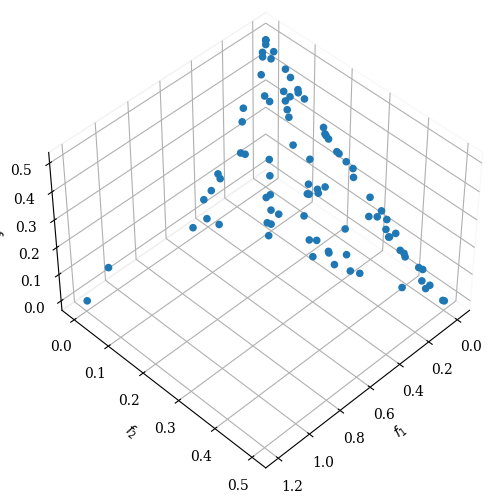

In [15]:
Scatter().add(res.F).show()

In [ ]:
PCP().add(res.F).show()

In [48]:
with open('pymoo_time_nsga3_dtlz1_92_500_3_4.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_dtlz1_92_500_3_4.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |       91 |  0.0095837116
     2 |      182 |  0.0233883858
     3 |      273 |  0.0343604088
     4 |      364 |  0.0463314056
     5 |      455 |  0.0612347126
     6 |      546 |  0.0719759464
     7 |      637 |  0.0809521675
     8 |      728 |  0.0930883884
     9 |      819 |  0.1010422707
    10 |      910 |  0.1130425930
    11 |     1001 |  0.1250448227
    12 |     1092 |  0.1370453835
    13 |     1183 |  0.1450464725
    14 |     1274 |  0.1683986187
    15 |     1365 |  0.1836628914
    16 |     1456 |  0.1960792542
    17 |     1547 |  0.2053079605
    18 |     1638 |  0.2165644169
    19 |     1729 |  0.2316732407
    20 |     1820 |  0.2437777519
    21 |     1911 |  0.2587363720
    22 |     2002 |  0.2740190029
    23 |     2093 |  0.2880792618
    24 |     2184 |  0.2995035648
    25 |     2275 |  0.3097512722
    26 |     2366 |  0.3194682598
    27 |     2457 |  0.3395750523
    28 |     2548 |  0.3497686386
    29 |     2

   243 |    22113 |  3.3296396732
   244 |    22204 |  3.3574984074
   245 |    22295 |  3.3737127781
   246 |    22386 |  3.3935754299
   247 |    22477 |  3.4176912308
   248 |    22568 |  3.4357347488
   249 |    22659 |  3.4473066330
   250 |    22750 |  3.4593069553
   251 |    22841 |  3.4713065624
   252 |    22932 |  3.4793059826
   253 |    23023 |  3.4953081608
   254 |    23114 |  3.5056984425
   255 |    23205 |  3.5176978111
   256 |    23296 |  3.5296978951
   257 |    23387 |  3.5466058254
   258 |    23478 |  3.5615437031
   259 |    23569 |  3.5734069347
   260 |    23660 |  3.5833795071
   261 |    23751 |  3.5935001373
   262 |    23842 |  3.6111817360
   263 |    23933 |  3.6245641708
   264 |    24024 |  3.6354990005
   265 |    24115 |  3.6478781700
   266 |    24206 |  3.6619431973
   267 |    24297 |  3.6739056110
   268 |    24388 |  3.6819050312
   269 |    24479 |  3.6939053535
   270 |    24570 |  3.7059051991
   271 |    24661 |  3.7179059982
   272 |    24

   490 |    44590 |  6.5854592323
   491 |    44681 |  6.6034147739
   492 |    44772 |  6.6144230366
   493 |    44863 |  6.6263492107
   494 |    44954 |  6.6413128376
   495 |    45045 |  6.6572685242
   496 |    45136 |  6.6672399044
   497 |    45227 |  6.6812038422
   498 |    45318 |  6.6981575489
   499 |    45409 |  6.7101264000
   500 |    45500 |  6.7240886688


In [18]:
res.X[50]

array([0.99999949, 0.41661999, 0.50001196, 0.49999905])

## DTLZ 2

In [49]:
NOBJ = 4
NDIM = 5
P = 7

ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
MU=ref_dirs.shape[0]

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

In [50]:
problem = DTLZ2(n_var=NDIM, n_obj=NOBJ)

In [51]:
with open('pymoo_time_nsga3_dtlz2_120_500_4_5.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_dtlz2_120_500_4_5.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3","f4"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      120 |  0.0169546604
     2 |      240 |  0.0398943424
     3 |      360 |  0.0588819981
     4 |      480 |  0.0748438835
     5 |      600 |  0.0927526951
     6 |      720 |  0.1097068787
     7 |      840 |  0.1267037392
     8 |      960 |  0.1426563263
     9 |     1080 |  0.1605687141
    10 |     1200 |  0.1765279770
    11 |     1320 |  0.1955194473
    12 |     1440 |  0.2114741802
    13 |     1560 |  0.2303853035
    14 |     1680 |  0.2573106289
    15 |     1800 |  0.2772967815
    16 |     1920 |  0.2991998196
    17 |     2040 |  0.3171496391
    18 |     2160 |  0.3331072330
    19 |     2280 |  0.3511002064
    20 |     2400 |  0.3680155277
    21 |     2520 |  0.3859658241
    22 |     2640 |  0.4029221535
    23 |     2760 |  0.4238650799
    24 |     2880 |  0.4478023052
    25 |     3000 |  0.4677472115
    26 |     3120 |  0.4916834831
    27 |     3240 |  0.5136253834
    28 |     3360 |  0.5335714817
    29 |     3

   239 |    28680 |  4.6113936901
   240 |    28800 |  4.6322999001
   241 |    28920 |  4.6512882710
   242 |    29040 |  4.6672453880
   243 |    29160 |  4.6861939430
   244 |    29280 |  4.7021508217
   245 |    29400 |  4.7210643291
   246 |    29520 |  4.7380175591
   247 |    29640 |  4.7559690475
   248 |    29760 |  4.7729647160
   249 |    29880 |  4.7919116020
   250 |    30000 |  4.8088717461
   251 |    30120 |  4.8297724724
   252 |    30240 |  4.8517127037
   253 |    30360 |  4.8676707745
   254 |    30480 |  4.8856601715
   255 |    30600 |  4.9025785923
   256 |    30720 |  4.9205701351
   257 |    30840 |  4.9374833107
   258 |    30960 |  4.9554355145
   259 |    31080 |  4.9733889103
   260 |    31200 |  4.9913413525
   261 |    31320 |  5.0082943439
   262 |    31440 |  5.0252869129
   263 |    31560 |  5.0461933613
   264 |    31680 |  5.0651443005
   265 |    31800 |  5.0850884914
   266 |    31920 |  5.1020448208
   267 |    32040 |  5.1219894886
   268 |    32

   484 |    58080 |  9.2601566315
   485 |    58200 |  9.2878355980
   486 |    58320 |  9.3084697723
   487 |    58440 |  9.3235907555
   488 |    58560 |  9.3415906429
   489 |    58680 |  9.3596282005
   490 |    58800 |  9.3844099045
   491 |    58920 |  9.4035925865
   492 |    59040 |  9.4168276787
   493 |    59160 |  9.4360187054
   494 |    59280 |  9.4540176392
   495 |    59400 |  9.4792151451
   496 |    59520 |  9.5007183552
   497 |    59640 |  9.5236599445
   498 |    59760 |  9.5366814137
   499 |    59880 |  9.5559124947
   500 |    60000 |  9.5738272667


In [52]:
with open('pymoo_time_nsga2_dtlz2_120_500_4_5.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_dtlz2_120_500_4_5.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3","f4"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      120 |  0.0080463886
     2 |      240 |  0.0224003792
     3 |      360 |  0.0324397087
     4 |      480 |  0.0414152145
     5 |      600 |  0.0551214218
     6 |      720 |  0.0647022724
     7 |      840 |  0.0717871189
     8 |      960 |  0.0837843418
     9 |     1080 |  0.0968701839
    10 |     1200 |  0.1117627621
    11 |     1320 |  0.1285741329
    12 |     1440 |  0.1405367851
    13 |     1560 |  0.1534986496
    14 |     1680 |  0.1649246216
    15 |     1800 |  0.1739037037
    16 |     1920 |  0.1856696606
    17 |     2040 |  0.2689046860
    18 |     2160 |  0.2878689766
    19 |     2280 |  0.2999000549
    20 |     2400 |  0.3152523041
    21 |     2520 |  0.3351991177
    22 |     2640 |  0.3497624397
    23 |     2760 |  0.3587398529
    24 |     2880 |  0.3717048168
    25 |     3000 |  0.3897879124
    26 |     3120 |  0.3998692036
    27 |     3240 |  0.4048895836
    28 |     3360 |  0.4149363041
    29 |     3

   256 |    30720 |  2.8697590828
   257 |    30840 |  2.8852045536
   258 |    30960 |  2.8950295448
   259 |    31080 |  2.9040427208
   260 |    31200 |  2.9184191227
   261 |    31320 |  2.9265272617
   262 |    31440 |  2.9351248741
   263 |    31560 |  2.9447216988
   264 |    31680 |  2.9551954269
   265 |    31800 |  2.9665412903
   266 |    31920 |  2.9746110439
   267 |    32040 |  2.9905388355
   268 |    32160 |  3.0025408268
   269 |    32280 |  3.0155894756
   270 |    32400 |  3.0236210823
   271 |    32520 |  3.0315849781
   272 |    32640 |  3.0395846367
   273 |    32760 |  3.0515811443
   274 |    32880 |  3.0595812798
   275 |    33000 |  3.0675816536
   276 |    33120 |  3.0839915276
   277 |    33240 |  3.0950045586
   278 |    33360 |  3.1040203571
   279 |    33480 |  3.1148588657
   280 |    33600 |  3.1228370667
   281 |    33720 |  3.1289026737
   282 |    33840 |  3.1409423351
   283 |    33960 |  3.1489460468
   284 |    34080 |  3.1569027901
   285 |    34

## DTLZ 3

In [53]:
NOBJ = 6
NDIM = 6
P = 5

ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
MU=ref_dirs.shape[0]

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

In [54]:
problem = DTLZ3(n_var=NDIM, n_obj=NOBJ)

In [55]:
MU

252

In [56]:
with open('pymoo_time_nsga3_dtlz3_252_500_6_6.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_dtlz3_252_500_6_6.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3","f4","f5","f6"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      252 |  0.0430462360
     2 |      504 |  0.0971291065
     3 |      756 |  0.1634771824
     4 |     1008 |  0.2237303257
     5 |     1260 |  0.2793867588
     6 |     1512 |  0.3416662216
     7 |     1764 |  0.3970444202
     8 |     2016 |  0.4410815239
     9 |     2268 |  0.4931616783
    10 |     2520 |  0.5469219685
    11 |     2772 |  0.6131591797
    12 |     3024 |  0.6971385479
    13 |     3276 |  0.7610397339
    14 |     3528 |  0.8410499096
    15 |     3780 |  0.9144749641
    16 |     4032 |  0.9814200401
    17 |     4284 |  1.0414204597
    18 |     4536 |  1.1168820858
    19 |     4788 |  1.2232747078
    20 |     5040 |  1.2809982300
    21 |     5292 |  1.3449604511
    22 |     5544 |  1.4051520824
    23 |     5796 |  1.4833288193
    24 |     6048 |  1.5449764729
    25 |     6300 |  1.6131460667
    26 |     6552 |  1.6732280254
    27 |     6804 |  1.7464373112
    28 |     7056 |  1.8113265038
    29 |     7

   242 |    60984 |  1.646631E+01
   243 |    61236 |  1.653612E+01
   244 |    61488 |  1.659895E+01
   245 |    61740 |  1.666087E+01
   246 |    61992 |  1.672665E+01
   247 |    62244 |  1.679252E+01
   248 |    62496 |  1.685734E+01
   249 |    62748 |  1.699194E+01
   250 |    63000 |  1.706275E+01
   251 |    63252 |  1.712662E+01
   252 |    63504 |  1.718842E+01
   253 |    63756 |  1.725424E+01
   254 |    64008 |  1.731563E+01
   255 |    64260 |  1.737820E+01
   256 |    64512 |  1.744007E+01
   257 |    64764 |  1.750490E+01
   258 |    65016 |  1.756869E+01
   259 |    65268 |  1.763052E+01
   260 |    65520 |  1.769339E+01
   261 |    65772 |  1.776217E+01
   262 |    66024 |  1.782800E+01
   263 |    66276 |  1.789186E+01
   264 |    66528 |  1.795466E+01
   265 |    66780 |  1.802654E+01
   266 |    67032 |  1.809137E+01
   267 |    67284 |  1.815620E+01
   268 |    67536 |  1.821508E+01
   269 |    67788 |  1.828231E+01
   270 |    68040 |  1.834910E+01
   271 |    68

   483 |   121716 |  3.367200E+01
   484 |   121968 |  3.374365E+01
   485 |   122220 |  3.383698E+01
   486 |   122472 |  3.390917E+01
   487 |   122724 |  3.397317E+01
   488 |   122976 |  3.404121E+01
   489 |   123228 |  3.410517E+01
   490 |   123480 |  3.416917E+01
   491 |   123732 |  3.423321E+01
   492 |   123984 |  3.429717E+01
   493 |   124236 |  3.435720E+01
   494 |   124488 |  3.442517E+01
   495 |   124740 |  3.448920E+01
   496 |   124992 |  3.454920E+01
   497 |   125244 |  3.461320E+01
   498 |   125496 |  3.468246E+01
   499 |   125748 |  3.474643E+01
   500 |   126000 |  3.481094E+01


In [57]:
with open('pymoo_time_nsga2_dtlz3_252_500_6_6.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_dtlz3_252_500_6_6.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3","f4","f5","f6"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      252 |  0.0160017014
     2 |      504 |  0.0440013409
     3 |      756 |  0.0653834343
     4 |     1008 |  0.0855295658
     5 |     1260 |  0.1094939709
     6 |     1512 |  0.1494932175
     7 |     1764 |  0.1820633411
     8 |     2016 |  0.2060666084
     9 |     2268 |  0.2311291695
    10 |     2520 |  0.2529175282
    11 |     2772 |  0.2778646946
    12 |     3024 |  0.3018605709
    13 |     3276 |  0.3218584061
    14 |     3528 |  0.3458194733
    15 |     3780 |  0.3660557270
    16 |     4032 |  0.3940920830
    17 |     4284 |  0.4180953503
    18 |     4536 |  0.4380538464
    19 |     4788 |  0.4699435234
    20 |     5040 |  0.4939427376
    21 |     5292 |  0.5179426670
    22 |     5544 |  0.5419397354
    23 |     5796 |  0.5619430542
    24 |     6048 |  0.5819423199
    25 |     6300 |  0.6059768200
    26 |     6552 |  0.6259486675
    27 |     6804 |  0.6478612423
    28 |     7056 |  0.6742413044
    29 |     7

   244 |    61488 |  5.9536290169
   245 |    61740 |  5.9816348553
   246 |    61992 |  6.0016369820
   247 |    62244 |  6.0216357708
   248 |    62496 |  6.0456357002
   249 |    62748 |  6.1177477837
   250 |    63000 |  6.1377856731
   251 |    63252 |  6.1617472172
   252 |    63504 |  6.1857171059
   253 |    63756 |  6.2057530880
   254 |    64008 |  6.2257196903
   255 |    64260 |  6.2457175255
   256 |    64512 |  6.2697196007
   257 |    64764 |  6.2882242203
   258 |    65016 |  6.3122260571
   259 |    65268 |  6.3322644234
   260 |    65520 |  6.3522288799
   261 |    65772 |  6.3722977638
   262 |    66024 |  6.3937103748
   263 |    66276 |  6.4137091637
   264 |    66528 |  6.4376695156
   265 |    66780 |  6.4576683044
   266 |    67032 |  6.4778575897
   267 |    67284 |  6.4978845119
   268 |    67536 |  6.5218868256
   269 |    67788 |  6.5378856659
   270 |    68040 |  6.5618844032
   271 |    68292 |  6.5817511082
   272 |    68544 |  6.6017105579
   273 |    68

   489 |   123228 |  1.133209E+01
   490 |   123480 |  1.135609E+01
   491 |   123732 |  1.137609E+01
   492 |   123984 |  1.139610E+01
   493 |   124236 |  1.141610E+01
   494 |   124488 |  1.144810E+01
   495 |   124740 |  1.146810E+01
   496 |   124992 |  1.149231E+01
   497 |   125244 |  1.151231E+01
   498 |   125496 |  1.153235E+01
   499 |   125748 |  1.155631E+01
   500 |   126000 |  1.157631E+01


## DTLZ 7

In [58]:
NOBJ = 3
NDIM = 10
P = 12

ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
MU=ref_dirs.shape[0]

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

In [59]:
problem = DTLZ7(n_var=NDIM, n_obj=NOBJ)

In [60]:
MU

91

In [61]:
with open('pymoo_time_nsga3_dtlz7_92_500_3_10.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_dtlz7_92_500_3_10.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |       91 |  0.0080046654
     2 |      182 |  0.0200424194
     3 |      273 |  0.0280039310
     4 |      364 |  0.0400075912
     5 |      455 |  0.0480430126
     6 |      546 |  0.0600090027
     7 |      637 |  0.0720071793
     8 |      728 |  0.0800077915
     9 |      819 |  0.0920045376
    10 |      910 |  0.1014580727
    11 |     1001 |  0.1134512424
    12 |     1092 |  0.1214518547
    13 |     1183 |  0.1334884167
    14 |     1274 |  0.1414496899
    15 |     1365 |  0.1534488201
    16 |     1456 |  0.1654484272
    17 |     1547 |  0.1734497547
    18 |     1638 |  0.1854865551
    19 |     1729 |  0.1974492073
    20 |     1820 |  0.2054884434
    21 |     1911 |  0.2174866199
    22 |     2002 |  0.2294514179
    23 |     2093 |  0.2414512634
    24 |     2184 |  0.2534871101
    25 |     2275 |  0.2647745609
    26 |     2366 |  0.2767684460
    27 |     2457 |  0.2848031521
    28 |     2548 |  0.3007371426
    29 |     2

   249 |    22659 |  3.0219979286
   250 |    22750 |  3.0339608192
   251 |    22841 |  3.0459589958
   252 |    22932 |  3.0579600334
   253 |    23023 |  3.0700864792
   254 |    23114 |  3.0820467472
   255 |    23205 |  3.0940909386
   256 |    23296 |  3.1021134853
   257 |    23387 |  3.1142137051
   258 |    23478 |  3.1262161732
   259 |    23569 |  3.1382536888
   260 |    23660 |  3.1502809525
   261 |    23751 |  3.1622192860
   262 |    23842 |  3.1742517948
   263 |    23933 |  3.1862521172
   264 |    24024 |  3.1982517242
   265 |    24115 |  3.2113134861
   266 |    24206 |  3.2193689346
   267 |    24297 |  3.2353410721
   268 |    24388 |  3.2473020554
   269 |    24479 |  3.2593040466
   270 |    24570 |  3.2713053226
   271 |    24661 |  3.2833406925
   272 |    24752 |  3.2953398228
   273 |    24843 |  3.3063580990
   274 |    24934 |  3.3183484077
   275 |    25025 |  3.3303465843
   276 |    25116 |  3.3423476219
   277 |    25207 |  3.3543465137
   278 |    25

In [62]:
with open('pymoo_time_nsga2_dtlz7_220_500_3_10.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_dtlz7_220_500_3_10.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2","f3"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |       91 |  0.0039999485
     2 |      182 |  0.0160360336
     3 |      273 |  0.0239977837
     4 |      364 |  0.0320391655
     5 |      455 |  0.0360395908
     6 |      546 |  0.0440013409
     7 |      637 |  0.0520000458
     8 |      728 |  0.0599987507
     9 |      819 |  0.0679981709
    10 |      910 |  0.0760366917
    11 |     1001 |  0.0838000774
    12 |     1092 |  0.0917994976
    13 |     1183 |  0.0998499393
    14 |     1274 |  0.1118028164
    15 |     1365 |  0.1198036671
    16 |     1456 |  0.1278004646
    17 |     1547 |  0.1358039379
    18 |     1638 |  0.1398029327
    19 |     1729 |  0.1518003941
    20 |     1820 |  0.1598007679
    21 |     1911 |  0.1678035259
    22 |     2002 |  0.1718020439
    23 |     2093 |  0.1798028946
    24 |     2184 |  0.1878020763
    25 |     2275 |  0.1958041191
    26 |     2366 |  0.2038400173
    27 |     2457 |  0.2118043900
    28 |     2548 |  0.2198007107
    29 |     2

   253 |    23023 |  1.9458870888
   254 |    23114 |  1.9538860321
   255 |    23205 |  1.9618878365
   256 |    23296 |  1.9698879719
   257 |    23387 |  1.9778890610
   258 |    23478 |  1.9864397049
   259 |    23569 |  1.9944369793
   260 |    23660 |  2.0024745464
   261 |    23751 |  2.0064783096
   262 |    23842 |  2.0144402981
   263 |    23933 |  2.0224380493
   264 |    24024 |  2.0304384232
   265 |    24115 |  2.0384397507
   266 |    24206 |  2.0464363098
   267 |    24297 |  2.0504353046
   268 |    24388 |  2.0639064312
   269 |    24479 |  2.0698893070
   270 |    24570 |  2.0776851177
   271 |    24661 |  2.0836672783
   272 |    24752 |  2.0906510353
   273 |    24843 |  2.0987656116
   274 |    24934 |  2.1067616940
   275 |    25025 |  2.1107625961
   276 |    25116 |  2.1187644005
   277 |    25207 |  2.1267225742
   278 |    25298 |  2.1347253323
   279 |    25389 |  2.1427247524
   280 |    25480 |  2.1467256546
   281 |    25571 |  2.1547613144
   282 |    25

In [12]:
for i in range(1, 11):
    print(f"Iteration {i}")

    NOBJ = 3
    NDIM = 4
    P = 12

    ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
    MU=92

    algorithm_nsga3 = NSGA3(pop_size=MU, 
                      sampling=FloatRandomSampling(), 
                      selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                      crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                      mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                      ref_dirs=ref_dirs,
                      eliminate_duplicates=False)

    algorithm_nsga2 = NSGA2(pop_size=MU, 
                      sampling=FloatRandomSampling(), 
                      selection = TournamentSelection(func_comp=binary_tournament), 
                      crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                      mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                      eliminate_duplicates=False)


    problem = DTLZ1(n_var=NDIM, n_obj=NOBJ)
    with open(f'pymoo_time_nsga2_dtlz1_92_500_3_4-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga2_dtlz1_92_500_3_4-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2","f3"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)

    with open(f'pymoo_time_nsga3_dtlz1_92_500_3_4-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga3_dtlz1_92_500_3_4-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2","f3"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)


    NOBJ = 4
    NDIM = 5
    P = 7

    ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
    MU=120

    algorithm_nsga3 = NSGA3(pop_size=MU, 
                      sampling=FloatRandomSampling(), 
                      selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                      crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                      mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                      ref_dirs=ref_dirs,
                      eliminate_duplicates=False)

    algorithm_nsga2 = NSGA2(pop_size=MU, 
                      sampling=FloatRandomSampling(), 
                      selection = TournamentSelection(func_comp=binary_tournament), 
                      crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                      mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                      eliminate_duplicates=False)

    problem = DTLZ2(n_var=NDIM, n_obj=NOBJ)
    with open(f'pymoo_time_nsga3_dtlz2_120_500_4_5-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga3_dtlz2_120_500_4_5-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2","f3","f4"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)

    with open(f'pymoo_time_nsga2_dtlz2_120_500_4_5-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga2_dtlz2_120_500_4_5-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2","f3","f4"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)


    NOBJ = 6
    NDIM = 6
    P = 5

    ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
    MU=252

    algorithm_nsga3 = NSGA3(pop_size=MU, 
                      sampling=FloatRandomSampling(), 
                      selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                      crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                      mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                      ref_dirs=ref_dirs,
                      eliminate_duplicates=False)

    algorithm_nsga2 = NSGA2(pop_size=MU, 
                      sampling=FloatRandomSampling(), 
                      selection = TournamentSelection(func_comp=binary_tournament), 
                      crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                      mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                      eliminate_duplicates=False)


    problem = DTLZ3(n_var=NDIM, n_obj=NOBJ)
    with open(f'pymoo_time_nsga3_dtlz3_252_500_6_6-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga3_dtlz3_252_500_6_6-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2","f3","f4","f5","f6"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)

    with open(f'pymoo_time_nsga2_dtlz3_252_500_6_6-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga2_dtlz3_252_500_6_6-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2","f3","f4","f5","f6"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)

    NOBJ = 3
    NDIM = 10
    P = 12

    ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
    MU=92

    algorithm_nsga3 = NSGA3(pop_size=MU, 
                      sampling=FloatRandomSampling(), 
                      selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                      crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                      mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                      ref_dirs=ref_dirs,
                      eliminate_duplicates=False)

    algorithm_nsga2 = NSGA2(pop_size=MU, 
                      sampling=FloatRandomSampling(), 
                      selection = TournamentSelection(func_comp=binary_tournament), 
                      crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                      mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                      eliminate_duplicates=False)

    problem = DTLZ7(n_var=NDIM, n_obj=NOBJ)
    with open(f'pymoo_time_nsga3_dtlz7_92_500_3_10-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga3_dtlz7_92_500_3_10-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2","f3"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)

    with open(f'pymoo_time_nsga2_dtlz7_92_500_3_10-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga2_dtlz7_92_500_3_10-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2","f3"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)

Iteration 1
n_gen  |  n_eval  |     x_time   
     1 |       92 |  0.0196037292
     2 |      184 |  0.0518829823
     3 |      276 |  0.0646309853
     4 |      368 |  0.0726244450
     5 |      460 |  0.0931022167
     6 |      552 |  0.1133029461
     7 |      644 |  0.1281149387
     8 |      736 |  0.1378798485
     9 |      828 |  0.1488368511
    10 |      920 |  0.1546328068
    11 |     1012 |  0.1683497429
    12 |     1104 |  0.2013301849
    13 |     1196 |  0.2264788151
    14 |     1288 |  0.2459695339
    15 |     1380 |  0.2591259480
    16 |     1472 |  0.2734148502
    17 |     1564 |  0.2850086689
    18 |     1656 |  0.2967028618
    19 |     1748 |  0.3175003529
    20 |     1840 |  0.3329176903
    21 |     1932 |  0.3446273804
    22 |     2024 |  0.3536546230
    23 |     2116 |  0.3625206947
    24 |     2208 |  0.3732473850
    25 |     2300 |  0.3834362030
    26 |     2392 |  0.3854296207
    27 |     2484 |  0.3980422020
    28 |     2576 |  0.4058055878
  

   241 |    22172 |  2.7790811062
   242 |    22264 |  2.7916939259
   243 |    22356 |  2.8049042225
   244 |    22448 |  2.8153605461
   245 |    22540 |  2.8224127293
   246 |    22632 |  2.8326241970
   247 |    22724 |  2.8356554508
   248 |    22816 |  2.8497335911
   249 |    22908 |  2.8569059372
   250 |    23000 |  2.8678841591
   251 |    23092 |  2.8751130104
   252 |    23184 |  2.8856360912
   253 |    23276 |  2.8948240280
   254 |    23368 |  2.9045374393
   255 |    23460 |  2.9154901505
   256 |    23552 |  2.9154901505
   257 |    23644 |  2.9344401360
   258 |    23736 |  2.9414269924
   259 |    23828 |  2.9488897324
   260 |    23920 |  2.9587547779
   261 |    24012 |  2.9663937092
   262 |    24104 |  2.9778397083
   263 |    24196 |  2.9904263020
   264 |    24288 |  3.0038993359
   265 |    24380 |  3.0158641338
   266 |    24472 |  3.0260996819
   267 |    24564 |  3.0345489979
   268 |    24656 |  3.0471978188
   269 |    24748 |  3.0581119061
   270 |    24

   483 |    44436 |  5.4195637703
   484 |    44528 |  5.4326429367
   485 |    44620 |  5.4484245777
   486 |    44712 |  5.4592499733
   487 |    44804 |  5.4677696228
   488 |    44896 |  5.4827365875
   489 |    44988 |  5.4978115559
   490 |    45080 |  5.5102324486
   491 |    45172 |  5.5200729370
   492 |    45264 |  5.5311927795
   493 |    45356 |  5.5422434807
   494 |    45448 |  5.5525925159
   495 |    45540 |  5.5618925095
   496 |    45632 |  5.5749113560
   497 |    45724 |  5.5855021477
   498 |    45816 |  5.5987584591
   499 |    45908 |  5.6124117374
   500 |    46000 |  5.6252763271
n_gen  |  n_eval  |     x_time   
     1 |       92 |  0.0122797489
     2 |      184 |  0.0341670513
     3 |      276 |  0.0487658978
     4 |      368 |  0.0596404076
     5 |      460 |  0.0812873840
     6 |      552 |  0.0923309326
     7 |      644 |  0.1063385010
     8 |      736 |  0.1188888550
     9 |      828 |  0.1400511265
    10 |      920 |  0.1498682499
    11 |     1

   228 |    20976 |  3.9145357609
   229 |    21068 |  3.9322719574
   230 |    21160 |  3.9477591515
   231 |    21252 |  3.9596290588
   232 |    21344 |  3.9741563797
   233 |    21436 |  3.9895997047
   234 |    21528 |  3.9985570908
   235 |    21620 |  4.0179541111
   236 |    21712 |  4.0306434631
   237 |    21804 |  4.0500092506
   238 |    21896 |  4.0628523827
   239 |    21988 |  4.0811355114
   240 |    22080 |  4.0964426994
   241 |    22172 |  4.1128113270
   242 |    22264 |  4.1338009834
   243 |    22356 |  4.1479625702
   244 |    22448 |  4.1605970860
   245 |    22540 |  4.1766679287
   246 |    22632 |  4.1898190975
   247 |    22724 |  4.2083954811
   248 |    22816 |  4.2221310139
   249 |    22908 |  4.2388086319
   250 |    23000 |  4.2610638142
   251 |    23092 |  4.2830886841
   252 |    23184 |  4.3148615360
   253 |    23276 |  4.3306262493
   254 |    23368 |  4.3454127312
   255 |    23460 |  4.3643214703
   256 |    23552 |  4.3768863678
   257 |    23

   470 |    43240 |  8.5527637005
   471 |    43332 |  8.5686681271
   472 |    43424 |  8.5834469795
   473 |    43516 |  8.6006293297
   474 |    43608 |  8.6184532642
   475 |    43700 |  8.6407852173
   476 |    43792 |  8.6495397091
   477 |    43884 |  8.6785101891
   478 |    43976 |  8.6959433556
   479 |    44068 |  8.7125873566
   480 |    44160 |  8.7296571732
   481 |    44252 |  8.7462077141
   482 |    44344 |  8.7632825375
   483 |    44436 |  8.7814738750
   484 |    44528 |  8.8010578156
   485 |    44620 |  8.8186182976
   486 |    44712 |  8.8416781425
   487 |    44804 |  8.8623812199
   488 |    44896 |  8.8789567947
   489 |    44988 |  8.8966665268
   490 |    45080 |  8.9106302261
   491 |    45172 |  8.9277060032
   492 |    45264 |  8.9446556568
   493 |    45356 |  8.9593915939
   494 |    45448 |  8.9786393642
   495 |    45540 |  8.9980149269
   496 |    45632 |  9.0143849850
   497 |    45724 |  9.0314197540
   498 |    45816 |  9.0478806496
   499 |    45

   217 |    26040 |  5.8423027992
   218 |    26160 |  5.8714542389
   219 |    26280 |  5.8935854435
   220 |    26400 |  5.9123194218
   221 |    26520 |  5.9410994053
   222 |    26640 |  5.9618780613
   223 |    26760 |  5.9820804596
   224 |    26880 |  6.0086507797
   225 |    27000 |  6.0288000107
   226 |    27120 |  6.0545210838
   227 |    27240 |  6.0791282654
   228 |    27360 |  6.1076138020
   229 |    27480 |  6.1295125484
   230 |    27600 |  6.1550114155
   231 |    27720 |  6.1775617599
   232 |    27840 |  6.2027392387
   233 |    27960 |  6.2260224819
   234 |    28080 |  6.2470545769
   235 |    28200 |  6.2759141922
   236 |    28320 |  6.2945303917
   237 |    28440 |  6.3238394260
   238 |    28560 |  6.3462038040
   239 |    28680 |  6.3611922264
   240 |    28800 |  6.3941984177
   241 |    28920 |  6.4129452705
   242 |    29040 |  6.4412412643
   243 |    29160 |  6.4634001255
   244 |    29280 |  6.4907393456
   245 |    29400 |  6.5121192932
   246 |    29

   458 |    54960 |  1.187639E+01
   459 |    55080 |  1.189371E+01
   460 |    55200 |  1.192552E+01
   461 |    55320 |  1.194354E+01
   462 |    55440 |  1.197425E+01
   463 |    55560 |  1.199390E+01
   464 |    55680 |  1.202068E+01
   465 |    55800 |  1.204327E+01
   466 |    55920 |  1.207535E+01
   467 |    56040 |  1.210483E+01
   468 |    56160 |  1.213998E+01
   469 |    56280 |  1.216133E+01
   470 |    56400 |  1.218203E+01
   471 |    56520 |  1.220378E+01
   472 |    56640 |  1.222626E+01
   473 |    56760 |  1.224354E+01
   474 |    56880 |  1.227211E+01
   475 |    57000 |  1.229195E+01
   476 |    57120 |  1.231221E+01
   477 |    57240 |  1.233701E+01
   478 |    57360 |  1.235716E+01
   479 |    57480 |  1.237985E+01
   480 |    57600 |  1.240654E+01
   481 |    57720 |  1.242657E+01
   482 |    57840 |  1.244296E+01
   483 |    57960 |  1.247071E+01
   484 |    58080 |  1.249216E+01
   485 |    58200 |  1.251122E+01
   486 |    58320 |  1.253103E+01
   487 |    58

   211 |    25320 |  3.0083487034
   212 |    25440 |  3.0180032253
   213 |    25560 |  3.0320920944
   214 |    25680 |  3.0446646214
   215 |    25800 |  3.0577008724
   216 |    25920 |  3.0730113983
   217 |    26040 |  3.0789954662
   218 |    26160 |  3.0986640453
   219 |    26280 |  3.1130552292
   220 |    26400 |  3.1259038448
   221 |    26520 |  3.1401586533
   222 |    26640 |  3.1489951611
   223 |    26760 |  3.1639363766
   224 |    26880 |  3.1772291660
   225 |    27000 |  3.1868219376
   226 |    27120 |  3.2001891136
   227 |    27240 |  3.2146883011
   228 |    27360 |  3.2292568684
   229 |    27480 |  3.2432062626
   230 |    27600 |  3.2566792965
   231 |    27720 |  3.2678277493
   232 |    27840 |  3.2807319164
   233 |    27960 |  3.2959625721
   234 |    28080 |  3.3082225323
   235 |    28200 |  3.3189959526
   236 |    28320 |  3.3307120800
   237 |    28440 |  3.3462584019
   238 |    28560 |  3.3582670689
   239 |    28680 |  3.3694949150
   240 |    28

   456 |    54720 |  6.5465793610
   457 |    54840 |  6.5688679218
   458 |    54960 |  6.5897181034
   459 |    55080 |  6.5987830162
   460 |    55200 |  6.6149561405
   461 |    55320 |  6.6276495457
   462 |    55440 |  6.6400091648
   463 |    55560 |  6.6488661766
   464 |    55680 |  6.6635911465
   465 |    55800 |  6.6752581596
   466 |    55920 |  6.6809957027
   467 |    56040 |  6.7016210556
   468 |    56160 |  6.7232766151
   469 |    56280 |  6.7361669540
   470 |    56400 |  6.7488396168
   471 |    56520 |  6.7657716274
   472 |    56640 |  6.7795045376
   473 |    56760 |  6.7928414345
   474 |    56880 |  6.8000566959
   475 |    57000 |  6.8164582253
   476 |    57120 |  6.8295845985
   477 |    57240 |  6.8425588608
   478 |    57360 |  6.8488433361
   479 |    57480 |  6.8638620377
   480 |    57600 |  6.8800187111
   481 |    57720 |  6.8917448521
   482 |    57840 |  6.9000089169
   483 |    57960 |  6.9232349396
   484 |    58080 |  6.9409177303
   485 |    58

   194 |    48888 |  1.607315E+01
   195 |    49140 |  1.615749E+01
   196 |    49392 |  1.624997E+01
   197 |    49644 |  1.634103E+01
   198 |    49896 |  1.642494E+01
   199 |    50148 |  1.650946E+01
   200 |    50400 |  1.659279E+01
   201 |    50652 |  1.666906E+01
   202 |    50904 |  1.674397E+01
   203 |    51156 |  1.682596E+01
   204 |    51408 |  1.690296E+01
   205 |    51660 |  1.698453E+01
   206 |    51912 |  1.706845E+01
   207 |    52164 |  1.714384E+01
   208 |    52416 |  1.724452E+01
   209 |    52668 |  1.735192E+01
   210 |    52920 |  1.743979E+01
   211 |    53172 |  1.752495E+01
   212 |    53424 |  1.761649E+01
   213 |    53676 |  1.770191E+01
   214 |    53928 |  1.779001E+01
   215 |    54180 |  1.787879E+01
   216 |    54432 |  1.795764E+01
   217 |    54684 |  1.804410E+01
   218 |    54936 |  1.812460E+01
   219 |    55188 |  1.828898E+01
   220 |    55440 |  1.839673E+01
   221 |    55692 |  1.849061E+01
   222 |    55944 |  1.857583E+01
   223 |    56

   437 |   110124 |  3.705378E+01
   438 |   110376 |  3.713914E+01
   439 |   110628 |  3.722407E+01
   440 |   110880 |  3.733557E+01
   441 |   111132 |  3.742919E+01
   442 |   111384 |  3.752193E+01
   443 |   111636 |  3.760390E+01
   444 |   111888 |  3.769014E+01
   445 |   112140 |  3.777469E+01
   446 |   112392 |  3.786064E+01
   447 |   112644 |  3.794480E+01
   448 |   112896 |  3.803841E+01
   449 |   113148 |  3.812181E+01
   450 |   113400 |  3.820729E+01
   451 |   113652 |  3.828892E+01
   452 |   113904 |  3.837682E+01
   453 |   114156 |  3.845733E+01
   454 |   114408 |  3.855195E+01
   455 |   114660 |  3.862361E+01
   456 |   114912 |  3.870848E+01
   457 |   115164 |  3.878967E+01
   458 |   115416 |  3.886981E+01
   459 |   115668 |  3.894835E+01
   460 |   115920 |  3.902464E+01
   461 |   116172 |  3.910865E+01
   462 |   116424 |  3.919485E+01
   463 |   116676 |  3.930854E+01
   464 |   116928 |  3.939924E+01
   465 |   117180 |  3.947458E+01
   466 |   117

   177 |    44604 |  5.5583655834
   178 |    44856 |  5.5845115185
   179 |    45108 |  5.6136252880
   180 |    45360 |  5.6459257603
   181 |    45612 |  5.6757078171
   182 |    45864 |  5.7024185658
   183 |    46116 |  5.7322640419
   184 |    46368 |  5.7634813786
   185 |    46620 |  5.7935121059
   186 |    46872 |  5.8183460236
   187 |    47124 |  5.8479356766
   188 |    47376 |  5.8810117245
   189 |    47628 |  5.9136524200
   190 |    47880 |  5.9428663254
   191 |    48132 |  5.9653205872
   192 |    48384 |  5.9976336956
   193 |    48636 |  6.0288558006
   194 |    48888 |  6.0525863171
   195 |    49140 |  6.0808925629
   196 |    49392 |  6.1088802814
   197 |    49644 |  6.1345238686
   198 |    49896 |  6.1652340889
   199 |    50148 |  6.1916165352
   200 |    50400 |  6.2144644260
   201 |    50652 |  6.2469663620
   202 |    50904 |  6.2769303322
   203 |    51156 |  6.2987756729
   204 |    51408 |  6.3300294876
   205 |    51660 |  6.3569905758
   206 |    51

   419 |   105588 |  1.255244E+01
   420 |   105840 |  1.259143E+01
   421 |   106092 |  1.263372E+01
   422 |   106344 |  1.266558E+01
   423 |   106596 |  1.269488E+01
   424 |   106848 |  1.279467E+01
   425 |   107100 |  1.283562E+01
   426 |   107352 |  1.287747E+01
   427 |   107604 |  1.290919E+01
   428 |   107856 |  1.293428E+01
   429 |   108108 |  1.296348E+01
   430 |   108360 |  1.299375E+01
   431 |   108612 |  1.301482E+01
   432 |   108864 |  1.304616E+01
   433 |   109116 |  1.307362E+01
   434 |   109368 |  1.309636E+01
   435 |   109620 |  1.312529E+01
   436 |   109872 |  1.315520E+01
   437 |   110124 |  1.317855E+01
   438 |   110376 |  1.320552E+01
   439 |   110628 |  1.323084E+01
   440 |   110880 |  1.325992E+01
   441 |   111132 |  1.327908E+01
   442 |   111384 |  1.331211E+01
   443 |   111636 |  1.333427E+01
   444 |   111888 |  1.336138E+01
   445 |   112140 |  1.338441E+01
   446 |   112392 |  1.341194E+01
   447 |   112644 |  1.344346E+01
   448 |   112

   159 |    14628 |  2.6957948208
   160 |    14720 |  2.7124798298
   161 |    14812 |  2.7300548553
   162 |    14904 |  2.7518861294
   163 |    14996 |  2.7623181343
   164 |    15088 |  2.7841691971
   165 |    15180 |  2.8000061512
   166 |    15272 |  2.8176970482
   167 |    15364 |  2.8360652924
   168 |    15456 |  2.8609790802
   169 |    15548 |  2.8795738220
   170 |    15640 |  2.8950784206
   171 |    15732 |  2.9124121666
   172 |    15824 |  2.9291226864
   173 |    15916 |  2.9459116459
   174 |    16008 |  2.9624321461
   175 |    16100 |  2.9774093628
   176 |    16192 |  2.9851627350
   177 |    16284 |  3.0030400753
   178 |    16376 |  3.0208256245
   179 |    16468 |  3.0345795155
   180 |    16560 |  3.0491833687
   181 |    16652 |  3.0616779327
   182 |    16744 |  3.0774247646
   183 |    16836 |  3.0910799503
   184 |    16928 |  3.1116478443
   185 |    17020 |  3.1279530525
   186 |    17112 |  3.1475124359
   187 |    17204 |  3.1635398865
   188 |    17

   400 |    36800 |  6.8957474232
   401 |    36892 |  6.9159765244
   402 |    36984 |  6.9291973114
   403 |    37076 |  6.9461591244
   404 |    37168 |  6.9629330635
   405 |    37260 |  6.9775891304
   406 |    37352 |  6.9926049709
   407 |    37444 |  7.0027511120
   408 |    37536 |  7.0201168060
   409 |    37628 |  7.0342266560
   410 |    37720 |  7.0509064198
   411 |    37812 |  7.0624301434
   412 |    37904 |  7.0783927441
   413 |    37996 |  7.0950062275
   414 |    38088 |  7.1129348278
   415 |    38180 |  7.1282567978
   416 |    38272 |  7.1450376511
   417 |    38364 |  7.1590480804
   418 |    38456 |  7.1767776012
   419 |    38548 |  7.1922557354
   420 |    38640 |  7.2030100822
   421 |    38732 |  7.2212066650
   422 |    38824 |  7.2344591618
   423 |    38916 |  7.2520883083
   424 |    39008 |  7.2685110569
   425 |    39100 |  7.2839937210
   426 |    39192 |  7.2963814735
   427 |    39284 |  7.3151593208
   428 |    39376 |  7.3320558071
   429 |    39

   151 |    13892 |  1.6327512264
   152 |    13984 |  1.6508576870
   153 |    14076 |  1.6647679806
   154 |    14168 |  1.6729481220
   155 |    14260 |  1.6900556087
   156 |    14352 |  1.6971418858
   157 |    14444 |  1.7058722973
   158 |    14536 |  1.7149877548
   159 |    14628 |  1.7261674404
   160 |    14720 |  1.7362723351
   161 |    14812 |  1.7483661175
   162 |    14904 |  1.7609202862
   163 |    14996 |  1.7700376511
   164 |    15088 |  1.7829070091
   165 |    15180 |  1.7932660580
   166 |    15272 |  1.8031008244
   167 |    15364 |  1.8138477802
   168 |    15456 |  1.8264501095
   169 |    15548 |  1.8361432552
   170 |    15640 |  1.8478038311
   171 |    15732 |  1.8595817089
   172 |    15824 |  1.8648867607
   173 |    15916 |  1.8770339489
   174 |    16008 |  1.8917703629
   175 |    16100 |  1.8964123726
   176 |    16192 |  1.9119789600
   177 |    16284 |  1.9149706364
   178 |    16376 |  1.9296731949
   179 |    16468 |  1.9343128204
   180 |    16

   400 |    36800 |  4.6974833012
   401 |    36892 |  4.7090306282
   402 |    36984 |  4.7174255848
   403 |    37076 |  4.7291097641
   404 |    37168 |  4.7362055779
   405 |    37260 |  4.7473807335
   406 |    37352 |  4.7566063404
   407 |    37444 |  4.7662029266
   408 |    37536 |  4.7751429081
   409 |    37628 |  4.7910673618
   410 |    37720 |  4.8011066914
   411 |    37812 |  4.8150982857
   412 |    37904 |  4.8313236237
   413 |    37996 |  4.8433692455
   414 |    38088 |  4.8517675400
   415 |    38180 |  4.8647570610
   416 |    38272 |  4.8740434647
   417 |    38364 |  4.8822677135
   418 |    38456 |  4.8966693878
   419 |    38548 |  4.9076476097
   420 |    38640 |  4.9161164761
   421 |    38732 |  4.9324607849
   422 |    38824 |  4.9430236816
   423 |    38916 |  4.9510471821
   424 |    39008 |  4.9636309147
   425 |    39100 |  4.9646277428
   426 |    39192 |  4.9803755283
   427 |    39284 |  4.9908573627
   428 |    39376 |  4.9987213612
   429 |    39

   154 |    14168 |  1.5149166584
   155 |    14260 |  1.5208425522
   156 |    14352 |  1.5387413502
   157 |    14444 |  1.5530736446
   158 |    14536 |  1.5734195709
   159 |    14628 |  1.5818612576
   160 |    14720 |  1.6006467342
   161 |    14812 |  1.6143517494
   162 |    14904 |  1.6244976521
   163 |    14996 |  1.6386275291
   164 |    15088 |  1.6472799778
   165 |    15180 |  1.6564750671
   166 |    15272 |  1.6654651165
   167 |    15364 |  1.6892697811
   168 |    15456 |  1.6989028454
   169 |    15548 |  1.7079672813
   170 |    15640 |  1.7196867466
   171 |    15732 |  1.7206830978
   172 |    15824 |  1.7356920242
   173 |    15916 |  1.7485470772
   174 |    16008 |  1.7578017712
   175 |    16100 |  1.7678837776
   176 |    16192 |  1.7705965042
   177 |    16284 |  1.7811837196
   178 |    16376 |  1.7898459435
   179 |    16468 |  1.8041665554
   180 |    16560 |  1.8106038570
   181 |    16652 |  1.8209712505
   182 |    16744 |  1.8209712505
   183 |    16

   397 |    36524 |  3.9024276733
   398 |    36616 |  3.9189863205
   399 |    36708 |  3.9199833870
   400 |    36800 |  3.9387285709
   401 |    36892 |  3.9473078251
   402 |    36984 |  3.9533348083
   403 |    37076 |  3.9661502838
   404 |    37168 |  3.9720659256
   405 |    37260 |  3.9834802151
   406 |    37352 |  3.9901416302
   407 |    37444 |  4.0027942657
   408 |    37536 |  4.0104446411
   409 |    37628 |  4.0212273598
   410 |    37720 |  4.0308938026
   411 |    37812 |  4.0399851799
   412 |    37904 |  4.0495948792
   413 |    37996 |  4.0549538136
   414 |    38088 |  4.0683977604
   415 |    38180 |  4.0730586052
   416 |    38272 |  4.0853075981
   417 |    38364 |  4.0911343098
   418 |    38456 |  4.1045465469
   419 |    38548 |  4.1099498272
   420 |    38640 |  4.1226832867
   421 |    38732 |  4.1357932091
   422 |    38824 |  4.1399979591
   423 |    38916 |  4.1562633514
   424 |    39008 |  4.1666462421
   425 |    39100 |  4.1719722748
   426 |    39

   136 |    12512 |  2.4198768139
   137 |    12604 |  2.4331362247
   138 |    12696 |  2.4539084435
   139 |    12788 |  2.4698407650
   140 |    12880 |  2.4881730080
   141 |    12972 |  2.5061340332
   142 |    13064 |  2.5297529697
   143 |    13156 |  2.5550038815
   144 |    13248 |  2.5797982216
   145 |    13340 |  2.6041951180
   146 |    13432 |  2.6247136593
   147 |    13524 |  2.6441185474
   148 |    13616 |  2.6609764099
   149 |    13708 |  2.6748101711
   150 |    13800 |  2.6906466484
   151 |    13892 |  2.7060625553
   152 |    13984 |  2.7230749130
   153 |    14076 |  2.7328350544
   154 |    14168 |  2.7559640408
   155 |    14260 |  2.7720859051
   156 |    14352 |  2.7911183834
   157 |    14444 |  2.8073143959
   158 |    14536 |  2.8264558315
   159 |    14628 |  2.8431649208
   160 |    14720 |  2.8634519577
   161 |    14812 |  2.8774664402
   162 |    14904 |  2.8916428089
   163 |    14996 |  2.9082746506
   164 |    15088 |  2.9249930382
   165 |    15

   382 |    35144 |  6.5759255886
   383 |    35236 |  6.5948367119
   384 |    35328 |  6.6100001335
   385 |    35420 |  6.6249952316
   386 |    35512 |  6.6467065811
   387 |    35604 |  6.6628415585
   388 |    35696 |  6.6788506508
   389 |    35788 |  6.6947004795
   390 |    35880 |  6.7090222836
   391 |    35972 |  6.7250025272
   392 |    36064 |  6.7455899715
   393 |    36156 |  6.7613635063
   394 |    36248 |  6.7757794857
   395 |    36340 |  6.7926948071
   396 |    36432 |  6.8110508919
   397 |    36524 |  6.8239102364
   398 |    36616 |  6.8424341679
   399 |    36708 |  6.8580358028
   400 |    36800 |  6.8733150959
   401 |    36892 |  6.8882830143
   402 |    36984 |  6.9051141739
   403 |    37076 |  6.9223995209
   404 |    37168 |  6.9380443096
   405 |    37260 |  6.9615817070
   406 |    37352 |  6.9753928185
   407 |    37444 |  6.9946820736
   408 |    37536 |  7.0141065121
   409 |    37628 |  7.0317585468
   410 |    37720 |  7.0484521389
   411 |    37

   120 |    14400 |  3.0818710327
   121 |    14520 |  3.1043970585
   122 |    14640 |  3.1288139820
   123 |    14760 |  3.1495673656
   124 |    14880 |  3.1730787754
   125 |    15000 |  3.1999320984
   126 |    15120 |  3.2206411362
   127 |    15240 |  3.2386000156
   128 |    15360 |  3.2667036057
   129 |    15480 |  3.2882173061
   130 |    15600 |  3.3179540634
   131 |    15720 |  3.3372359276
   132 |    15840 |  3.3701553345
   133 |    15960 |  3.3878524303
   134 |    16080 |  3.4176590443
   135 |    16200 |  3.4359548092
   136 |    16320 |  3.4563851357
   137 |    16440 |  3.4858598709
   138 |    16560 |  3.5132117271
   139 |    16680 |  3.5372097492
   140 |    16800 |  3.5620379448
   141 |    16920 |  3.5860180855
   142 |    17040 |  3.6061768532
   143 |    17160 |  3.6316223145
   144 |    17280 |  3.6530206203
   145 |    17400 |  3.6792609692
   146 |    17520 |  3.7039389610
   147 |    17640 |  3.7269072533
   148 |    17760 |  3.7554132938
   149 |    17

   362 |    43440 |  9.0639221668
   363 |    43560 |  9.0875277519
   364 |    43680 |  9.1061611176
   365 |    43800 |  9.1307907104
   366 |    43920 |  9.1536762714
   367 |    44040 |  9.1703248024
   368 |    44160 |  9.1951594353
   369 |    44280 |  9.2213835716
   370 |    44400 |  9.2468020916
   371 |    44520 |  9.2699248791
   372 |    44640 |  9.2974581718
   373 |    44760 |  9.3206026554
   374 |    44880 |  9.3373880386
   375 |    45000 |  9.3650112152
   376 |    45120 |  9.3869123459
   377 |    45240 |  9.4120004177
   378 |    45360 |  9.4355394840
   379 |    45480 |  9.4560880661
   380 |    45600 |  9.4868836403
   381 |    45720 |  9.5141665936
   382 |    45840 |  9.5361886024
   383 |    45960 |  9.5574917793
   384 |    46080 |  9.5798063278
   385 |    46200 |  9.6020884514
   386 |    46320 |  9.6205096245
   387 |    46440 |  9.6367018223
   388 |    46560 |  9.6675305367
   389 |    46680 |  9.6862328053
   390 |    46800 |  9.7166314125
   391 |    46

   112 |    13440 |  1.6237356663
   113 |    13560 |  1.6413309574
   114 |    13680 |  1.6582343578
   115 |    13800 |  1.6748306751
   116 |    13920 |  1.6922521591
   117 |    14040 |  1.7063038349
   118 |    14160 |  1.7142813206
   119 |    14280 |  1.7304816246
   120 |    14400 |  1.7423036098
   121 |    14520 |  1.7528536320
   122 |    14640 |  1.7635004520
   123 |    14760 |  1.7814464569
   124 |    14880 |  1.7952501774
   125 |    15000 |  1.8075585365
   126 |    15120 |  1.8135645390
   127 |    15240 |  1.8310940266
   128 |    15360 |  1.8429336548
   129 |    15480 |  1.8569483757
   130 |    15600 |  1.8722157478
   131 |    15720 |  1.8838248253
   132 |    15840 |  1.8965067863
   133 |    15960 |  1.9092285633
   134 |    16080 |  1.9127321243
   135 |    16200 |  1.9304702282
   136 |    16320 |  1.9424526691
   137 |    16440 |  1.9557635784
   138 |    16560 |  1.9635424614
   139 |    16680 |  1.9791362286
   140 |    16800 |  1.9904336929
   141 |    16

   365 |    43800 |  5.1418230534
   366 |    43920 |  5.1578562260
   367 |    44040 |  5.1636519432
   368 |    44160 |  5.1806960106
   369 |    44280 |  5.2016286850
   370 |    44400 |  5.2248241901
   371 |    44520 |  5.2474026680
   372 |    44640 |  5.2638366222
   373 |    44760 |  5.2766106129
   374 |    44880 |  5.2882881165
   375 |    45000 |  5.3004250526
   376 |    45120 |  5.3132619858
   377 |    45240 |  5.3254039288
   378 |    45360 |  5.3410425186
   379 |    45480 |  5.3545377254
   380 |    45600 |  5.3624751568
   381 |    45720 |  5.3808636665
   382 |    45840 |  5.3928883076
   383 |    45960 |  5.4023964405
   384 |    46080 |  5.4145591259
   385 |    46200 |  5.4319314957
   386 |    46320 |  5.4453418255
   387 |    46440 |  5.4579069614
   388 |    46560 |  5.4643430710
   389 |    46680 |  5.4827251434
   390 |    46800 |  5.4960775375
   391 |    46920 |  5.5087802410
   392 |    47040 |  5.5212070942
   393 |    47160 |  5.5325646400
   394 |    47

   103 |    25956 |  8.5360426903
   104 |    26208 |  8.6192247868
   105 |    26460 |  8.7005643845
   106 |    26712 |  8.7741119862
   107 |    26964 |  8.8470151424
   108 |    27216 |  8.9265692234
   109 |    27468 |  9.0297052860
   110 |    27720 |  9.1036965847
   111 |    27972 |  9.1856126785
   112 |    28224 |  9.2639584541
   113 |    28476 |  9.3570640087
   114 |    28728 |  9.4411385059
   115 |    28980 |  9.5234236717
   116 |    29232 |  9.6042475700
   117 |    29484 |  9.6835577488
   118 |    29736 |  9.7697889805
   119 |    29988 |  9.8468871117
   120 |    30240 |  9.9234733582
   121 |    30492 |  1.000346E+01
   122 |    30744 |  1.008346E+01
   123 |    30996 |  1.015411E+01
   124 |    31248 |  1.025837E+01
   125 |    31500 |  1.035452E+01
   126 |    31752 |  1.043014E+01
   127 |    32004 |  1.050457E+01
   128 |    32256 |  1.064599E+01
   129 |    32508 |  1.075100E+01
   130 |    32760 |  1.083530E+01
   131 |    33012 |  1.092354E+01
   132 |    33

   345 |    86940 |  2.967088E+01
   346 |    87192 |  2.974641E+01
   347 |    87444 |  2.982103E+01
   348 |    87696 |  2.990465E+01
   349 |    87948 |  2.998486E+01
   350 |    88200 |  3.006672E+01
   351 |    88452 |  3.015124E+01
   352 |    88704 |  3.023362E+01
   353 |    88956 |  3.033086E+01
   354 |    89208 |  3.040336E+01
   355 |    89460 |  3.048026E+01
   356 |    89712 |  3.055407E+01
   357 |    89964 |  3.068476E+01
   358 |    90216 |  3.076601E+01
   359 |    90468 |  3.083460E+01
   360 |    90720 |  3.091837E+01
   361 |    90972 |  3.100389E+01
   362 |    91224 |  3.108690E+01
   363 |    91476 |  3.118923E+01
   364 |    91728 |  3.127900E+01
   365 |    91980 |  3.136954E+01
   366 |    92232 |  3.145009E+01
   367 |    92484 |  3.153224E+01
   368 |    92736 |  3.161234E+01
   369 |    92988 |  3.169101E+01
   370 |    93240 |  3.177164E+01
   371 |    93492 |  3.185726E+01
   372 |    93744 |  3.194938E+01
   373 |    93996 |  3.203604E+01
   374 |    94

    88 |    22176 |  2.7523090839
    89 |    22428 |  2.7847981453
    90 |    22680 |  2.8185422421
    91 |    22932 |  2.8482723236
    92 |    23184 |  2.8866004944
    93 |    23436 |  2.9207441807
    94 |    23688 |  2.9560682774
    95 |    23940 |  2.9988818169
    96 |    24192 |  3.0265734196
    97 |    24444 |  3.0573761463
    98 |    24696 |  3.0846238136
    99 |    24948 |  3.1165087223
   100 |    25200 |  3.1402974129
   101 |    25452 |  3.1732380390
   102 |    25704 |  3.1995637417
   103 |    25956 |  3.2253053188
   104 |    26208 |  3.2536470890
   105 |    26460 |  3.2910752296
   106 |    26712 |  3.3194594383
   107 |    26964 |  3.3510413170
   108 |    27216 |  3.3926837444
   109 |    27468 |  3.4234008789
   110 |    27720 |  3.4558866024
   111 |    27972 |  3.4892690182
   112 |    28224 |  3.5180988312
   113 |    28476 |  3.5498631001
   114 |    28728 |  3.5733208656
   115 |    28980 |  3.6047189236
   116 |    29232 |  3.6955335140
   117 |    29

   331 |    83412 |  1.024811E+01
   332 |    83664 |  1.027644E+01
   333 |    83916 |  1.030488E+01
   334 |    84168 |  1.033346E+01
   335 |    84420 |  1.035862E+01
   336 |    84672 |  1.038812E+01
   337 |    84924 |  1.041701E+01
   338 |    85176 |  1.044820E+01
   339 |    85428 |  1.047812E+01
   340 |    85680 |  1.050544E+01
   341 |    85932 |  1.053345E+01
   342 |    86184 |  1.055745E+01
   343 |    86436 |  1.058540E+01
   344 |    86688 |  1.061434E+01
   345 |    86940 |  1.063850E+01
   346 |    87192 |  1.066708E+01
   347 |    87444 |  1.069139E+01
   348 |    87696 |  1.072329E+01
   349 |    87948 |  1.075421E+01
   350 |    88200 |  1.077643E+01
   351 |    88452 |  1.080456E+01
   352 |    88704 |  1.083244E+01
   353 |    88956 |  1.086032E+01
   354 |    89208 |  1.089114E+01
   355 |    89460 |  1.092413E+01
   356 |    89712 |  1.095361E+01
   357 |    89964 |  1.100219E+01
   358 |    90216 |  1.103940E+01
   359 |    90468 |  1.106851E+01
   360 |    90

    74 |     6808 |  1.1592957973
    75 |     6900 |  1.1808156967
    76 |     6992 |  1.1968326569
    77 |     7084 |  1.2178931236
    78 |     7176 |  1.2338778973
    79 |     7268 |  1.2533493042
    80 |     7360 |  1.2738542557
    81 |     7452 |  1.2907047272
    82 |     7544 |  1.3088116646
    83 |     7636 |  1.3232853413
    84 |     7728 |  1.3390438557
    85 |     7820 |  1.3507592678
    86 |     7912 |  1.3664774895
    87 |     8004 |  1.3844833374
    88 |     8096 |  1.3994650841
    89 |     8188 |  1.4211087227
    90 |     8280 |  1.4328267574
    91 |     8372 |  1.4540727139
    92 |     8464 |  1.4664525986
    93 |     8556 |  1.4909174442
    94 |     8648 |  1.5125324726
    95 |     8740 |  1.5454313755
    96 |     8832 |  1.5786812305
    97 |     8924 |  1.6113088131
    98 |     9016 |  1.6374270916
    99 |     9108 |  1.6627442837
   100 |     9200 |  1.6906781197
   101 |     9292 |  1.7101378441
   102 |     9384 |  1.7375631332
   103 |     9

   321 |    29532 |  5.3252742290
   322 |    29624 |  5.3417677879
   323 |    29716 |  5.3596563339
   324 |    29808 |  5.3753135204
   325 |    29900 |  5.3927896023
   326 |    29992 |  5.4077374935
   327 |    30084 |  5.4235680103
   328 |    30176 |  5.4415230751
   329 |    30268 |  5.4654881954
   330 |    30360 |  5.4834160805
   331 |    30452 |  5.5051388741
   332 |    30544 |  5.5225219727
   333 |    30636 |  5.5395622253
   334 |    30728 |  5.5585360527
   335 |    30820 |  5.5773491859
   336 |    30912 |  5.5905063152
   337 |    31004 |  5.6105377674
   338 |    31096 |  5.6404728889
   339 |    31188 |  5.6654679775
   340 |    31280 |  5.6835062504
   341 |    31372 |  5.6985337734
   342 |    31464 |  5.7141096592
   343 |    31556 |  5.7285947800
   344 |    31648 |  5.7451498508
   345 |    31740 |  5.7593379021
   346 |    31832 |  5.7732913494
   347 |    31924 |  5.7912817001
   348 |    32016 |  5.8079774380
   349 |    32108 |  5.8235445023
   350 |    32

    79 |     7268 |  0.8339824677
    80 |     7360 |  0.8449966908
    81 |     7452 |  0.8565373421
    82 |     7544 |  0.8662204742
    83 |     7636 |  0.8739988804
    84 |     7728 |  0.8859772682
    85 |     7820 |  0.8981468678
    86 |     7912 |  0.9057371616
    87 |     8004 |  0.9172451496
    88 |     8096 |  0.9241814613
    89 |     8188 |  0.9361786842
    90 |     8280 |  0.9453091621
    91 |     8372 |  0.9555580616
    92 |     8464 |  0.9665527344
    93 |     8556 |  0.9741265774
    94 |     8648 |  0.9879837036
    95 |     8740 |  1.0041232109
    96 |     8832 |  1.0230739117
    97 |     8924 |  1.0402259827
    98 |     9016 |  1.0556213856
    99 |     9108 |  1.0683302879
   100 |     9200 |  1.0793907642
   101 |     9292 |  1.0887634754
   102 |     9384 |  1.1041967869
   103 |     9476 |  1.1210997105
   104 |     9568 |  1.1391587257
   105 |     9660 |  1.1516699791
   106 |     9752 |  1.1646182537
   107 |     9844 |  1.1809546947
   108 |     9

   327 |    30084 |  3.4369840622
   328 |    30176 |  3.4462559223
   329 |    30268 |  3.4562275410
   330 |    30360 |  3.4673085213
   331 |    30452 |  3.4762821198
   332 |    30544 |  3.4890451431
   333 |    30636 |  3.5020778179
   334 |    30728 |  3.5124650002
   335 |    30820 |  3.5224647522
   336 |    30912 |  3.5340459347
   337 |    31004 |  3.5459356308
   338 |    31096 |  3.5550355911
   339 |    31188 |  3.5663177967
   340 |    31280 |  3.5740218163
   341 |    31372 |  3.5860114098
   342 |    31464 |  3.5970778465
   343 |    31556 |  3.6050908566
   344 |    31648 |  3.6170868874
   345 |    31740 |  3.6240587234
   346 |    31832 |  3.6379551888
   347 |    31924 |  3.6490497589
   348 |    32016 |  3.6609609127
   349 |    32108 |  3.6709342003
   350 |    32200 |  3.6829006672
   351 |    32292 |  3.6903810501
   352 |    32384 |  3.7022359371
   353 |    32476 |  3.7100186348
   354 |    32568 |  3.7210807800
   355 |    32660 |  3.7330896854
   356 |    32

    79 |     7268 |  0.9036407471
    80 |     7360 |  0.9138655663
    81 |     7452 |  0.9208755493
    82 |     7544 |  0.9335281849
    83 |     7636 |  0.9465258121
    84 |     7728 |  0.9536337852
    85 |     7820 |  0.9666659832
    86 |     7912 |  0.9769167900
    87 |     8004 |  0.9859228134
    88 |     8096 |  1.0007181168
    89 |     8188 |  1.0131499767
    90 |     8280 |  1.0317974091
    91 |     8372 |  1.0476477146
    92 |     8464 |  1.0701978207
    93 |     8556 |  1.0832118988
    94 |     8648 |  1.1022665501
    95 |     8740 |  1.1198387146
    96 |     8832 |  1.1330854893
    97 |     8924 |  1.1498165131
    98 |     9016 |  1.1676943302
    99 |     9108 |  1.1839017868
   100 |     9200 |  1.1978905201
   101 |     9292 |  1.2069261074
   102 |     9384 |  1.2237668037
   103 |     9476 |  1.2385032177
   104 |     9568 |  1.2484769821
   105 |     9660 |  1.2554581165
   106 |     9752 |  1.2677149773
   107 |     9844 |  1.2757136822
   108 |     9

   338 |    31096 |  3.7195868492
   339 |    31188 |  3.7346539497
   340 |    31280 |  3.7446267605
   341 |    31372 |  3.7545168400
   342 |    31464 |  3.7645759583
   343 |    31556 |  3.7725527287
   344 |    31648 |  3.7866666317
   345 |    31740 |  3.7975981236
   346 |    31832 |  3.8045408726
   347 |    31924 |  3.8178412914
   348 |    32016 |  3.8315060139
   349 |    32108 |  3.8484182358
   350 |    32200 |  3.8639402390
   351 |    32292 |  3.8715436459
   352 |    32384 |  3.8984687328
   353 |    32476 |  3.9204719067
   354 |    32568 |  3.9414165020
   355 |    32660 |  3.9543848038
   356 |    32752 |  3.9683437347
   357 |    32844 |  3.9807977676
   358 |    32936 |  3.9897701740
   359 |    33028 |  4.0016713142
   360 |    33120 |  4.0126409531
   361 |    33212 |  4.0297384262
   362 |    33304 |  4.0397176743
   363 |    33396 |  4.0537040234
   364 |    33488 |  4.0656714439
   365 |    33580 |  4.0796518326
   366 |    33672 |  4.0896103382
   367 |    33

    83 |     7636 |  1.5369746685
    84 |     7728 |  1.5509555340
    85 |     7820 |  1.5703427792
    86 |     7912 |  1.5929963589
    87 |     8004 |  1.6104974747
    88 |     8096 |  1.6274905205
    89 |     8188 |  1.6449162960
    90 |     8280 |  1.6591637135
    91 |     8372 |  1.6777181625
    92 |     8464 |  1.6998071671
    93 |     8556 |  1.7170550823
    94 |     8648 |  1.7349491119
    95 |     8740 |  1.7505545616
    96 |     8832 |  1.7708780766
    97 |     8924 |  1.7828662395
    98 |     9016 |  1.8001863956
    99 |     9108 |  1.8199031353
   100 |     9200 |  1.8336806297
   101 |     9292 |  1.8500268459
   102 |     9384 |  1.8680109978
   103 |     9476 |  1.8826265335
   104 |     9568 |  1.8998293877
   105 |     9660 |  1.9158985615
   106 |     9752 |  1.9320948124
   107 |     9844 |  1.9505355358
   108 |     9936 |  1.9817311764
   109 |    10028 |  2.0003666878
   110 |    10120 |  2.0223054886
   111 |    10212 |  2.0382850170
   112 |    10

   333 |    30636 |  5.7280960083
   334 |    30728 |  5.7454502583
   335 |    30820 |  5.7602906227
   336 |    30912 |  5.7739965916
   337 |    31004 |  5.7811992168
   338 |    31096 |  5.7991504669
   339 |    31188 |  5.8182756901
   340 |    31280 |  5.8337795734
   341 |    31372 |  5.8498086929
   342 |    31464 |  5.8703277111
   343 |    31556 |  5.8868348598
   344 |    31648 |  5.9097166061
   345 |    31740 |  5.9302308559
   346 |    31832 |  5.9470479488
   347 |    31924 |  5.9633581638
   348 |    32016 |  5.9767239094
   349 |    32108 |  5.9937984943
   350 |    32200 |  6.0156576633
   351 |    32292 |  6.0410361290
   352 |    32384 |  6.0509786606
   353 |    32476 |  6.0766265392
   354 |    32568 |  6.0925300121
   355 |    32660 |  6.1089928150
   356 |    32752 |  6.1263759136
   357 |    32844 |  6.1409256458
   358 |    32936 |  6.1599822044
   359 |    33028 |  6.1761262417
   360 |    33120 |  6.1935353279
   361 |    33212 |  6.2106974125
   362 |    33

    74 |     8880 |  1.8364865780
    75 |     9000 |  1.8582653999
    76 |     9120 |  1.8799810410
    77 |     9240 |  1.9012913704
    78 |     9360 |  1.9195749760
    79 |     9480 |  1.9465594292
    80 |     9600 |  1.9695413113
    81 |     9720 |  2.0521030426
    82 |     9840 |  2.0786261559
    83 |     9960 |  2.1023485661
    84 |    10080 |  2.1285715103
    85 |    10200 |  2.1661386490
    86 |    10320 |  2.1948742867
    87 |    10440 |  2.2197000980
    88 |    10560 |  2.2468435764
    89 |    10680 |  2.2693672180
    90 |    10800 |  2.2977623940
    91 |    10920 |  2.3264310360
    92 |    11040 |  2.3501183987
    93 |    11160 |  2.3692777157
    94 |    11280 |  2.3935382366
    95 |    11400 |  2.4154872894
    96 |    11520 |  2.4394352436
    97 |    11640 |  2.4661879539
    98 |    11760 |  2.4931170940
    99 |    11880 |  2.5161156654
   100 |    12000 |  2.5337452888
   101 |    12120 |  2.5636980534
   102 |    12240 |  2.5944652557
   103 |    12

   322 |    38640 |  7.8001878262
   323 |    38760 |  7.8291828632
   324 |    38880 |  7.8633894920
   325 |    39000 |  7.8960762024
   326 |    39120 |  7.9298064709
   327 |    39240 |  7.9653506279
   328 |    39360 |  7.9848401546
   329 |    39480 |  8.0066275597
   330 |    39600 |  8.0346391201
   331 |    39720 |  8.0609731674
   332 |    39840 |  8.0824785233
   333 |    39960 |  8.1013054848
   334 |    40080 |  8.1280858517
   335 |    40200 |  8.1509070396
   336 |    40320 |  8.1697876453
   337 |    40440 |  8.1975653172
   338 |    40560 |  8.2183504105
   339 |    40680 |  8.2440063953
   340 |    40800 |  8.2683641911
   341 |    40920 |  8.2925851345
   342 |    41040 |  8.3145430088
   343 |    41160 |  8.3335633278
   344 |    41280 |  8.3562030792
   345 |    41400 |  8.3849296570
   346 |    41520 |  8.4132237434
   347 |    41640 |  8.4333276749
   348 |    41760 |  8.4543027878
   349 |    41880 |  8.4800057411
   350 |    42000 |  8.5002579689
   351 |    42

    62 |     7440 |  0.8827183247
    63 |     7560 |  0.8979046345
    64 |     7680 |  0.9141423702
    65 |     7800 |  0.9255790710
    66 |     7920 |  0.9382121563
    67 |     8040 |  0.9585440159
    68 |     8160 |  0.9689285755
    69 |     8280 |  0.9854645729
    70 |     8400 |  0.9984936714
    71 |     8520 |  1.0156431198
    72 |     8640 |  1.0399906635
    73 |     8760 |  1.0637922287
    74 |     8880 |  1.0790383816
    75 |     9000 |  1.1026773453
    76 |     9120 |  1.1226239204
    77 |     9240 |  1.1433217525
    78 |     9360 |  1.1637611389
    79 |     9480 |  1.1813244820
    80 |     9600 |  1.1976070404
    81 |     9720 |  1.2152662277
    82 |     9840 |  1.2365744114
    83 |     9960 |  1.2489879131
    84 |    10080 |  1.2572405338
    85 |    10200 |  1.2697179317
    86 |    10320 |  1.2884209156
    87 |    10440 |  1.3009064198
    88 |    10560 |  1.3166098595
    89 |    10680 |  1.3301320076
    90 |    10800 |  1.3380434513
    91 |    10

   311 |    37320 |  4.4166355133
   312 |    37440 |  4.4704265594
   313 |    37560 |  4.5106556416
   314 |    37680 |  4.5304961205
   315 |    37800 |  4.5516595840
   316 |    37920 |  4.5691130161
   317 |    38040 |  4.5821936131
   318 |    38160 |  4.6006104946
   319 |    38280 |  4.6154210567
   320 |    38400 |  4.6404638290
   321 |    38520 |  4.6535665989
   322 |    38640 |  4.6704089642
   323 |    38760 |  4.6827654839
   324 |    38880 |  4.6951997280
   325 |    39000 |  4.7137866020
   326 |    39120 |  4.7205808163
   327 |    39240 |  4.7375009060
   328 |    39360 |  4.7518849373
   329 |    39480 |  4.7633507252
   330 |    39600 |  4.7683818340
   331 |    39720 |  4.7875161171
   332 |    39840 |  4.8011083603
   333 |    39960 |  4.8142058849
   334 |    40080 |  4.8194043636
   335 |    40200 |  4.8377182484
   336 |    40320 |  4.8521864414
   337 |    40440 |  4.8665833473
   338 |    40560 |  4.8788673878
   339 |    40680 |  4.8875432014
   340 |    40

    49 |    12348 |  3.9325733185
    50 |    12600 |  4.0133678913
    51 |    12852 |  4.0861718655
    52 |    13104 |  4.1642937660
    53 |    13356 |  4.2481932640
    54 |    13608 |  4.3283793926
    55 |    13860 |  4.3982708454
    56 |    14112 |  4.4795279503
    57 |    14364 |  4.5671598911
    58 |    14616 |  4.6638736725
    59 |    14868 |  4.7509653568
    60 |    15120 |  4.8220968246
    61 |    15372 |  4.8987519741
    62 |    15624 |  4.9816520214
    63 |    15876 |  5.0625138283
    64 |    16128 |  5.2287466526
    65 |    16380 |  5.3110191822
    66 |    16632 |  5.3808071613
    67 |    16884 |  5.4645442963
    68 |    17136 |  5.5457279682
    69 |    17388 |  5.6299860477
    70 |    17640 |  5.7309603691
    71 |    17892 |  5.8117456436
    72 |    18144 |  5.8985118866
    73 |    18396 |  5.9819762707
    74 |    18648 |  6.0661318302
    75 |    18900 |  6.1468122005
    76 |    19152 |  6.2610008717
    77 |    19404 |  6.3549106121
    78 |    19

   291 |    73332 |  2.706059E+01
   292 |    73584 |  2.716581E+01
   293 |    73836 |  2.728993E+01
   294 |    74088 |  2.739141E+01
   295 |    74340 |  2.748968E+01
   296 |    74592 |  2.759580E+01
   297 |    74844 |  2.769707E+01
   298 |    75096 |  2.779871E+01
   299 |    75348 |  2.790650E+01
   300 |    75600 |  2.800706E+01
   301 |    75852 |  2.810867E+01
   302 |    76104 |  2.830603E+01
   303 |    76356 |  2.845821E+01
   304 |    76608 |  2.861333E+01
   305 |    76860 |  2.871579E+01
   306 |    77112 |  2.882089E+01
   307 |    77364 |  2.893050E+01
   308 |    77616 |  2.903599E+01
   309 |    77868 |  2.914763E+01
   310 |    78120 |  2.925827E+01
   311 |    78372 |  2.937120E+01
   312 |    78624 |  2.954216E+01
   313 |    78876 |  2.965985E+01
   314 |    79128 |  2.976580E+01
   315 |    79380 |  2.987777E+01
   316 |    79632 |  2.999070E+01
   317 |    79884 |  3.009444E+01
   318 |    80136 |  3.021187E+01
   319 |    80388 |  3.031716E+01
   320 |    80

    31 |     7812 |  0.9046709538
    32 |     8064 |  0.9366042614
    33 |     8316 |  0.9660997391
    34 |     8568 |  0.9841957092
    35 |     8820 |  1.0203244686
    36 |     9072 |  1.0548453331
    37 |     9324 |  1.1063930988
    38 |     9576 |  1.1534931660
    39 |     9828 |  1.1866014004
    40 |    10080 |  1.2191493511
    41 |    10332 |  1.2525122166
    42 |    10584 |  1.2800214291
    43 |    10836 |  1.3044288158
    44 |    11088 |  1.3375442028
    45 |    11340 |  1.3692061901
    46 |    11592 |  1.4004325867
    47 |    11844 |  1.4332258701
    48 |    12096 |  1.4682166576
    49 |    12348 |  1.5039525032
    50 |    12600 |  1.5342741013
    51 |    12852 |  1.5784201622
    52 |    13104 |  1.6414289474
    53 |    13356 |  1.7162902355
    54 |    13608 |  1.7512862682
    55 |    13860 |  1.7993752956
    56 |    14112 |  1.8285953999
    57 |    14364 |  1.8545246124
    58 |    14616 |  1.8857324123
    59 |    14868 |  1.9134109020
    60 |    15

   272 |    68544 |  8.4235236645
   273 |    68796 |  8.4563214779
   274 |    69048 |  8.4866063595
   275 |    69300 |  8.5193626881
   276 |    69552 |  8.5514063835
   277 |    69804 |  8.5806820393
   278 |    70056 |  8.6176214218
   279 |    70308 |  8.6496243477
   280 |    70560 |  8.6839573383
   281 |    70812 |  8.7194302082
   282 |    71064 |  8.7496664524
   283 |    71316 |  8.7735307217
   284 |    71568 |  8.8046710491
   285 |    71820 |  8.8365802765
   286 |    72072 |  8.8649785519
   287 |    72324 |  8.8957858086
   288 |    72576 |  8.9248898029
   289 |    72828 |  8.9609417915
   290 |    73080 |  8.9852235317
   291 |    73332 |  9.0125277042
   292 |    73584 |  9.0358164310
   293 |    73836 |  9.0682220459
   294 |    74088 |  9.1009936333
   295 |    74340 |  9.1350078583
   296 |    74592 |  9.1651079655
   297 |    74844 |  9.1992545128
   298 |    75096 |  9.2241857052
   299 |    75348 |  9.2537534237
   300 |    75600 |  9.2866926193
   301 |    75

    15 |     1380 |  0.2190022469
    16 |     1472 |  0.2332105637
    17 |     1564 |  0.2484297752
    18 |     1656 |  0.2588479519
    19 |     1748 |  0.2801694870
    20 |     1840 |  0.3007359505
    21 |     1932 |  0.3151197433
    22 |     2024 |  0.3304479122
    23 |     2116 |  0.3423204422
    24 |     2208 |  0.3491272926
    25 |     2300 |  0.3694558144
    26 |     2392 |  0.3810067177
    27 |     2484 |  0.4008631706
    28 |     2576 |  0.4154546261
    29 |     2668 |  0.4317681789
    30 |     2760 |  0.4473614693
    31 |     2852 |  0.4588539600
    32 |     2944 |  0.4716336727
    33 |     3036 |  0.4827466011
    34 |     3128 |  0.4997522831
    35 |     3220 |  0.5171310902
    36 |     3312 |  0.5319702625
    37 |     3404 |  0.5467133522
    38 |     3496 |  0.5591609478
    39 |     3588 |  0.5769991875
    40 |     3680 |  0.5906343460
    41 |     3772 |  0.5999174118
    42 |     3864 |  0.6127238274
    43 |     3956 |  0.6287121773
    44 |     4

   267 |    24564 |  4.4146599770
   268 |    24656 |  4.4327225685
   269 |    24748 |  4.4493150711
   270 |    24840 |  4.4672465324
   271 |    24932 |  4.4814159870
   272 |    25024 |  4.4985277653
   273 |    25116 |  4.5136976242
   274 |    25208 |  4.5310781002
   275 |    25300 |  4.5459494591
   276 |    25392 |  4.5622351170
   277 |    25484 |  4.5783116817
   278 |    25576 |  4.5940268040
   279 |    25668 |  4.6104068756
   280 |    25760 |  4.6306459904
   281 |    25852 |  4.6477830410
   282 |    25944 |  4.6647551060
   283 |    26036 |  4.6803691387
   284 |    26128 |  4.6947145462
   285 |    26220 |  4.7101724148
   286 |    26312 |  4.7272858620
   287 |    26404 |  4.7427847385
   288 |    26496 |  4.7602331638
   289 |    26588 |  4.7770907879
   290 |    26680 |  4.7951080799
   291 |    26772 |  4.8143672943
   292 |    26864 |  4.8314318657
   293 |    26956 |  4.8480935097
   294 |    27048 |  4.8645713329
   295 |    27140 |  4.8800878525
   296 |    27

    17 |     1564 |  0.1886873245
    18 |     1656 |  0.1998581886
    19 |     1748 |  0.2105057240
    20 |     1840 |  0.2115030289
    21 |     1932 |  0.2296442986
    22 |     2024 |  0.2390201092
    23 |     2116 |  0.2476565838
    24 |     2208 |  0.2605874538
    25 |     2300 |  0.2615847588
    26 |     2392 |  0.2785158157
    27 |     2484 |  0.2904307842
    28 |     2576 |  0.2975602150
    29 |     2668 |  0.3062164783
    30 |     2760 |  0.3120262623
    31 |     2852 |  0.3257675171
    32 |     2944 |  0.3371164799
    33 |     3036 |  0.3448622227
    34 |     3128 |  0.3561658859
    35 |     3220 |  0.3630592823
    36 |     3312 |  0.3754525185
    37 |     3404 |  0.3798253536
    38 |     3496 |  0.3940198421
    39 |     3588 |  0.3994534016
    40 |     3680 |  0.4131729603
    41 |     3772 |  0.4232280254
    42 |     3864 |  0.4300975800
    43 |     3956 |  0.4402263165
    44 |     4048 |  0.4486212730
    45 |     4140 |  0.4609131813
    46 |     4

   274 |    25208 |  3.0406851768
   275 |    25300 |  3.0532402992
   276 |    25392 |  3.0643873215
   277 |    25484 |  3.0746264458
   278 |    25576 |  3.0806455612
   279 |    25668 |  3.0939986706
   280 |    25760 |  3.1032240391
   281 |    25852 |  3.1125617027
   282 |    25944 |  3.1239187717
   283 |    26036 |  3.1295535564
   284 |    26128 |  3.1464295387
   285 |    26220 |  3.1596570015
   286 |    26312 |  3.1626448631
   287 |    26404 |  3.1772172451
   288 |    26496 |  3.1799602509
   289 |    26588 |  3.1956148148
   290 |    26680 |  3.2048659325
   291 |    26772 |  3.2119274139
   292 |    26864 |  3.2239136696
   293 |    26956 |  3.2304828167
   294 |    27048 |  3.2429230213
   295 |    27140 |  3.2507877350
   296 |    27232 |  3.2642340660
   297 |    27324 |  3.2754004002
   298 |    27416 |  3.2888450623
   299 |    27508 |  3.2997376919
   300 |    27600 |  3.3119356632
   301 |    27692 |  3.3227934837
   302 |    27784 |  3.3338913918
   303 |    27

    31 |     2852 |  0.3234448433
    32 |     2944 |  0.3346889019
    33 |     3036 |  0.3428084850
    34 |     3128 |  0.3535444736
    35 |     3220 |  0.3614387512
    36 |     3312 |  0.3722007275
    37 |     3404 |  0.3881182671
    38 |     3496 |  0.4036357403
    39 |     3588 |  0.4242691994
    40 |     3680 |  0.4378738403
    41 |     3772 |  0.4444279671
    42 |     3864 |  0.4547910690
    43 |     3956 |  0.4624161720
    44 |     4048 |  0.4737019539
    45 |     4140 |  0.4855101109
    46 |     4232 |  0.4933004379
    47 |     4324 |  0.5046520233
    48 |     4416 |  0.5113236904
    49 |     4508 |  0.5253317356
    50 |     4600 |  0.5352544785
    51 |     4692 |  0.5436687469
    52 |     4784 |  0.5560412407
    53 |     4876 |  0.5655798912
    54 |     4968 |  0.5734500885
    55 |     5060 |  0.5805022717
    56 |     5152 |  0.5914540291
    57 |     5244 |  0.5996220112
    58 |     5336 |  0.6086530685
    59 |     5428 |  0.6202108860
    60 |     5

   286 |    26312 |  3.1342589855
   287 |    26404 |  3.1433584690
   288 |    26496 |  3.1552724838
   289 |    26588 |  3.1626503468
   290 |    26680 |  3.1744210720
   291 |    26772 |  3.1845686436
   292 |    26864 |  3.1914987564
   293 |    26956 |  3.2004399300
   294 |    27048 |  3.2101385593
   295 |    27140 |  3.2202894688
   296 |    27232 |  3.2238936424
   297 |    27324 |  3.2361097336
   298 |    27416 |  3.2427608967
   299 |    27508 |  3.2552313805
   300 |    27600 |  3.2623195648
   301 |    27692 |  3.2747604847
   302 |    27784 |  3.2864499092
   303 |    27876 |  3.2924244404
   304 |    27968 |  3.3067059517
   305 |    28060 |  3.3179318905
   306 |    28152 |  3.3253622055
   307 |    28244 |  3.3350303173
   308 |    28336 |  3.3423137665
   309 |    28428 |  3.3539841175
   310 |    28520 |  3.3662474155
   311 |    28612 |  3.3743245602
   312 |    28704 |  3.3843922615
   313 |    28796 |  3.3925039768
   314 |    28888 |  3.4023306370
   315 |    28

    31 |     2852 |  0.7094166279
    32 |     2944 |  0.7265024185
    33 |     3036 |  0.7502727509
    34 |     3128 |  0.7763752937
    35 |     3220 |  0.7982714176
    36 |     3312 |  0.8225278854
    37 |     3404 |  0.8417451382
    38 |     3496 |  0.8576154709
    39 |     3588 |  0.8800535202
    40 |     3680 |  0.8970470428
    41 |     3772 |  0.9235630035
    42 |     3864 |  0.9453885555
    43 |     3956 |  0.9619185925
    44 |     4048 |  0.9815967083
    45 |     4140 |  0.9973435402
    46 |     4232 |  1.0241618156
    47 |     4324 |  1.0567800999
    48 |     4416 |  1.0860166550
    49 |     4508 |  1.1171245575
    50 |     4600 |  1.1573622227
    51 |     4692 |  1.1773462296
    52 |     4784 |  1.2083308697
    53 |     4876 |  1.2462685108
    54 |     4968 |  1.2694814205
    55 |     5060 |  1.3071033955
    56 |     5152 |  1.3311252594
    57 |     5244 |  1.3501789570
    58 |     5336 |  1.3717541695
    59 |     5428 |  1.3915407658
    60 |     5

   273 |    25116 |  6.0980815887
   274 |    25208 |  6.1173405647
   275 |    25300 |  6.1439993382
   276 |    25392 |  6.1614537239
   277 |    25484 |  6.1839807034
   278 |    25576 |  6.2084000111
   279 |    25668 |  6.2261650562
   280 |    25760 |  6.3242313862
   281 |    25852 |  6.3789317608
   282 |    25944 |  6.4140834808
   283 |    26036 |  6.4481141567
   284 |    26128 |  6.4740564823
   285 |    26220 |  6.5041205883
   286 |    26312 |  6.5308825970
   287 |    26404 |  6.5663292408
   288 |    26496 |  6.5940210819
   289 |    26588 |  6.6266429424
   290 |    26680 |  6.6470067501
   291 |    26772 |  6.6676414013
   292 |    26864 |  6.6930804253
   293 |    26956 |  6.7178165913
   294 |    27048 |  6.7421007156
   295 |    27140 |  6.7684562206
   296 |    27232 |  6.7908816338
   297 |    27324 |  6.8129174709
   298 |    27416 |  6.8441154957
   299 |    27508 |  6.8739914894
   300 |    27600 |  6.8972899914
   301 |    27692 |  6.9267449379
   302 |    27

    17 |     2040 |  0.5283668041
    18 |     2160 |  0.5579693317
    19 |     2280 |  0.5905120373
    20 |     2400 |  0.6215450764
    21 |     2520 |  0.6549055576
    22 |     2640 |  0.6889543533
    23 |     2760 |  0.7182295322
    24 |     2880 |  0.7515182495
    25 |     3000 |  0.7781884670
    26 |     3120 |  0.8079986572
    27 |     3240 |  0.8387715816
    28 |     3360 |  0.8692214489
    29 |     3480 |  0.9058690071
    30 |     3600 |  0.9420900345
    31 |     3720 |  0.9746587276
    32 |     3840 |  1.0210886002
    33 |     3960 |  1.0764064789
    34 |     4080 |  1.1321072578
    35 |     4200 |  1.1888501644
    36 |     4320 |  1.2277185917
    37 |     4440 |  1.2689545155
    38 |     4560 |  1.3115081787
    39 |     4680 |  1.3452072144
    40 |     4800 |  1.3748533726
    41 |     4920 |  1.4089574814
    42 |     5040 |  1.4409329891
    43 |     5160 |  1.4763031006
    44 |     5280 |  1.5063753128
    45 |     5400 |  1.5493099689
    46 |     5

   265 |    31800 |  8.6368997097
   266 |    31920 |  8.6556105614
   267 |    32040 |  8.6777117252
   268 |    32160 |  8.7062518597
   269 |    32280 |  8.7242202759
   270 |    32400 |  8.7522208691
   271 |    32520 |  8.7738907337
   272 |    32640 |  8.7901737690
   273 |    32760 |  8.8205647469
   274 |    32880 |  8.8397030830
   275 |    33000 |  8.8723254204
   276 |    33120 |  8.9048790932
   277 |    33240 |  8.9222688675
   278 |    33360 |  8.9493143559
   279 |    33480 |  8.9696164131
   280 |    33600 |  8.9880461693
   281 |    33720 |  9.0079150200
   282 |    33840 |  9.0309245586
   283 |    33960 |  9.0487544537
   284 |    34080 |  9.0723595619
   285 |    34200 |  9.0891895294
   286 |    34320 |  9.1158974171
   287 |    34440 |  9.1368091106
   288 |    34560 |  9.1563034058
   289 |    34680 |  9.1729078293
   290 |    34800 |  9.1992709637
   291 |    34920 |  9.2200605869
   292 |    35040 |  9.2404229641
   293 |    35160 |  9.2595512867
   294 |    35

    13 |     1560 |  0.1710050106
    14 |     1680 |  0.1841154099
    15 |     1800 |  0.1957712173
    16 |     1920 |  0.2064976692
    17 |     2040 |  0.2190597057
    18 |     2160 |  0.2334787846
    19 |     2280 |  0.2480955124
    20 |     2400 |  0.2612743378
    21 |     2520 |  0.2732920647
    22 |     2640 |  0.2884771824
    23 |     2760 |  0.3020691872
    24 |     2880 |  0.3159806728
    25 |     3000 |  0.3314464092
    26 |     3120 |  0.3353412151
    27 |     3240 |  0.3634359837
    28 |     3360 |  0.3888418674
    29 |     3480 |  0.4012858868
    30 |     3600 |  0.4152872562
    31 |     3720 |  0.4265809059
    32 |     3840 |  0.4378483295
    33 |     3960 |  0.4558663368
    34 |     4080 |  0.4692041874
    35 |     4200 |  0.4833865166
    36 |     4320 |  0.5008709431
    37 |     4440 |  0.5153272152
    38 |     4560 |  0.5331728458
    39 |     4680 |  0.5510184765
    40 |     4800 |  0.5633211136
    41 |     4920 |  0.5743353367
    42 |     5

   262 |    31440 |  3.8498885632
   263 |    31560 |  3.8664014339
   264 |    31680 |  3.8772118092
   265 |    31800 |  3.8852746487
   266 |    31920 |  3.9017765522
   267 |    32040 |  3.9136157036
   268 |    32160 |  3.9245295525
   269 |    32280 |  3.9362165928
   270 |    32400 |  3.9523754120
   271 |    32520 |  3.9653282166
   272 |    32640 |  3.9767229557
   273 |    32760 |  3.9852902889
   274 |    32880 |  4.0013420582
   275 |    33000 |  4.0118556023
   276 |    33120 |  4.0196425915
   277 |    33240 |  4.0361363888
   278 |    33360 |  4.0460648537
   279 |    33480 |  4.0578629971
   280 |    33600 |  4.0733571053
   281 |    33720 |  4.0865271091
   282 |    33840 |  4.1010901928
   283 |    33960 |  4.1126513481
   284 |    34080 |  4.1187562943
   285 |    34200 |  4.1377866268
   286 |    34320 |  4.1501462460
   287 |    34440 |  4.1618359089
   288 |    34560 |  4.1690464020
   289 |    34680 |  4.1852819920
   290 |    34800 |  4.1983819008
   291 |    34

     3 |      756 |  0.1809742451
     4 |     1008 |  0.2497253418
     5 |     1260 |  0.3072490692
     6 |     1512 |  0.3705232143
     7 |     1764 |  0.4716491699
     8 |     2016 |  0.5353810787
     9 |     2268 |  0.5961735249
    10 |     2520 |  0.6529700756
    11 |     2772 |  0.7193491459
    12 |     3024 |  0.7834308147
    13 |     3276 |  0.8395667076
    14 |     3528 |  0.9027843475
    15 |     3780 |  0.9695131779
    16 |     4032 |  1.0617322922
    17 |     4284 |  1.1868011951
    18 |     4536 |  1.2700953484
    19 |     4788 |  1.3527426720
    20 |     5040 |  1.4288640022
    21 |     5292 |  1.5038442612
    22 |     5544 |  1.5859973431
    23 |     5796 |  1.7017021179
    24 |     6048 |  1.8024647236
    25 |     6300 |  1.8817014694
    26 |     6552 |  1.9622819424
    27 |     6804 |  2.0393624306
    28 |     7056 |  2.1190736294
    29 |     7308 |  2.2019858360
    30 |     7560 |  2.2845301628
    31 |     7812 |  2.3830368519
    32 |     8

   244 |    61488 |  2.365333E+01
   245 |    61740 |  2.376487E+01
   246 |    61992 |  2.388929E+01
   247 |    62244 |  2.399982E+01
   248 |    62496 |  2.411727E+01
   249 |    62748 |  2.421848E+01
   250 |    63000 |  2.433847E+01
   251 |    63252 |  2.446646E+01
   252 |    63504 |  2.461798E+01
   253 |    63756 |  2.478969E+01
   254 |    64008 |  2.491947E+01
   255 |    64260 |  2.505548E+01
   256 |    64512 |  2.519694E+01
   257 |    64764 |  2.531709E+01
   258 |    65016 |  2.545264E+01
   259 |    65268 |  2.561548E+01
   260 |    65520 |  2.573827E+01
   261 |    65772 |  2.585297E+01
   262 |    66024 |  2.596932E+01
   263 |    66276 |  2.608038E+01
   264 |    66528 |  2.620107E+01
   265 |    66780 |  2.631920E+01
   266 |    67032 |  2.647720E+01
   267 |    67284 |  2.663299E+01
   268 |    67536 |  2.678050E+01
   269 |    67788 |  2.689815E+01
   270 |    68040 |  2.700697E+01
   271 |    68292 |  2.712224E+01
   272 |    68544 |  2.723927E+01
   273 |    68

   485 |   122220 |  4.951222E+01
   486 |   122472 |  4.960125E+01
   487 |   122724 |  4.968158E+01
   488 |   122976 |  4.976887E+01
   489 |   123228 |  4.985195E+01
   490 |   123480 |  4.993293E+01
   491 |   123732 |  5.003390E+01
   492 |   123984 |  5.011927E+01
   493 |   124236 |  5.020065E+01
   494 |   124488 |  5.028441E+01
   495 |   124740 |  5.038402E+01
   496 |   124992 |  5.046407E+01
   497 |   125244 |  5.055066E+01
   498 |   125496 |  5.063274E+01
   499 |   125748 |  5.071156E+01
   500 |   126000 |  5.079503E+01
n_gen  |  n_eval  |     x_time   
     1 |      252 |  0.0249190331
     2 |      504 |  0.0509378910
     3 |      756 |  0.0822577477
     4 |     1008 |  0.1116328239
     5 |     1260 |  0.2087039948
     6 |     1512 |  0.2434947491
     7 |     1764 |  0.2684733868
     8 |     2016 |  0.3016347885
     9 |     2268 |  0.3310549259
    10 |     2520 |  0.3593747616
    11 |     2772 |  0.3912360668
    12 |     3024 |  0.4159159660
    13 |     3

   229 |    57708 |  7.5708019733
   230 |    57960 |  7.6145453453
   231 |    58212 |  7.6583700180
   232 |    58464 |  7.6941823959
   233 |    58716 |  7.7226295471
   234 |    58968 |  7.7490124702
   235 |    59220 |  7.7768745422
   236 |    59472 |  7.8072423935
   237 |    59724 |  7.8349521160
   238 |    59976 |  7.8758292198
   239 |    60228 |  7.9116501808
   240 |    60480 |  7.9304032326
   241 |    60732 |  7.9645774364
   242 |    60984 |  7.9937176704
   243 |    61236 |  8.0262322426
   244 |    61488 |  8.0660109520
   245 |    61740 |  8.0937387943
   246 |    61992 |  8.1264204979
   247 |    62244 |  8.1508011818
   248 |    62496 |  8.1818499565
   249 |    62748 |  8.2113893032
   250 |    63000 |  8.2314903736
   251 |    63252 |  8.2922337055
   252 |    63504 |  8.3295004368
   253 |    63756 |  8.3582596779
   254 |    64008 |  8.3831739426
   255 |    64260 |  8.4117398262
   256 |    64512 |  8.4400260448
   257 |    64764 |  8.4687058926
   258 |    65

   471 |   118692 |  1.524529E+01
   472 |   118944 |  1.528088E+01
   473 |   119196 |  1.531173E+01
   474 |   119448 |  1.534697E+01
   475 |   119700 |  1.537631E+01
   476 |   119952 |  1.540970E+01
   477 |   120204 |  1.543087E+01
   478 |   120456 |  1.545973E+01
   479 |   120708 |  1.549152E+01
   480 |   120960 |  1.551856E+01
   481 |   121212 |  1.554752E+01
   482 |   121464 |  1.557470E+01
   483 |   121716 |  1.562482E+01
   484 |   121968 |  1.565865E+01
   485 |   122220 |  1.568714E+01
   486 |   122472 |  1.571484E+01
   487 |   122724 |  1.574193E+01
   488 |   122976 |  1.576857E+01
   489 |   123228 |  1.579837E+01
   490 |   123480 |  1.582650E+01
   491 |   123732 |  1.585038E+01
   492 |   123984 |  1.587554E+01
   493 |   124236 |  1.590972E+01
   494 |   124488 |  1.593244E+01
   495 |   124740 |  1.596297E+01
   496 |   124992 |  1.598157E+01
   497 |   125244 |  1.601343E+01
   498 |   125496 |  1.604035E+01
   499 |   125748 |  1.606393E+01
   500 |   126

   218 |    20056 |  3.7737867832
   219 |    20148 |  3.7863609791
   220 |    20240 |  3.8120820522
   221 |    20332 |  3.8274440765
   222 |    20424 |  3.8441133499
   223 |    20516 |  3.8573503494
   224 |    20608 |  3.8712217808
   225 |    20700 |  3.8881273270
   226 |    20792 |  3.9034509659
   227 |    20884 |  3.9199907780
   228 |    20976 |  3.9298124313
   229 |    21068 |  3.9494345188
   230 |    21160 |  3.9606516361
   231 |    21252 |  3.9789211750
   232 |    21344 |  3.9968626499
   233 |    21436 |  4.0136606693
   234 |    21528 |  4.0286521912
   235 |    21620 |  4.0451512337
   236 |    21712 |  4.0604064465
   237 |    21804 |  4.0774846077
   238 |    21896 |  4.0901072025
   239 |    21988 |  4.1066966057
   240 |    22080 |  4.1222989559
   241 |    22172 |  4.1387536526
   242 |    22264 |  4.1496808529
   243 |    22356 |  4.1625409126
   244 |    22448 |  4.1789336205
   245 |    22540 |  4.1974718571
   246 |    22632 |  4.2151045799
   247 |    22

   462 |    42504 |  7.9545683861
   463 |    42596 |  7.9807775021
   464 |    42688 |  7.9964845181
   465 |    42780 |  8.0135803223
   466 |    42872 |  8.0284373760
   467 |    42964 |  8.0433995724
   468 |    43056 |  8.0576961040
   469 |    43148 |  8.0728385448
   470 |    43240 |  8.0891797543
   471 |    43332 |  8.0986106396
   472 |    43424 |  8.1127271652
   473 |    43516 |  8.1319463253
   474 |    43608 |  8.1477968693
   475 |    43700 |  8.1621274948
   476 |    43792 |  8.1797602177
   477 |    43884 |  8.2038531303
   478 |    43976 |  8.2237563133
   479 |    44068 |  8.2404069901
   480 |    44160 |  8.2592613697
   481 |    44252 |  8.2773244381
   482 |    44344 |  8.2945072651
   483 |    44436 |  8.3101375103
   484 |    44528 |  8.3228261471
   485 |    44620 |  8.3380222321
   486 |    44712 |  8.3555009365
   487 |    44804 |  8.3757429123
   488 |    44896 |  8.3918929100
   489 |    44988 |  8.4139773846
   490 |    45080 |  8.4293625355
   491 |    45

   209 |    19228 |  2.7171812057
   210 |    19320 |  2.7296597958
   211 |    19412 |  2.7368843555
   212 |    19504 |  2.7514164448
   213 |    19596 |  2.7560570240
   214 |    19688 |  2.7684111595
   215 |    19780 |  2.7783565521
   216 |    19872 |  2.7879650593
   217 |    19964 |  2.7971367836
   218 |    20056 |  2.8070044518
   219 |    20148 |  2.8169660568
   220 |    20240 |  2.8169660568
   221 |    20332 |  2.8346407413
   222 |    20424 |  2.8426089287
   223 |    20516 |  2.8520674706
   224 |    20608 |  2.8635182381
   225 |    20700 |  2.8700649738
   226 |    20792 |  2.8809156418
   227 |    20884 |  2.8880033493
   228 |    20976 |  2.8992366791
   229 |    21068 |  2.9059588909
   230 |    21160 |  2.9177336693
   231 |    21252 |  2.9311933517
   232 |    21344 |  2.9468636513
   233 |    21436 |  2.9582166672
   234 |    21528 |  2.9699602127
   235 |    21620 |  2.9812469482
   236 |    21712 |  2.9877591133
   237 |    21804 |  3.0026559830
   238 |    21

   454 |    41768 |  5.3092837334
   455 |    41860 |  5.3209185600
   456 |    41952 |  5.3359279633
   457 |    42044 |  5.3475232124
   458 |    42136 |  5.3548955917
   459 |    42228 |  5.3677160740
   460 |    42320 |  5.3748762608
   461 |    42412 |  5.3861639500
   462 |    42504 |  5.3972606659
   463 |    42596 |  5.4073650837
   464 |    42688 |  5.4209802151
   465 |    42780 |  5.4303133488
   466 |    42872 |  5.4394547939
   467 |    42964 |  5.4499812126
   468 |    43056 |  5.4568693638
   469 |    43148 |  5.4685976505
   470 |    43240 |  5.4750649929
   471 |    43332 |  5.4878823757
   472 |    43424 |  5.4981718063
   473 |    43516 |  5.5072050095
   474 |    43608 |  5.5221385956
   475 |    43700 |  5.5347480774
   476 |    43792 |  5.5513310432
   477 |    43884 |  5.5583238602
   478 |    43976 |  5.5682981014
   479 |    44068 |  5.5804047585
   480 |    44160 |  5.5872316360
   481 |    44252 |  5.6000525951
   482 |    44344 |  5.6074850559
   483 |    44

   202 |    18584 |  3.4353370667
   203 |    18676 |  3.4507329464
   204 |    18768 |  3.4681141376
   205 |    18860 |  3.4842247963
   206 |    18952 |  3.4912912846
   207 |    19044 |  3.5089242458
   208 |    19136 |  3.5224668980
   209 |    19228 |  3.5331637859
   210 |    19320 |  3.5413358212
   211 |    19412 |  3.5558667183
   212 |    19504 |  3.5702650547
   213 |    19596 |  3.5808997154
   214 |    19688 |  3.5899775028
   215 |    19780 |  3.6051294804
   216 |    19872 |  3.6164062023
   217 |    19964 |  3.6221971512
   218 |    20056 |  3.6437442303
   219 |    20148 |  3.6606726646
   220 |    20240 |  3.6732881069
   221 |    20332 |  3.6853344440
   222 |    20424 |  3.6958575249
   223 |    20516 |  3.7079854012
   224 |    20608 |  3.7201097012
   225 |    20700 |  3.7222263813
   226 |    20792 |  3.7403032780
   227 |    20884 |  3.7530181408
   228 |    20976 |  3.7599463463
   229 |    21068 |  3.7718782425
   230 |    21160 |  3.7828116417
   231 |    21

   451 |    41492 |  6.9482657909
   452 |    41584 |  6.9630143642
   453 |    41676 |  6.9802265167
   454 |    41768 |  6.9903252125
   455 |    41860 |  7.0000030994
   456 |    41952 |  7.0135819912
   457 |    42044 |  7.0368728638
   458 |    42136 |  7.0562138557
   459 |    42228 |  7.0825481415
   460 |    42320 |  7.0962712765
   461 |    42412 |  7.1045668125
   462 |    42504 |  7.1167123318
   463 |    42596 |  7.1307630539
   464 |    42688 |  7.1473727226
   465 |    42780 |  7.1529593468
   466 |    42872 |  7.1712725163
   467 |    42964 |  7.1910679340
   468 |    43056 |  7.2016429901
   469 |    43148 |  7.2158122063
   470 |    43240 |  7.2280497551
   471 |    43332 |  7.2412753105
   472 |    43424 |  7.2557852268
   473 |    43516 |  7.2636592388
   474 |    43608 |  7.2791354656
   475 |    43700 |  7.2818119526
   476 |    43792 |  7.2962851524
   477 |    43884 |  7.3009555340
   478 |    43976 |  7.3141038418
   479 |    44068 |  7.3212649822
   480 |    44

   195 |    17940 |  3.8533909321
   196 |    18032 |  3.8621025085
   197 |    18124 |  3.8880255222
   198 |    18216 |  3.9007360935
   199 |    18308 |  3.9176764488
   200 |    18400 |  3.9322953224
   201 |    18492 |  3.9479534626
   202 |    18584 |  3.9624781609
   203 |    18676 |  3.9788200855
   204 |    18768 |  3.9924769402
   205 |    18860 |  4.0045042038
   206 |    18952 |  4.0208969116
   207 |    19044 |  4.0381083488
   208 |    19136 |  4.0504264832
   209 |    19228 |  4.0691523552
   210 |    19320 |  4.0801970959
   211 |    19412 |  4.0924656391
   212 |    19504 |  4.1187319756
   213 |    19596 |  4.1430420876
   214 |    19688 |  4.1622512341
   215 |    19780 |  4.1756234169
   216 |    19872 |  4.1893916130
   217 |    19964 |  4.2009015083
   218 |    20056 |  4.2101809978
   219 |    20148 |  4.2312767506
   220 |    20240 |  4.2426774502
   221 |    20332 |  4.2647893429
   222 |    20424 |  4.3167855740
   223 |    20516 |  4.3412234783
   224 |    20

   440 |    40480 |  9.8140952587
   441 |    40572 |  9.8329215050
   442 |    40664 |  9.8538248539
   443 |    40756 |  9.8689794540
   444 |    40848 |  9.8968162537
   445 |    40940 |  9.9187178612
   446 |    41032 |  9.9391939640
   447 |    41124 |  9.9651117325
   448 |    41216 |  9.9835283756
   449 |    41308 |  1.000190E+01
   450 |    41400 |  1.002378E+01
   451 |    41492 |  1.005076E+01
   452 |    41584 |  1.007032E+01
   453 |    41676 |  1.009052E+01
   454 |    41768 |  1.011548E+01
   455 |    41860 |  1.014155E+01
   456 |    41952 |  1.016521E+01
   457 |    42044 |  1.018786E+01
   458 |    42136 |  1.021099E+01
   459 |    42228 |  1.022937E+01
   460 |    42320 |  1.024920E+01
   461 |    42412 |  1.027133E+01
   462 |    42504 |  1.029794E+01
   463 |    42596 |  1.031493E+01
   464 |    42688 |  1.033422E+01
   465 |    42780 |  1.036126E+01
   466 |    42872 |  1.038295E+01
   467 |    42964 |  1.040091E+01
   468 |    43056 |  1.042327E+01
   469 |    43

   184 |    22080 |  5.0077641010
   185 |    22200 |  5.0340986252
   186 |    22320 |  5.0591061115
   187 |    22440 |  5.0832872391
   188 |    22560 |  5.1047978401
   189 |    22680 |  5.1216206551
   190 |    22800 |  5.1516833305
   191 |    22920 |  5.1714959145
   192 |    23040 |  5.1965699196
   193 |    23160 |  5.2296781540
   194 |    23280 |  5.2527258396
   195 |    23400 |  5.2739026546
   196 |    23520 |  5.2989568710
   197 |    23640 |  5.3195371628
   198 |    23760 |  5.3403570652
   199 |    23880 |  5.3598492146
   200 |    24000 |  5.3858728409
   201 |    24120 |  5.4088239670
   202 |    24240 |  5.4396507740
   203 |    24360 |  5.4701623917
   204 |    24480 |  5.4984040260
   205 |    24600 |  5.5195236206
   206 |    24720 |  5.5388119221
   207 |    24840 |  5.5608010292
   208 |    24960 |  5.5835232735
   209 |    25080 |  5.6078460217
   210 |    25200 |  5.6323702335
   211 |    25320 |  5.6629183292
   212 |    25440 |  5.6862664223
   213 |    25

   431 |    51720 |  1.103012E+01
   432 |    51840 |  1.106261E+01
   433 |    51960 |  1.111197E+01
   434 |    52080 |  1.114560E+01
   435 |    52200 |  1.117030E+01
   436 |    52320 |  1.120023E+01
   437 |    52440 |  1.121959E+01
   438 |    52560 |  1.124595E+01
   439 |    52680 |  1.127081E+01
   440 |    52800 |  1.128844E+01
   441 |    52920 |  1.130767E+01
   442 |    53040 |  1.133521E+01
   443 |    53160 |  1.135595E+01
   444 |    53280 |  1.137107E+01
   445 |    53400 |  1.139040E+01
   446 |    53520 |  1.140009E+01
   447 |    53640 |  1.141964E+01
   448 |    53760 |  1.143994E+01
   449 |    53880 |  1.145767E+01
   450 |    54000 |  1.146975E+01
   451 |    54120 |  1.149607E+01
   452 |    54240 |  1.151358E+01
   453 |    54360 |  1.152958E+01
   454 |    54480 |  1.154780E+01
   455 |    54600 |  1.156135E+01
   456 |    54720 |  1.157962E+01
   457 |    54840 |  1.159201E+01
   458 |    54960 |  1.161874E+01
   459 |    55080 |  1.163065E+01
   460 |    55

   169 |    20280 |  1.9328122139
   170 |    20400 |  1.9415409565
   171 |    20520 |  1.9481034279
   172 |    20640 |  1.9672372341
   173 |    20760 |  1.9787251949
   174 |    20880 |  1.9936294556
   175 |    21000 |  1.9992151260
   176 |    21120 |  2.0080735683
   177 |    21240 |  2.0229313374
   178 |    21360 |  2.0443840027
   179 |    21480 |  2.0600070953
   180 |    21600 |  2.0757224560
   181 |    21720 |  2.0858094692
   182 |    21840 |  2.0959324837
   183 |    21960 |  2.0990700722
   184 |    22080 |  2.1092641354
   185 |    22200 |  2.1228897572
   186 |    22320 |  2.1289203167
   187 |    22440 |  2.1461389065
   188 |    22560 |  2.1587836742
   189 |    22680 |  2.1759343147
   190 |    22800 |  2.1790628433
   191 |    22920 |  2.1977341175
   192 |    23040 |  2.2077128887
   193 |    23160 |  2.2157790661
   194 |    23280 |  2.2240030766
   195 |    23400 |  2.2294316292
   196 |    23520 |  2.2401251793
   197 |    23640 |  2.2515962124
   198 |    23

   431 |    51720 |  4.8184185028
   432 |    51840 |  4.8278820515
   433 |    51960 |  4.8359937668
   434 |    52080 |  4.8482570648
   435 |    52200 |  4.8558533192
   436 |    52320 |  4.8584103584
   437 |    52440 |  4.8679218292
   438 |    52560 |  4.8791759014
   439 |    52680 |  4.8882632256
   440 |    52800 |  4.9015536308
   441 |    52920 |  4.9087336063
   442 |    53040 |  4.9189288616
   443 |    53160 |  4.9277899265
   444 |    53280 |  4.9410791397
   445 |    53400 |  4.9479517937
   446 |    53520 |  4.9584226608
   447 |    53640 |  4.9659936428
   448 |    53760 |  4.9737758636
   449 |    53880 |  4.9784104824
   450 |    54000 |  4.9959750175
   451 |    54120 |  4.9979302883
   452 |    54240 |  5.0090925694
   453 |    54360 |  5.0217559338
   454 |    54480 |  5.0306286812
   455 |    54600 |  5.0409510136
   456 |    54720 |  5.0490989685
   457 |    54840 |  5.0581467152
   458 |    54960 |  5.0682513714
   459 |    55080 |  5.0783894062
   460 |    55

   169 |    42588 |  1.471130E+01
   170 |    42840 |  1.478523E+01
   171 |    43092 |  1.485425E+01
   172 |    43344 |  1.493860E+01
   173 |    43596 |  1.500876E+01
   174 |    43848 |  1.507855E+01
   175 |    44100 |  1.515894E+01
   176 |    44352 |  1.522561E+01
   177 |    44604 |  1.530320E+01
   178 |    44856 |  1.536872E+01
   179 |    45108 |  1.543959E+01
   180 |    45360 |  1.553658E+01
   181 |    45612 |  1.563577E+01
   182 |    45864 |  1.574248E+01
   183 |    46116 |  1.584056E+01
   184 |    46368 |  1.594185E+01
   185 |    46620 |  1.608778E+01
   186 |    46872 |  1.620105E+01
   187 |    47124 |  1.629088E+01
   188 |    47376 |  1.640560E+01
   189 |    47628 |  1.649563E+01
   190 |    47880 |  1.658785E+01
   191 |    48132 |  1.665871E+01
   192 |    48384 |  1.673760E+01
   193 |    48636 |  1.681523E+01
   194 |    48888 |  1.690947E+01
   195 |    49140 |  1.698944E+01
   196 |    49392 |  1.705807E+01
   197 |    49644 |  1.714263E+01
   198 |    49

   411 |   103572 |  3.400943E+01
   412 |   103824 |  3.410826E+01
   413 |   104076 |  3.419569E+01
   414 |   104328 |  3.426552E+01
   415 |   104580 |  3.435761E+01
   416 |   104832 |  3.442680E+01
   417 |   105084 |  3.449666E+01
   418 |   105336 |  3.457088E+01
   419 |   105588 |  3.464749E+01
   420 |   105840 |  3.472573E+01
   421 |   106092 |  3.481524E+01
   422 |   106344 |  3.489435E+01
   423 |   106596 |  3.498665E+01
   424 |   106848 |  3.509534E+01
   425 |   107100 |  3.525117E+01
   426 |   107352 |  3.534042E+01
   427 |   107604 |  3.542850E+01
   428 |   107856 |  3.551546E+01
   429 |   108108 |  3.562057E+01
   430 |   108360 |  3.570902E+01
   431 |   108612 |  3.578860E+01
   432 |   108864 |  3.585066E+01
   433 |   109116 |  3.590783E+01
   434 |   109368 |  3.596851E+01
   435 |   109620 |  3.602873E+01
   436 |   109872 |  3.610810E+01
   437 |   110124 |  3.621272E+01
   438 |   110376 |  3.631287E+01
   439 |   110628 |  3.638853E+01
   440 |   110

   151 |    38052 |  6.1603932381
   152 |    38304 |  6.1910429001
   153 |    38556 |  6.2209830284
   154 |    38808 |  6.2586984634
   155 |    39060 |  6.2946591377
   156 |    39312 |  6.3522038460
   157 |    39564 |  6.3937759399
   158 |    39816 |  6.4382286072
   159 |    40068 |  6.4750671387
   160 |    40320 |  6.5024237633
   161 |    40572 |  6.5612628460
   162 |    40824 |  6.6064624786
   163 |    41076 |  6.6421303749
   164 |    41328 |  6.6801164150
   165 |    41580 |  6.7253892422
   166 |    41832 |  6.7765913010
   167 |    42084 |  6.8276219368
   168 |    42336 |  6.8607227802
   169 |    42588 |  6.8935596943
   170 |    42840 |  6.9427442551
   171 |    43092 |  6.9742536545
   172 |    43344 |  7.0062975883
   173 |    43596 |  7.0404713154
   174 |    43848 |  7.0727047920
   175 |    44100 |  7.1113777161
   176 |    44352 |  7.1431949139
   177 |    44604 |  7.1793980598
   178 |    44856 |  7.2096424103
   179 |    45108 |  7.2528805733
   180 |    45

   394 |    99288 |  1.554479E+01
   395 |    99540 |  1.558851E+01
   396 |    99792 |  1.561072E+01
   397 |   100044 |  1.564191E+01
   398 |   100296 |  1.567118E+01
   399 |   100548 |  1.570372E+01
   400 |   100800 |  1.572984E+01
   401 |   101052 |  1.576118E+01
   402 |   101304 |  1.579227E+01
   403 |   101556 |  1.582608E+01
   404 |   101808 |  1.585691E+01
   405 |   102060 |  1.588565E+01
   406 |   102312 |  1.591040E+01
   407 |   102564 |  1.595114E+01
   408 |   102816 |  1.598695E+01
   409 |   103068 |  1.601410E+01
   410 |   103320 |  1.604060E+01
   411 |   103572 |  1.606968E+01
   412 |   103824 |  1.609102E+01
   413 |   104076 |  1.614528E+01
   414 |   104328 |  1.618951E+01
   415 |   104580 |  1.621994E+01
   416 |   104832 |  1.625346E+01
   417 |   105084 |  1.627857E+01
   418 |   105336 |  1.630628E+01
   419 |   105588 |  1.633397E+01
   420 |   105840 |  1.636054E+01
   421 |   106092 |  1.639271E+01
   422 |   106344 |  1.642453E+01
   423 |   106

   135 |    12420 |  2.5667443275
   136 |    12512 |  2.5966079235
   137 |    12604 |  2.6081194878
   138 |    12696 |  2.6255490780
   139 |    12788 |  2.6468257904
   140 |    12880 |  2.6633808613
   141 |    12972 |  2.6757159233
   142 |    13064 |  2.6943638325
   143 |    13156 |  2.7080516815
   144 |    13248 |  2.7258901596
   145 |    13340 |  2.7409105301
   146 |    13432 |  2.7556896210
   147 |    13524 |  2.7696113586
   148 |    13616 |  2.7887656689
   149 |    13708 |  2.8075842857
   150 |    13800 |  2.8245427608
   151 |    13892 |  2.8395874500
   152 |    13984 |  2.8547577858
   153 |    14076 |  2.8687019348
   154 |    14168 |  2.8833680153
   155 |    14260 |  2.8997812271
   156 |    14352 |  2.9178335667
   157 |    14444 |  2.9357113838
   158 |    14536 |  2.9466962814
   159 |    14628 |  2.9671525955
   160 |    14720 |  2.9819388390
   161 |    14812 |  2.9948704243
   162 |    14904 |  3.0191662312
   163 |    14996 |  3.0357685089
   164 |    15

   380 |    34960 |  6.7438006401
   381 |    35052 |  6.7672758102
   382 |    35144 |  6.7839593887
   383 |    35236 |  6.7912826538
   384 |    35328 |  6.8066065311
   385 |    35420 |  6.8245315552
   386 |    35512 |  6.8412537575
   387 |    35604 |  6.8558993340
   388 |    35696 |  6.8669655323
   389 |    35788 |  6.8822705746
   390 |    35880 |  7.0107693672
   391 |    35972 |  7.0509006977
   392 |    36064 |  7.0660810471
   393 |    36156 |  7.0717034340
   394 |    36248 |  7.0819728374
   395 |    36340 |  7.0991826057
   396 |    36432 |  7.0991826057
   397 |    36524 |  7.1142997742
   398 |    36616 |  7.1311869621
   399 |    36708 |  7.1322228909
   400 |    36800 |  7.1481420994
   401 |    36892 |  7.1648974419
   402 |    36984 |  7.1669743061
   403 |    37076 |  7.1839246750
   404 |    37168 |  7.1839246750
   405 |    37260 |  7.2049996853
   406 |    37352 |  7.2213618755
   407 |    37444 |  7.2316882610
   408 |    37536 |  7.2483735085
   409 |    37

   130 |    11960 |  0.9700038433
   131 |    12052 |  0.9775495529
   132 |    12144 |  0.9914405346
   133 |    12236 |  0.9914405346
   134 |    12328 |  1.0071482658
   135 |    12420 |  1.0071482658
   136 |    12512 |  1.0179500580
   137 |    12604 |  1.0298147202
   138 |    12696 |  1.0403108597
   139 |    12788 |  1.0512306690
   140 |    12880 |  1.0623066425
   141 |    12972 |  1.0755913258
   142 |    13064 |  1.0755913258
   143 |    13156 |  1.0912282467
   144 |    13248 |  1.1205098629
   145 |    13340 |  1.1490795612
   146 |    13432 |  1.1670122147
   147 |    13524 |  1.1918694973
   148 |    13616 |  1.2126345634
   149 |    13708 |  1.2215430737
   150 |    13800 |  1.2321965694
   151 |    13892 |  1.2413642406
   152 |    13984 |  1.2472050190
   153 |    14076 |  1.2571628094
   154 |    14168 |  1.2680492401
   155 |    14260 |  1.2827792168
   156 |    14352 |  1.2925567627
   157 |    14444 |  1.2955491543
   158 |    14536 |  1.3080360889
   159 |    14

   380 |    34960 |  2.9188017845
   381 |    35052 |  2.9237785339
   382 |    35144 |  2.9330270290
   383 |    35236 |  2.9425990582
   384 |    35328 |  2.9425990582
   385 |    35420 |  2.9506502151
   386 |    35512 |  2.9581241608
   387 |    35604 |  2.9661750793
   388 |    35696 |  2.9747562408
   389 |    35788 |  2.9747562408
   390 |    35880 |  2.9747562408
   391 |    35972 |  2.9914608002
   392 |    36064 |  2.9914608002
   393 |    36156 |  3.0101809502
   394 |    36248 |  3.0101809502
   395 |    36340 |  3.0101809502
   396 |    36432 |  3.0286467075
   397 |    36524 |  3.0286467075
   398 |    36616 |  3.0286467075
   399 |    36708 |  3.0464348793
   400 |    36800 |  3.0570225716
   401 |    36892 |  3.0570225716
   402 |    36984 |  3.0570225716
   403 |    37076 |  3.0747256279
   404 |    37168 |  3.0747256279
   405 |    37260 |  3.0747256279
   406 |    37352 |  3.0922930241
   407 |    37444 |  3.0922930241
   408 |    37536 |  3.1079971790
   409 |    37

   146 |    13432 |  1.0207881927
   147 |    13524 |  1.0273337364
   148 |    13616 |  1.0273337364
   149 |    13708 |  1.0469267368
   150 |    13800 |  1.0509214401
   151 |    13892 |  1.0612645149
   152 |    13984 |  1.0692789555
   153 |    14076 |  1.0806179047
   154 |    14168 |  1.0896742344
   155 |    14260 |  1.0980498791
   156 |    14352 |  1.1093900204
   157 |    14444 |  1.1233513355
   158 |    14536 |  1.1333255768
   159 |    14628 |  1.1467840672
   160 |    14720 |  1.1524765491
   161 |    14812 |  1.1609635353
   162 |    14904 |  1.1695046425
   163 |    14996 |  1.1793057919
   164 |    15088 |  1.1793057919
   165 |    15180 |  1.1967921257
   166 |    15272 |  1.1967921257
   167 |    15364 |  1.2117438316
   168 |    15456 |  1.2117438316
   169 |    15548 |  1.2277421951
   170 |    15640 |  1.2372004986
   171 |    15732 |  1.2516739368
   172 |    15824 |  1.2631344795
   173 |    15916 |  1.2631344795
   174 |    16008 |  1.2766442299
   175 |    16

   400 |    36800 |  2.9925317764
   401 |    36892 |  2.9980654716
   402 |    36984 |  3.0119090080
   403 |    37076 |  3.0119090080
   404 |    37168 |  3.0273313522
   405 |    37260 |  3.0273313522
   406 |    37352 |  3.0442659855
   407 |    37444 |  3.0565371513
   408 |    37536 |  3.0601224899
   409 |    37628 |  3.0717611313
   410 |    37720 |  3.0803666115
   411 |    37812 |  3.0889880657
   412 |    37904 |  3.0969779491
   413 |    37996 |  3.1114635468
   414 |    38088 |  3.1196346283
   415 |    38180 |  3.1216266155
   416 |    38272 |  3.1216266155
   417 |    38364 |  3.1395022869
   418 |    38456 |  3.1395022869
   419 |    38548 |  3.1395022869
   420 |    38640 |  3.1551811695
   421 |    38732 |  3.1551811695
   422 |    38824 |  3.1551811695
   423 |    38916 |  3.1761515141
   424 |    39008 |  3.1771504879
   425 |    39100 |  3.1771504879
   426 |    39192 |  3.1968729496
   427 |    39284 |  3.2097206116
   428 |    39376 |  3.2148079872
   429 |    39

   150 |    13800 |  1.8814852238
   151 |    13892 |  1.8994927406
   152 |    13984 |  1.9174752235
   153 |    14076 |  1.9280536175
   154 |    14168 |  1.9486823082
   155 |    14260 |  1.9486823082
   156 |    14352 |  1.9625291824
   157 |    14444 |  1.9793486595
   158 |    14536 |  1.9793486595
   159 |    14628 |  1.9951097965
   160 |    14720 |  2.0130636692
   161 |    14812 |  2.0130636692
   162 |    14904 |  2.0286977291
   163 |    14996 |  2.0455136299
   164 |    15088 |  2.0455136299
   165 |    15180 |  2.0632848740
   166 |    15272 |  2.0632848740
   167 |    15364 |  2.0811243057
   168 |    15456 |  2.1012129784
   169 |    15548 |  2.1075158119
   170 |    15640 |  2.1221134663
   171 |    15732 |  2.1301596165
   172 |    15824 |  2.1481928825
   173 |    15916 |  2.1610531807
   174 |    16008 |  2.1620903015
   175 |    16100 |  2.1851992607
   176 |    16192 |  2.2033123970
   177 |    16284 |  2.2033123970
   178 |    16376 |  2.2189478874
   179 |    16

   395 |    36340 |  4.9947183132
   396 |    36432 |  5.0066049099
   397 |    36524 |  5.0224101543
   398 |    36616 |  5.0385315418
   399 |    36708 |  5.0485622883
   400 |    36800 |  5.0586891174
   401 |    36892 |  5.0586891174
   402 |    36984 |  5.0763125420
   403 |    37076 |  5.0919909477
   404 |    37168 |  5.1096501350
   405 |    37260 |  5.1096501350
   406 |    37352 |  5.1252806187
   407 |    37444 |  5.1429731846
   408 |    37536 |  5.1429731846
   409 |    37628 |  5.1613850594
   410 |    37720 |  5.1744785309
   411 |    37812 |  5.1754770279
   412 |    37904 |  5.1911113262
   413 |    37996 |  5.2068233490
   414 |    38088 |  5.2218592167
   415 |    38180 |  5.2397055626
   416 |    38272 |  5.2554936409
   417 |    38364 |  5.2635066509
   418 |    38456 |  5.2745964527
   419 |    38548 |  5.2745964527
   420 |    38640 |  5.2923099995
   421 |    38732 |  5.3100650311
   422 |    38824 |  5.3100650311
   423 |    38916 |  5.3256974220
   424 |    39

   138 |    16560 |  2.5580103397
   139 |    16680 |  2.5802402496
   140 |    16800 |  2.5984055996
   141 |    16920 |  2.6165878773
   142 |    17040 |  2.6323709488
   143 |    17160 |  2.6501476765
   144 |    17280 |  2.6501476765
   145 |    17400 |  2.6836104393
   146 |    17520 |  2.6993210316
   147 |    17640 |  2.7160840034
   148 |    17760 |  2.7327542305
   149 |    17880 |  2.7505750656
   150 |    18000 |  2.8163399696
   151 |    18120 |  2.8317289352
   152 |    18240 |  2.8457014561
   153 |    18360 |  2.8626310825
   154 |    18480 |  2.8717160225
   155 |    18600 |  2.8904571533
   156 |    18720 |  2.9061295986
   157 |    18840 |  2.9310042858
   158 |    18960 |  2.9499590397
   159 |    19080 |  2.9668896198
   160 |    19200 |  2.9848048687
   161 |    19320 |  3.0016615391
   162 |    19440 |  3.0203480721
   163 |    19560 |  3.0386016369
   164 |    19680 |  3.0555238724
   165 |    19800 |  3.0635702610
   166 |    19920 |  3.0726222992
   167 |    20

   392 |    47040 |  7.2708144188
   393 |    47160 |  7.2883985043
   394 |    47280 |  7.3041336536
   395 |    47400 |  7.3240528107
   396 |    47520 |  7.3427283764
   397 |    47640 |  7.3605403900
   398 |    47760 |  7.3762440681
   399 |    47880 |  7.3955938816
   400 |    48000 |  7.4133269787
   401 |    48120 |  7.4311704636
   402 |    48240 |  7.4427294731
   403 |    48360 |  7.4662284851
   404 |    48480 |  7.4843285084
   405 |    48600 |  7.5041809082
   406 |    48720 |  7.5254116058
   407 |    48840 |  7.5372025967
   408 |    48960 |  7.5438382626
   409 |    49080 |  7.5617387295
   410 |    49200 |  7.5774068832
   411 |    49320 |  7.6122925282
   412 |    49440 |  7.6307029724
   413 |    49560 |  7.6500992775
   414 |    49680 |  7.6680369377
   415 |    49800 |  7.6849796772
   416 |    49920 |  7.7103557587
   417 |    50040 |  7.7249755859
   418 |    50160 |  7.7429370880
   419 |    50280 |  7.7542524338
   420 |    50400 |  7.7714676857
   421 |    50

   139 |    16680 |  1.4713261127
   140 |    16800 |  1.4788010120
   141 |    16920 |  1.4889249802
   142 |    17040 |  1.4984016418
   143 |    17160 |  1.5119447708
   144 |    17280 |  1.5129504204
   145 |    17400 |  1.5231921673
   146 |    17520 |  1.5312826633
   147 |    17640 |  1.5480213165
   148 |    17760 |  1.5490555763
   149 |    17880 |  1.5648193359
   150 |    18000 |  1.5668473244
   151 |    18120 |  1.5668473244
   152 |    18240 |  1.5825207233
   153 |    18360 |  1.5975735188
   154 |    18480 |  1.5975735188
   155 |    18600 |  1.6145730019
   156 |    18720 |  1.6165671349
   157 |    18840 |  1.6333653927
   158 |    18960 |  1.6333653927
   159 |    19080 |  1.6494166851
   160 |    19200 |  1.6494166851
   161 |    19320 |  1.6673250198
   162 |    19440 |  1.6673250198
   163 |    19560 |  1.6916933060
   164 |    19680 |  1.7051815987
   165 |    19800 |  1.7119998932
   166 |    19920 |  1.7200064659
   167 |    20040 |  1.7289531231
   168 |    20

   396 |    47520 |  3.9012391567
   397 |    47640 |  3.9162752628
   398 |    47760 |  3.9162752628
   399 |    47880 |  3.9369771481
   400 |    48000 |  3.9454338551
   401 |    48120 |  3.9534823895
   402 |    48240 |  3.9627981186
   403 |    48360 |  3.9784712791
   404 |    48480 |  3.9919753075
   405 |    48600 |  4.0031499863
   406 |    48720 |  4.0031499863
   407 |    48840 |  4.0190055370
   408 |    48960 |  4.0210366249
   409 |    49080 |  4.0210366249
   410 |    49200 |  4.0389177799
   411 |    49320 |  4.0389177799
   412 |    49440 |  4.0631380081
   413 |    49560 |  4.0631380081
   414 |    49680 |  4.0799694061
   415 |    49800 |  4.0799694061
   416 |    49920 |  4.1012082100
   417 |    50040 |  4.1022098064
   418 |    50160 |  4.1228742599
   419 |    50280 |  4.1386308670
   420 |    50400 |  4.1451005936
   421 |    50520 |  4.1616599560
   422 |    50640 |  4.1675169468
   423 |    50760 |  4.1755273342
   424 |    50880 |  4.1835863590
   425 |    51

   137 |    34524 |  9.0229644775
   138 |    34776 |  9.0883650780
   139 |    35028 |  9.1565048695
   140 |    35280 |  9.2104206085
   141 |    35532 |  9.2822523117
   142 |    35784 |  9.3508007526
   143 |    36036 |  9.4198975563
   144 |    36288 |  9.4714376926
   145 |    36540 |  9.5425140858
   146 |    36792 |  9.6013581753
   147 |    37044 |  9.6597230434
   148 |    37296 |  9.7239072323
   149 |    37548 |  9.7863271236
   150 |    37800 |  9.8426074982
   151 |    38052 |  9.9163827896
   152 |    38304 |  9.9786853790
   153 |    38556 |  1.005005E+01
   154 |    38808 |  1.010284E+01
   155 |    39060 |  1.016003E+01
   156 |    39312 |  1.022389E+01
   157 |    39564 |  1.030005E+01
   158 |    39816 |  1.035222E+01
   159 |    40068 |  1.045890E+01
   160 |    40320 |  1.053429E+01
   161 |    40572 |  1.059946E+01
   162 |    40824 |  1.065902E+01
   163 |    41076 |  1.072786E+01
   164 |    41328 |  1.079661E+01
   165 |    41580 |  1.085009E+01
   166 |    41

   379 |    95508 |  2.509057E+01
   380 |    95760 |  2.514909E+01
   381 |    96012 |  2.521705E+01
   382 |    96264 |  2.528165E+01
   383 |    96516 |  2.536184E+01
   384 |    96768 |  2.542267E+01
   385 |    97020 |  2.548486E+01
   386 |    97272 |  2.554435E+01
   387 |    97524 |  2.561690E+01
   388 |    97776 |  2.567164E+01
   389 |    98028 |  2.575114E+01
   390 |    98280 |  2.581808E+01
   391 |    98532 |  2.587662E+01
   392 |    98784 |  2.593147E+01
   393 |    99036 |  2.600596E+01
   394 |    99288 |  2.606246E+01
   395 |    99540 |  2.613185E+01
   396 |    99792 |  2.618434E+01
   397 |   100044 |  2.624983E+01
   398 |   100296 |  2.632668E+01
   399 |   100548 |  2.638812E+01
   400 |   100800 |  2.645366E+01
   401 |   101052 |  2.652887E+01
   402 |   101304 |  2.658771E+01
   403 |   101556 |  2.665115E+01
   404 |   101808 |  2.670736E+01
   405 |   102060 |  2.676708E+01
   406 |   102312 |  2.682180E+01
   407 |   102564 |  2.689569E+01
   408 |   102

   121 |    30492 |  3.1349077225
   122 |    30744 |  3.1542272568
   123 |    30996 |  3.1773889065
   124 |    31248 |  3.1937503815
   125 |    31500 |  3.2141270638
   126 |    31752 |  3.2319533825
   127 |    32004 |  3.2496812344
   128 |    32256 |  3.2830424309
   129 |    32508 |  3.3015224934
   130 |    32760 |  3.3123176098
   131 |    33012 |  3.3428385258
   132 |    33264 |  3.3624610901
   133 |    33516 |  3.3780877590
   134 |    33768 |  3.4084386826
   135 |    34020 |  3.4256498814
   136 |    34272 |  3.4454708099
   137 |    34524 |  3.4611761570
   138 |    34776 |  3.4702229500
   139 |    35028 |  3.4997997284
   140 |    35280 |  3.5196113586
   141 |    35532 |  3.5404014587
   142 |    35784 |  3.5705301762
   143 |    36036 |  3.6042554379
   144 |    36288 |  3.6373946667
   145 |    36540 |  3.6707870960
   146 |    36792 |  3.6845207214
   147 |    37044 |  3.7131066322
   148 |    37296 |  3.7309072018
   149 |    37548 |  3.7463676929
   150 |    37

   371 |    93492 |  8.5377705097
   372 |    93744 |  8.5540299416
   373 |    93996 |  8.5770120621
   374 |    94248 |  8.6104686260
   375 |    94500 |  8.6283032894
   376 |    94752 |  8.6461350918
   377 |    95004 |  8.6618347168
   378 |    95256 |  8.6748490334
   379 |    95508 |  8.7115886211
   380 |    95760 |  8.7272620201
   381 |    96012 |  8.7543389797
   382 |    96264 |  8.7810244560
   383 |    96516 |  8.7979738712
   384 |    96768 |  8.8208622932
   385 |    97020 |  8.8388080597
   386 |    97272 |  8.8561182022
   387 |    97524 |  8.8760228157
   388 |    97776 |  8.8939437866
   389 |    98028 |  8.9107577801
   390 |    98280 |  8.9270281792
   391 |    98532 |  8.9615585804
   392 |    98784 |  8.9822125435
   393 |    99036 |  9.0152921677
   394 |    99288 |  9.0339105129
   395 |    99540 |  9.0431799889
   396 |    99792 |  9.0775511265
   397 |   100044 |  9.0942173004
   398 |   100296 |  9.1120507717
   399 |   100548 |  9.1298604012
   400 |   100

   125 |    11500 |  1.5055506229
   126 |    11592 |  1.5424530506
   127 |    11684 |  1.5730314255
   128 |    11776 |  1.5878055096
   129 |    11868 |  1.6398239136
   130 |    11960 |  1.6603171825
   131 |    12052 |  1.6753640175
   132 |    12144 |  1.6920692921
   133 |    12236 |  1.7056012154
   134 |    12328 |  1.7270841599
   135 |    12420 |  1.7433161736
   136 |    12512 |  1.7551515102
   137 |    12604 |  1.7722165585
   138 |    12696 |  1.7812230587
   139 |    12788 |  1.7879531384
   140 |    12880 |  1.8046259880
   141 |    12972 |  1.8056247234
   142 |    13064 |  1.8212950230
   143 |    13156 |  1.8390109539
   144 |    13248 |  1.8400046825
   145 |    13340 |  1.8557071686
   146 |    13432 |  1.8557071686
   147 |    13524 |  1.8734304905
   148 |    13616 |  1.8891129494
   149 |    13708 |  1.8969504833
   150 |    13800 |  1.8969504833
   151 |    13892 |  1.9139337540
   152 |    13984 |  1.9318253994
   153 |    14076 |  1.9380612373
   154 |    14

   366 |    33672 |  4.3465590477
   367 |    33764 |  4.3593909740
   368 |    33856 |  4.3603880405
   369 |    33948 |  4.3728773594
   370 |    34040 |  4.3897457123
   371 |    34132 |  4.3999292850
   372 |    34224 |  4.4090600014
   373 |    34316 |  4.4246971607
   374 |    34408 |  4.4246971607
   375 |    34500 |  4.4436581135
   376 |    34592 |  4.4436581135
   377 |    34684 |  4.4593298435
   378 |    34776 |  4.4772284031
   379 |    34868 |  4.4772284031
   380 |    34960 |  4.4897813797
   381 |    35052 |  4.5089981556
   382 |    35144 |  4.5099928379
   383 |    35236 |  4.5256698132
   384 |    35328 |  4.5256698132
   385 |    35420 |  4.5433700085
   386 |    35512 |  4.5632388592
   387 |    35604 |  4.5772638321
   388 |    35696 |  4.5874149799
   389 |    35788 |  4.5979287624
   390 |    35880 |  4.6043605804
   391 |    35972 |  4.6124157906
   392 |    36064 |  4.6215250492
   393 |    36156 |  4.6393566132
   394 |    36248 |  4.6393566132
   395 |    36

   119 |    10948 |  0.8320393562
   120 |    11040 |  0.8442440033
   121 |    11132 |  0.8519761562
   122 |    11224 |  0.8575334549
   123 |    11316 |  0.8575334549
   124 |    11408 |  0.8685736656
   125 |    11500 |  0.8776931763
   126 |    11592 |  0.8858089447
   127 |    11684 |  0.8868434429
   128 |    11776 |  0.8868434429
   129 |    11868 |  0.9036273956
   130 |    11960 |  0.9046249390
   131 |    12052 |  0.9046249390
   132 |    12144 |  0.9215199947
   133 |    12236 |  0.9215199947
   134 |    12328 |  0.9215199947
   135 |    12420 |  0.9393234253
   136 |    12512 |  0.9393234253
   137 |    12604 |  0.9393234253
   138 |    12696 |  0.9575502872
   139 |    12788 |  0.9575502872
   140 |    12880 |  0.9575502872
   141 |    12972 |  0.9743895531
   142 |    13064 |  0.9743895531
   143 |    13156 |  0.9900596142
   144 |    13248 |  0.9900596142
   145 |    13340 |  1.0068869591
   146 |    13432 |  1.0106222630
   147 |    13524 |  1.0228772163
   148 |    13

   383 |    35236 |  2.7529881001
   384 |    35328 |  2.7588748932
   385 |    35420 |  2.7745420933
   386 |    35512 |  2.7765715122
   387 |    35604 |  2.7850151062
   388 |    35696 |  2.7942717075
   389 |    35788 |  2.8008167744
   390 |    35880 |  2.8045179844
   391 |    35972 |  2.8125698566
   392 |    36064 |  2.8125698566
   393 |    36156 |  2.8283398151
   394 |    36248 |  2.8349516392
   395 |    36340 |  2.8381533623
   396 |    36432 |  2.8462054729
   397 |    36524 |  2.8526027203
   398 |    36616 |  2.8591613770
   399 |    36708 |  2.8591613770
   400 |    36800 |  2.8671677113
   401 |    36892 |  2.8781974316
   402 |    36984 |  2.8847925663
   403 |    37076 |  2.8847925663
   404 |    37168 |  2.8847925663
   405 |    37260 |  2.9026706219
   406 |    37352 |  2.9026706219
   407 |    37444 |  2.9026706219
   408 |    37536 |  2.9204583168
   409 |    37628 |  2.9204583168
   410 |    37720 |  2.9382462502
   411 |    37812 |  2.9382462502
   412 |    37

   122 |    11224 |  0.8530805111
   123 |    11316 |  0.8561034203
   124 |    11408 |  0.8641173840
   125 |    11500 |  0.8701176643
   126 |    11592 |  0.8803300858
   127 |    11684 |  0.8870308399
   128 |    11776 |  0.8880302906
   129 |    11868 |  0.8972852230
   130 |    11960 |  0.9059233665
   131 |    12052 |  0.9059233665
   132 |    12144 |  0.9139351845
   133 |    12236 |  0.9220283031
   134 |    12328 |  0.9310405254
   135 |    12420 |  0.9310405254
   136 |    12512 |  0.9310405254
   137 |    12604 |  0.9487986565
   138 |    12696 |  0.9497954845
   139 |    12788 |  0.9497954845
   140 |    12880 |  0.9654631615
   141 |    12972 |  0.9654631615
   142 |    13064 |  0.9654631615
   143 |    13156 |  0.9844157696
   144 |    13248 |  0.9844157696
   145 |    13340 |  0.9844157696
   146 |    13432 |  1.0018224716
   147 |    13524 |  1.0182945728
   148 |    13616 |  1.0323331356
   149 |    13708 |  1.0448417664
   150 |    13800 |  1.0696413517
   151 |    13

   375 |    34500 |  2.8431766033
   376 |    34592 |  2.8557531834
   377 |    34684 |  2.8659884930
   378 |    34776 |  2.8713223934
   379 |    34868 |  2.8713223934
   380 |    34960 |  2.8821423054
   381 |    35052 |  2.8882400990
   382 |    35144 |  2.8974881172
   383 |    35236 |  2.8974881172
   384 |    35328 |  2.9076626301
   385 |    35420 |  2.9076626301
   386 |    35512 |  2.9076626301
   387 |    35604 |  2.9233570099
   388 |    35696 |  2.9233570099
   389 |    35788 |  2.9415547848
   390 |    35880 |  2.9415547848
   391 |    35972 |  2.9415547848
   392 |    36064 |  2.9571945667
   393 |    36156 |  2.9571945667
   394 |    36248 |  2.9749288559
   395 |    36340 |  2.9749288559
   396 |    36432 |  2.9749288559
   397 |    36524 |  2.9927654266
   398 |    36616 |  2.9927654266
   399 |    36708 |  2.9927654266
   400 |    36800 |  3.0107390881
   401 |    36892 |  3.0107390881
   402 |    36984 |  3.0264115334
   403 |    37076 |  3.0264115334
   404 |    37

   113 |    10396 |  1.3747861385
   114 |    10488 |  1.3888595104
   115 |    10580 |  1.3963668346
   116 |    10672 |  1.4065375328
   117 |    10764 |  1.4212672710
   118 |    10856 |  1.4303705692
   119 |    10948 |  1.4344205856
   120 |    11040 |  1.4524114132
   121 |    11132 |  1.4524114132
   122 |    11224 |  1.4702222347
   123 |    11316 |  1.4880723953
   124 |    11408 |  1.4880723953
   125 |    11500 |  1.5134813786
   126 |    11592 |  1.5134813786
   127 |    11684 |  1.5463781357
   128 |    11776 |  1.5672459602
   129 |    11868 |  1.5899918079
   130 |    11960 |  1.6198940277
   131 |    12052 |  1.6381218433
   132 |    12144 |  1.6482834816
   133 |    12236 |  1.6629216671
   134 |    12328 |  1.6795296669
   135 |    12420 |  1.6805267334
   136 |    12512 |  1.7023992538
   137 |    12604 |  1.7141370773
   138 |    12696 |  1.7141370773
   139 |    12788 |  1.7348904610
   140 |    12880 |  1.7348904610
   141 |    12972 |  1.7526955605
   142 |    13

   362 |    33304 |  4.2874612808
   363 |    33396 |  4.3205101490
   364 |    33488 |  4.3297865391
   365 |    33580 |  4.3459584713
   366 |    33672 |  4.3469564915
   367 |    33764 |  4.3647077084
   368 |    33856 |  4.3647077084
   369 |    33948 |  4.3803827763
   370 |    34040 |  4.3981368542
   371 |    34132 |  4.3991351128
   372 |    34224 |  4.4168901443
   373 |    34316 |  4.4337587357
   374 |    34408 |  4.4458019733
   375 |    34500 |  4.4458019733
   376 |    34592 |  4.4636325836
   377 |    34684 |  4.4636325836
   378 |    34776 |  4.4805815220
   379 |    34868 |  4.5045821667
   380 |    34960 |  4.5200390816
   381 |    35052 |  4.5315113068
   382 |    35144 |  4.5460939407
   383 |    35236 |  4.5563583374
   384 |    35328 |  4.5626616478
   385 |    35420 |  4.5803837776
   386 |    35512 |  4.5803837776
   387 |    35604 |  4.5995957851
   388 |    35696 |  4.5995957851
   389 |    35788 |  4.6152961254
   390 |    35880 |  4.6342067719
   391 |    35

   109 |    13080 |  2.0031781197
   110 |    13200 |  2.0210247040
   111 |    13320 |  2.0380780697
   112 |    13440 |  2.0549786091
   113 |    13560 |  2.0641400814
   114 |    13680 |  2.0808954239
   115 |    13800 |  2.0991230011
   116 |    13920 |  2.1169528961
   117 |    14040 |  2.1352527142
   118 |    14160 |  2.1520540714
   119 |    14280 |  2.1709315777
   120 |    14400 |  2.1960539818
   121 |    14520 |  2.1990454197
   122 |    14640 |  2.2345607281
   123 |    14760 |  2.2628436089
   124 |    14880 |  2.2779636383
   125 |    15000 |  2.2881398201
   126 |    15120 |  2.2981944084
   127 |    15240 |  2.3169939518
   128 |    15360 |  2.3338880539
   129 |    15480 |  2.3517029285
   130 |    15600 |  2.3685877323
   131 |    15720 |  2.3866782188
   132 |    15840 |  2.3982393742
   133 |    15960 |  2.4161279202
   134 |    16080 |  2.4330267906
   135 |    16200 |  2.4567074776
   136 |    16320 |  2.4696986675
   137 |    16440 |  2.4892268181
   138 |    16

   358 |    42960 |  6.5381827354
   359 |    43080 |  6.5547924042
   360 |    43200 |  6.5705668926
   361 |    43320 |  6.5807700157
   362 |    43440 |  6.6019098759
   363 |    43560 |  6.6206989288
   364 |    43680 |  6.6363904476
   365 |    43800 |  6.6541869640
   366 |    43920 |  6.6719996929
   367 |    44040 |  6.6897962093
   368 |    44160 |  6.7018768787
   369 |    44280 |  6.7187762260
   370 |    44400 |  6.7344453335
   371 |    44520 |  6.7599825859
   372 |    44640 |  6.7717392445
   373 |    44760 |  6.7947821617
   374 |    44880 |  6.8135442734
   375 |    45000 |  6.8306267262
   376 |    45120 |  6.8517558575
   377 |    45240 |  6.8685362339
   378 |    45360 |  6.8803200722
   379 |    45480 |  6.9021477699
   380 |    45600 |  6.9199879169
   381 |    45720 |  6.9467191696
   382 |    45840 |  6.9631211758
   383 |    45960 |  6.9848282337
   384 |    46080 |  7.0023541451
   385 |    46200 |  7.0217342377
   386 |    46320 |  7.0371198654
   387 |    46

   113 |    13560 |  1.0649387836
   114 |    13680 |  1.0865786076
   115 |    13800 |  1.1019067764
   116 |    13920 |  1.1108951569
   117 |    14040 |  1.1273407936
   118 |    14160 |  1.1522991657
   119 |    14280 |  1.1713354588
   120 |    14400 |  1.1916017532
   121 |    14520 |  1.2036280632
   122 |    14640 |  1.2144505978
   123 |    14760 |  1.2217354774
   124 |    14880 |  1.2217354774
   125 |    15000 |  1.2371256351
   126 |    15120 |  1.2371256351
   127 |    15240 |  1.2639141083
   128 |    15360 |  1.2721209526
   129 |    15480 |  1.2863950729
   130 |    15600 |  1.2936851978
   131 |    15720 |  1.3040957451
   132 |    15840 |  1.3132734299
   133 |    15960 |  1.3197143078
   134 |    16080 |  1.3351418972
   135 |    16200 |  1.3364310265
   136 |    16320 |  1.3459990025
   137 |    16440 |  1.3551213741
   138 |    16560 |  1.3551213741
   139 |    16680 |  1.3730478287
   140 |    16800 |  1.3730478287
   141 |    16920 |  1.3902170658
   142 |    17

   375 |    45000 |  3.7194802761
   376 |    45120 |  3.7372627258
   377 |    45240 |  3.7463114262
   378 |    45360 |  3.7539145947
   379 |    45480 |  3.7631013393
   380 |    45600 |  3.7694895267
   381 |    45720 |  3.7775413990
   382 |    45840 |  3.7855391502
   383 |    45960 |  3.7957513332
   384 |    46080 |  3.7967503071
   385 |    46200 |  3.8166737556
   386 |    46320 |  3.8166737556
   387 |    46440 |  3.8335285187
   388 |    46560 |  3.8335285187
   389 |    46680 |  3.8493597507
   390 |    46800 |  3.8513927460
   391 |    46920 |  3.8692300320
   392 |    47040 |  3.8692300320
   393 |    47160 |  3.8870878220
   394 |    47280 |  3.8936343193
   395 |    47400 |  3.8936343193
   396 |    47520 |  3.9114027023
   397 |    47640 |  3.9114027023
   398 |    47760 |  3.9281821251
   399 |    47880 |  3.9377517700
   400 |    48000 |  3.9476070404
   401 |    48120 |  3.9593005180
   402 |    48240 |  3.9695067406
   403 |    48360 |  3.9705021381
   404 |    48

   116 |    29232 |  7.5010113716
   117 |    29484 |  7.5573832989
   118 |    29736 |  7.6238977909
   119 |    29988 |  7.6949398518
   120 |    30240 |  7.7687227726
   121 |    30492 |  7.8224246502
   122 |    30744 |  7.8900866508
   123 |    30996 |  7.9743120670
   124 |    31248 |  8.0415477753
   125 |    31500 |  8.0896317959
   126 |    31752 |  8.1595909595
   127 |    32004 |  8.2317986488
   128 |    32256 |  8.2983300686
   129 |    32508 |  8.3516066074
   130 |    32760 |  8.4245777130
   131 |    33012 |  8.4750430584
   132 |    33264 |  8.5394971371
   133 |    33516 |  8.5999958515
   134 |    33768 |  8.6675686836
   135 |    34020 |  8.7233569622
   136 |    34272 |  8.7899577618
   137 |    34524 |  8.8522253036
   138 |    34776 |  8.9134953022
   139 |    35028 |  8.9729652405
   140 |    35280 |  9.0375931263
   141 |    35532 |  9.0909872055
   142 |    35784 |  9.1602039337
   143 |    36036 |  9.2262747288
   144 |    36288 |  9.2903158665
   145 |    36

   358 |    90216 |  2.335118E+01
   359 |    90468 |  2.342203E+01
   360 |    90720 |  2.349813E+01
   361 |    90972 |  2.362099E+01
   362 |    91224 |  2.368347E+01
   363 |    91476 |  2.373592E+01
   364 |    91728 |  2.380497E+01
   365 |    91980 |  2.387623E+01
   366 |    92232 |  2.393884E+01
   367 |    92484 |  2.400017E+01
   368 |    92736 |  2.405260E+01
   369 |    92988 |  2.413736E+01
   370 |    93240 |  2.420027E+01
   371 |    93492 |  2.427103E+01
   372 |    93744 |  2.432720E+01
   373 |    93996 |  2.439817E+01
   374 |    94248 |  2.445624E+01
   375 |    94500 |  2.450745E+01
   376 |    94752 |  2.457431E+01
   377 |    95004 |  2.463666E+01
   378 |    95256 |  2.469954E+01
   379 |    95508 |  2.475961E+01
   380 |    95760 |  2.481921E+01
   381 |    96012 |  2.488397E+01
   382 |    96264 |  2.493764E+01
   383 |    96516 |  2.500824E+01
   384 |    96768 |  2.507093E+01
   385 |    97020 |  2.514188E+01
   386 |    97272 |  2.518922E+01
   387 |    97

    97 |    24444 |  2.3554518223
    98 |    24696 |  2.3764665127
    99 |    24948 |  2.4064419270
   100 |    25200 |  2.4269690514
   101 |    25452 |  2.4452919960
   102 |    25704 |  2.4636077881
   103 |    25956 |  2.4814009666
   104 |    26208 |  2.5047307014
   105 |    26460 |  2.5215060711
   106 |    26712 |  2.5373103619
   107 |    26964 |  2.5550816059
   108 |    27216 |  2.5888602734
   109 |    27468 |  2.6069586277
   110 |    27720 |  2.6224250793
   111 |    27972 |  2.6406221390
   112 |    28224 |  2.6680369377
   113 |    28476 |  2.6858623028
   114 |    28728 |  2.7049925327
   115 |    28980 |  2.7229259014
   116 |    29232 |  2.7386279106
   117 |    29484 |  2.7553029060
   118 |    29736 |  2.7726793289
   119 |    29988 |  2.7905936241
   120 |    30240 |  2.8692243099
   121 |    30492 |  2.8886659145
   122 |    30744 |  2.9065856934
   123 |    30996 |  2.9253761768
   124 |    31248 |  2.9410455227
   125 |    31500 |  2.9594790936
   126 |    31

   342 |    86184 |  7.8219420910
   343 |    86436 |  7.8444695473
   344 |    86688 |  7.8728528023
   345 |    86940 |  7.8903245926
   346 |    87192 |  7.9080948830
   347 |    87444 |  7.9288184643
   348 |    87696 |  7.9553256035
   349 |    87948 |  7.9723694324
   350 |    88200 |  7.9901568890
   351 |    88452 |  8.0134725571
   352 |    88704 |  8.0325136185
   353 |    88956 |  8.0721955299
   354 |    89208 |  8.0893921852
   355 |    89460 |  8.1136233807
   356 |    89712 |  8.1467432976
   357 |    89964 |  8.1645929813
   358 |    90216 |  8.1768007278
   359 |    90468 |  8.2017436028
   360 |    90720 |  8.2158734798
   361 |    90972 |  8.2504284382
   362 |    91224 |  8.2693197727
   363 |    91476 |  8.2903878689
   364 |    91728 |  8.3132431507
   365 |    91980 |  8.3257761002
   366 |    92232 |  8.3431055546
   367 |    92484 |  8.3609151840
   368 |    92736 |  8.3766121864
   369 |    92988 |  8.4100596905
   370 |    93240 |  8.4206290245
   371 |    93

    88 |     8096 |  1.0007262230
    89 |     8188 |  1.0170373917
    90 |     8280 |  1.0379700661
    91 |     8372 |  1.0594468117
    92 |     8464 |  1.0755057335
    93 |     8556 |  1.0968272686
    94 |     8648 |  1.1197676659
    95 |     8740 |  1.1487483978
    96 |     8832 |  1.1767072678
    97 |     8924 |  1.1991839409
    98 |     9016 |  1.2311429977
    99 |     9108 |  1.2496678829
   100 |     9200 |  1.2658941746
   101 |     9292 |  1.2783107758
   102 |     9384 |  1.2833049297
   103 |     9476 |  1.2990956306
   104 |     9568 |  1.2990956306
   105 |     9660 |  1.3227632046
   106 |     9752 |  1.3360309601
   107 |     9844 |  1.3360309601
   108 |     9936 |  1.3500866890
   109 |    10028 |  1.3668580055
   110 |    10120 |  1.3678522110
   111 |    10212 |  1.3856091499
   112 |    10304 |  1.3856091499
   113 |    10396 |  1.4012434483
   114 |    10488 |  1.4196426868
   115 |    10580 |  1.4438810349
   116 |    10672 |  1.4646027088
   117 |    10

   346 |    31832 |  4.3669807911
   347 |    31924 |  4.3889429569
   348 |    32016 |  4.3987765312
   349 |    32108 |  4.4094440937
   350 |    32200 |  4.4234900475
   351 |    32292 |  4.4336278439
   352 |    32384 |  4.4336278439
   353 |    32476 |  4.4537670612
   354 |    32568 |  4.4537670612
   355 |    32660 |  4.4707050323
   356 |    32752 |  4.4891126156
   357 |    32844 |  4.4891126156
   358 |    32936 |  4.5069081783
   359 |    33028 |  4.5069081783
   360 |    33120 |  4.5246996880
   361 |    33212 |  4.5403771400
   362 |    33304 |  4.5537245274
   363 |    33396 |  4.5537245274
   364 |    33488 |  4.5715563297
   365 |    33580 |  4.5715563297
   366 |    33672 |  4.5997548103
   367 |    33764 |  4.6153795719
   368 |    33856 |  4.6239411831
   369 |    33948 |  4.6330730915
   370 |    34040 |  4.6411247253
   371 |    34132 |  4.6502513885
   372 |    34224 |  4.6670205593
   373 |    34316 |  4.6670205593
   374 |    34408 |  4.6851017475
   375 |    34

    95 |     8740 |  0.6574048996
    96 |     8832 |  0.6600437164
    97 |     8924 |  0.6734323502
    98 |     9016 |  0.6804928780
    99 |     9108 |  0.6843791008
   100 |     9200 |  0.6947019100
   101 |     9292 |  0.7019219398
   102 |     9384 |  0.7030019760
   103 |     9476 |  0.7110772133
   104 |     9568 |  0.7204272747
   105 |     9660 |  0.7214241028
   106 |     9752 |  0.7214241028
   107 |     9844 |  0.7392077446
   108 |     9936 |  0.7392077446
   109 |    10028 |  0.7392077446
   110 |    10120 |  0.7560925484
   111 |    10212 |  0.7596487999
   112 |    10304 |  0.7596487999
   113 |    10396 |  0.7753219604
   114 |    10488 |  0.7753219604
   115 |    10580 |  0.7753219604
   116 |    10672 |  0.7931008339
   117 |    10764 |  0.7931008339
   118 |    10856 |  0.7931008339
   119 |    10948 |  0.8087692261
   120 |    11040 |  0.8087692261
   121 |    11132 |  0.8265402317
   122 |    11224 |  0.8265402317
   123 |    11316 |  0.8443586826
   124 |    11

   348 |    32016 |  2.5957124233
   349 |    32108 |  2.6043775082
   350 |    32200 |  2.6043775082
   351 |    32292 |  2.6193468571
   352 |    32384 |  2.6261365414
   353 |    32476 |  2.6271328926
   354 |    32568 |  2.6343200207
   355 |    32660 |  2.6424212456
   356 |    32752 |  2.6520957947
   357 |    32844 |  2.6530926228
   358 |    32936 |  2.6611037254
   359 |    33028 |  2.6702456474
   360 |    33120 |  2.6702456474
   361 |    33212 |  2.6702456474
   362 |    33304 |  2.6871449947
   363 |    33396 |  2.6871449947
   364 |    33488 |  2.6871449947
   365 |    33580 |  2.7050776482
   366 |    33672 |  2.7050776482
   367 |    33764 |  2.7050776482
   368 |    33856 |  2.7229473591
   369 |    33948 |  2.7229473591
   370 |    34040 |  2.7398228645
   371 |    34132 |  2.7398228645
   372 |    34224 |  2.7398228645
   373 |    34316 |  2.7576963902
   374 |    34408 |  2.7576963902
   375 |    34500 |  2.7692580223
   376 |    34592 |  2.7692580223
   377 |    34

   118 |    10856 |  0.8306601048
   119 |    10948 |  0.8382019997
   120 |    11040 |  0.8462162018
   121 |    11132 |  0.8547627926
   122 |    11224 |  0.8635866642
   123 |    11316 |  0.8635866642
   124 |    11408 |  0.8717026711
   125 |    11500 |  0.8797550201
   126 |    11592 |  0.8888218403
   127 |    11684 |  0.8888218403
   128 |    11776 |  0.8888218403
   129 |    11868 |  0.9106187820
   130 |    11960 |  0.9122722149
   131 |    12052 |  0.9122722149
   132 |    12144 |  0.9279446602
   133 |    12236 |  0.9279446602
   134 |    12328 |  0.9447185993
   135 |    12420 |  0.9457154274
   136 |    12512 |  0.9582667351
   137 |    12604 |  0.9582667351
   138 |    12696 |  0.9582667351
   139 |    12788 |  0.9761397839
   140 |    12880 |  0.9761397839
   141 |    12972 |  0.9761397839
   142 |    13064 |  0.9964883327
   143 |    13156 |  0.9974861145
   144 |    13248 |  0.9974861145
   145 |    13340 |  1.0154724121
   146 |    13432 |  1.0200428963
   147 |    13

   384 |    35328 |  2.7962629795
   385 |    35420 |  2.8075773716
   386 |    35512 |  2.8098897934
   387 |    35604 |  2.8224956989
   388 |    35696 |  2.8234934807
   389 |    35788 |  2.8315455914
   390 |    35880 |  2.8382663727
   391 |    35972 |  2.8488910198
   392 |    36064 |  2.8547935486
   393 |    36156 |  2.8603730202
   394 |    36248 |  2.8603730202
   395 |    36340 |  2.8603730202
   396 |    36432 |  2.8781919479
   397 |    36524 |  2.8781919479
   398 |    36616 |  2.8781919479
   399 |    36708 |  2.8938698769
   400 |    36800 |  2.8938698769
   401 |    36892 |  2.9106853008
   402 |    36984 |  2.9116818905
   403 |    37076 |  2.9116818905
   404 |    37168 |  2.9287037849
   405 |    37260 |  2.9287037849
   406 |    37352 |  2.9455790520
   407 |    37444 |  2.9455790520
   408 |    37536 |  2.9455790520
   409 |    37628 |  2.9606432915
   410 |    37720 |  2.9606432915
   411 |    37812 |  2.9774134159
   412 |    37904 |  2.9784462452
   413 |    37

   134 |    12328 |  1.6011161804
   135 |    12420 |  1.6248693466
   136 |    12512 |  1.6433417797
   137 |    12604 |  1.6587321758
   138 |    12696 |  1.6661610603
   139 |    12788 |  1.6819331646
   140 |    12880 |  1.6980333328
   141 |    12972 |  1.6990311146
   142 |    13064 |  1.7196364403
   143 |    13156 |  1.7316722870
   144 |    13248 |  1.7316722870
   145 |    13340 |  1.7526378632
   146 |    13432 |  1.7662568092
   147 |    13524 |  1.7672531605
   148 |    13616 |  1.7829382420
   149 |    13708 |  1.7829382420
   150 |    13800 |  1.8015761375
   151 |    13892 |  1.8187732697
   152 |    13984 |  1.8313708305
   153 |    14076 |  1.8388812542
   154 |    14168 |  1.8492021561
   155 |    14260 |  1.8663554192
   156 |    14352 |  1.8824751377
   157 |    14444 |  1.8824751377
   158 |    14536 |  1.9002373219
   159 |    14628 |  1.9002373219
   160 |    14720 |  1.9170522690
   161 |    14812 |  1.9347360134
   162 |    14904 |  1.9347360134
   163 |    14

   380 |    34960 |  4.5215988159
   381 |    35052 |  4.5343770981
   382 |    35144 |  4.5435836315
   383 |    35236 |  4.5490045547
   384 |    35328 |  4.5651462078
   385 |    35420 |  4.5701551437
   386 |    35512 |  4.5880167484
   387 |    35604 |  4.5902168751
   388 |    35696 |  4.6099684238
   389 |    35788 |  4.6099684238
   390 |    35880 |  4.6316072941
   391 |    35972 |  4.6493177414
   392 |    36064 |  4.6493177414
   393 |    36156 |  4.6701116562
   394 |    36248 |  4.6869771481
   395 |    36340 |  4.6869771481
   396 |    36432 |  4.7047724724
   397 |    36524 |  4.7047724724
   398 |    36616 |  4.7204108238
   399 |    36708 |  4.7469513416
   400 |    36800 |  4.7578687668
   401 |    36892 |  4.7722008228
   402 |    36984 |  4.7814581394
   403 |    37076 |  4.7987370491
   404 |    37168 |  4.8078846931
   405 |    37260 |  4.8256144524
   406 |    37352 |  4.8256144524
   407 |    37444 |  4.8480899334
   408 |    37536 |  4.8491277695
   409 |    37

   129 |    15480 |  2.3985347748
   130 |    15600 |  2.4206316471
   131 |    15720 |  2.4346086979
   132 |    15840 |  2.4496600628
   133 |    15960 |  2.4612045288
   134 |    16080 |  2.4869463444
   135 |    16200 |  2.5049917698
   136 |    16320 |  2.5222842693
   137 |    16440 |  2.5338406563
   138 |    16560 |  2.5523774624
   139 |    16680 |  2.5714924335
   140 |    16800 |  2.5946705341
   141 |    16920 |  2.6248970032
   142 |    17040 |  2.6429486275
   143 |    17160 |  2.6567664146
   144 |    17280 |  2.6770966053
   145 |    17400 |  2.6940560341
   146 |    17520 |  2.7107198238
   147 |    17640 |  2.7286689281
   148 |    17760 |  2.7337162495
   149 |    17880 |  2.7506284714
   150 |    18000 |  2.7692947388
   151 |    18120 |  2.7849910259
   152 |    18240 |  2.8027405739
   153 |    18360 |  2.8184158802
   154 |    18480 |  2.8425605297
   155 |    18600 |  2.8588297367
   156 |    18720 |  2.8743078709
   157 |    18840 |  2.8899996281
   158 |    18

   373 |    44760 |  6.8863224983
   374 |    44880 |  6.9067492485
   375 |    45000 |  6.9225070477
   376 |    45120 |  6.9336512089
   377 |    45240 |  6.9458503723
   378 |    45360 |  6.9636309147
   379 |    45480 |  6.9793446064
   380 |    45600 |  6.9969630241
   381 |    45720 |  7.0156540871
   382 |    45840 |  7.0335192680
   383 |    45960 |  7.0400676727
   384 |    46080 |  7.0590503216
   385 |    46200 |  7.0768880844
   386 |    46320 |  7.1017026901
   387 |    46440 |  7.1241633892
   388 |    46560 |  7.1413919926
   389 |    46680 |  7.1516029835
   390 |    46800 |  7.1596865654
   391 |    46920 |  7.1775026321
   392 |    47040 |  7.1954240799
   393 |    47160 |  7.2111055851
   394 |    47280 |  7.2408556938
   395 |    47400 |  7.2587680817
   396 |    47520 |  7.2784204483
   397 |    47640 |  7.2962229252
   398 |    47760 |  7.3222174644
   399 |    47880 |  7.3445887566
   400 |    48000 |  7.3564856052
   401 |    48120 |  7.3730387688
   402 |    48

   120 |    14400 |  1.1122322083
   121 |    14520 |  1.1352734566
   122 |    14640 |  1.1409578323
   123 |    14760 |  1.1576936245
   124 |    14880 |  1.1678180695
   125 |    15000 |  1.1765005589
   126 |    15120 |  1.1881151199
   127 |    15240 |  1.1905877590
   128 |    15360 |  1.1905877590
   129 |    15480 |  1.2089061737
   130 |    15600 |  1.2089061737
   131 |    15720 |  1.2328681946
   132 |    15840 |  1.2412936687
   133 |    15960 |  1.2412936687
   134 |    16080 |  1.2592256069
   135 |    16200 |  1.2592256069
   136 |    16320 |  1.2800562382
   137 |    16440 |  1.2810542583
   138 |    16560 |  1.2964036465
   139 |    16680 |  1.3078231812
   140 |    16800 |  1.3088209629
   141 |    16920 |  1.3343060017
   142 |    17040 |  1.3456823826
   143 |    17160 |  1.3945677280
   144 |    17280 |  1.3945677280
   145 |    17400 |  1.4125452042
   146 |    17520 |  1.4125452042
   147 |    17640 |  1.4302504063
   148 |    17760 |  1.4398336411
   149 |    17

   379 |    45480 |  3.8164293766
   380 |    45600 |  3.8335514069
   381 |    45720 |  3.8439276218
   382 |    45840 |  3.8541131020
   383 |    45960 |  3.8587098122
   384 |    46080 |  3.8688936234
   385 |    46200 |  3.8752527237
   386 |    46320 |  3.8752527237
   387 |    46440 |  3.8909258842
   388 |    46560 |  3.8909258842
   389 |    46680 |  3.9095487595
   390 |    46800 |  3.9095487595
   391 |    46920 |  3.9275445938
   392 |    47040 |  3.9441983700
   393 |    47160 |  3.9441983700
   394 |    47280 |  3.9694995880
   395 |    47400 |  3.9851315022
   396 |    47520 |  3.9935534000
   397 |    47640 |  4.0114271641
   398 |    47760 |  4.0114271641
   399 |    47880 |  4.0327794552
   400 |    48000 |  4.0417125225
   401 |    48120 |  4.0522761345
   402 |    48240 |  4.0593938828
   403 |    48360 |  4.0750648975
   404 |    48480 |  4.0842487812
   405 |    48600 |  4.0923154354
   406 |    48720 |  4.0923154354
   407 |    48840 |  4.1100206375
   408 |    48

   119 |    29988 |  7.6110491753
   120 |    30240 |  7.6757516861
   121 |    30492 |  7.7275042534
   122 |    30744 |  7.8255252838
   123 |    30996 |  7.8830657005
   124 |    31248 |  7.9443571568
   125 |    31500 |  8.0112779140
   126 |    31752 |  8.0610754490
   127 |    32004 |  8.1317312717
   128 |    32256 |  8.1994891167
   129 |    32508 |  8.2508387566
   130 |    32760 |  8.3259301186
   131 |    33012 |  8.3831045628
   132 |    33264 |  8.4439475536
   133 |    33516 |  8.5307879448
   134 |    33768 |  8.5895037651
   135 |    34020 |  8.6495130062
   136 |    34272 |  8.7265894413
   137 |    34524 |  8.7777640820
   138 |    34776 |  8.8456795216
   139 |    35028 |  8.9092490673
   140 |    35280 |  8.9608933926
   141 |    35532 |  9.0831992626
   142 |    35784 |  9.1275277138
   143 |    36036 |  9.1988618374
   144 |    36288 |  9.2635107040
   145 |    36540 |  9.3312149048
   146 |    36792 |  9.3831961155
   147 |    37044 |  9.4482445717
   148 |    37

   361 |    90972 |  2.328813E+01
   362 |    91224 |  2.334627E+01
   363 |    91476 |  2.343042E+01
   364 |    91728 |  2.350550E+01
   365 |    91980 |  2.357422E+01
   366 |    92232 |  2.363034E+01
   367 |    92484 |  2.369739E+01
   368 |    92736 |  2.375748E+01
   369 |    92988 |  2.381129E+01
   370 |    93240 |  2.388180E+01
   371 |    93492 |  2.394757E+01
   372 |    93744 |  2.400646E+01
   373 |    93996 |  2.406702E+01
   374 |    94248 |  2.413904E+01
   375 |    94500 |  2.420637E+01
   376 |    94752 |  2.427212E+01
   377 |    95004 |  2.432383E+01
   378 |    95256 |  2.438334E+01
   379 |    95508 |  2.446842E+01
   380 |    95760 |  2.453340E+01
   381 |    96012 |  2.458573E+01
   382 |    96264 |  2.464895E+01
   383 |    96516 |  2.471704E+01
   384 |    96768 |  2.478356E+01
   385 |    97020 |  2.484902E+01
   386 |    97272 |  2.490215E+01
   387 |    97524 |  2.496684E+01
   388 |    97776 |  2.504079E+01
   389 |    98028 |  2.509158E+01
   390 |    98

   107 |    26964 |  2.3237118721
   108 |    27216 |  2.3469548225
   109 |    27468 |  2.3622941971
   110 |    27720 |  2.3784685135
   111 |    27972 |  2.3962633610
   112 |    28224 |  2.4183044434
   113 |    28476 |  2.4363431931
   114 |    28728 |  2.4544036388
   115 |    28980 |  2.4701018333
   116 |    29232 |  2.4869520664
   117 |    29484 |  2.5039019585
   118 |    29736 |  2.5215504169
   119 |    29988 |  2.5622210503
   120 |    30240 |  2.5791547298
   121 |    30492 |  2.5959875584
   122 |    30744 |  2.6150887012
   123 |    30996 |  2.6294217110
   124 |    31248 |  2.6534228325
   125 |    31500 |  2.6706206799
   126 |    31752 |  2.6884648800
   127 |    32004 |  2.7041373253
   128 |    32256 |  2.7212595940
   129 |    32508 |  2.7465727329
   130 |    32760 |  2.7645063400
   131 |    33012 |  2.7845699787
   132 |    33264 |  2.8114426136
   133 |    33516 |  2.8292887211
   134 |    33768 |  2.8475897312
   135 |    34020 |  2.8653504848
   136 |    34

   349 |    87948 |  7.4508624077
   350 |    88200 |  7.4858491421
   351 |    88452 |  7.5034961700
   352 |    88704 |  7.5126287937
   353 |    88956 |  7.5306890011
   354 |    89208 |  7.5531036854
   355 |    89460 |  7.5820016861
   356 |    89712 |  7.5987894535
   357 |    89964 |  7.6111874580
   358 |    90216 |  7.6305119991
   359 |    90468 |  7.6655464172
   360 |    90720 |  7.6852097511
   361 |    90972 |  7.7025506496
   362 |    91224 |  7.7234017849
   363 |    91476 |  7.7295312881
   364 |    91728 |  7.7473533154
   365 |    91980 |  7.7844245434
   366 |    92232 |  7.8001275063
   367 |    92484 |  7.8171062469
   368 |    92736 |  7.8296608925
   369 |    92988 |  7.8679814339
   370 |    93240 |  7.9039926529
   371 |    93492 |  7.9276375771
   372 |    93744 |  7.9387674332
   373 |    93996 |  7.9645812511
   374 |    94248 |  7.9824261665
   375 |    94500 |  7.9993302822
   376 |    94752 |  8.0181889534
   377 |    95004 |  8.0297818184
   378 |    95

    94 |     8648 |  1.0933456421
    95 |     8740 |  1.1168572903
    96 |     8832 |  1.1497960091
    97 |     8924 |  1.1747121811
    98 |     9016 |  1.1886212826
    99 |     9108 |  1.2042107582
   100 |     9200 |  1.2272617817
   101 |     9292 |  1.2437014580
   102 |     9384 |  1.2545855045
   103 |     9476 |  1.2653939724
   104 |     9568 |  1.2718906403
   105 |     9660 |  1.2879621983
   106 |     9752 |  1.2879621983
   107 |     9844 |  1.3121833801
   108 |     9936 |  1.3284282684
   109 |    10028 |  1.3389859200
   110 |    10120 |  1.3435320854
   111 |    10212 |  1.3552501202
   112 |    10304 |  1.3633027077
   113 |    10396 |  1.3733975887
   114 |    10488 |  1.3891036510
   115 |    10580 |  1.3891036510
   116 |    10672 |  1.4078249931
   117 |    10764 |  1.4257321358
   118 |    10856 |  1.4257321358
   119 |    10948 |  1.4440860748
   120 |    11040 |  1.4440860748
   121 |    11132 |  1.4610271454
   122 |    11224 |  1.4804134369
   123 |    11

   340 |    31280 |  5.1274061203
   341 |    31372 |  5.1536617279
   342 |    31464 |  5.1769134998
   343 |    31556 |  5.2016661167
   344 |    31648 |  5.2231762409
   345 |    31740 |  5.2448618412
   346 |    31832 |  5.2753052711
   347 |    31924 |  5.2919363976
   348 |    32016 |  5.3089427948
   349 |    32108 |  5.3245432377
   350 |    32200 |  5.3378365040
   351 |    32292 |  5.3555357456
   352 |    32384 |  5.3643264771
   353 |    32476 |  5.3805773258
   354 |    32568 |  5.3969740868
   355 |    32660 |  5.4128830433
   356 |    32752 |  5.4253399372
   357 |    32844 |  5.4434576035
   358 |    32936 |  5.4582452774
   359 |    33028 |  5.4731147289
   360 |    33120 |  5.4814393520
   361 |    33212 |  5.4993560314
   362 |    33304 |  5.5239536762
   363 |    33396 |  5.5413269997
   364 |    33488 |  5.5596582890
   365 |    33580 |  5.5720920563
   366 |    33672 |  5.5930688381
   367 |    33764 |  5.6089775562
   368 |    33856 |  5.6282341480
   369 |    33

    90 |     8280 |  0.9066441059
    91 |     8372 |  0.9145379066
    92 |     8464 |  0.9244844913
    93 |     8556 |  0.9329679012
    94 |     8648 |  0.9433162212
    95 |     8740 |  0.9580633640
    96 |     8832 |  0.9741911888
    97 |     8924 |  0.9803252220
    98 |     9016 |  0.9916818142
    99 |     9108 |  0.9994242191
   100 |     9200 |  1.0140602589
   101 |     9292 |  1.0311686993
   102 |     9384 |  1.0658373833
   103 |     9476 |  1.0978229046
   104 |     9568 |  1.1131627560
   105 |     9660 |  1.1265933514
   106 |     9752 |  1.1498136520
   107 |     9844 |  1.1886548996
   108 |     9936 |  1.2140712738
   109 |    10028 |  1.2488493919
   110 |    10120 |  1.2726190090
   111 |    10212 |  1.2793116570
   112 |    10304 |  1.3055400848
   113 |    10396 |  1.3198437691
   114 |    10488 |  1.3269248009
   115 |    10580 |  1.3413283825
   116 |    10672 |  1.3554530144
   117 |    10764 |  1.3739969730
   118 |    10856 |  1.3895711899
   119 |    10

   343 |    31556 |  3.7273035049
   344 |    31648 |  3.7373123169
   345 |    31740 |  3.7485411167
   346 |    31832 |  3.7613577843
   347 |    31924 |  3.7729699612
   348 |    32016 |  3.7819452286
   349 |    32108 |  3.7927484512
   350 |    32200 |  3.7990767956
   351 |    32292 |  3.8141000271
   352 |    32384 |  3.8260698318
   353 |    32476 |  3.8360495567
   354 |    32568 |  3.8477144241
   355 |    32660 |  3.8571887016
   356 |    32752 |  3.8661658764
   357 |    32844 |  3.8761374950
   358 |    32936 |  3.8831205368
   359 |    33028 |  3.8961145878
   360 |    33120 |  3.9100916386
   361 |    33212 |  3.9294135571
   362 |    33304 |  3.9404740334
   363 |    33396 |  3.9549841881
   364 |    33488 |  3.9639601707
   365 |    33580 |  3.9750077724
   366 |    33672 |  3.9880595207
   367 |    33764 |  3.9990308285
   368 |    33856 |  4.0109994411
   369 |    33948 |  4.0210623741
   370 |    34040 |  4.0310583115
   371 |    34132 |  4.0449309349
   372 |    34

    88 |     8096 |  0.8898653984
    89 |     8188 |  0.9023053646
    90 |     8280 |  0.9092404842
    91 |     8372 |  0.9205114841
    92 |     8464 |  0.9304471016
    93 |     8556 |  0.9394593239
    94 |     8648 |  0.9522442818
    95 |     8740 |  0.9596312046
    96 |     8832 |  0.9696424007
    97 |     8924 |  0.9756269455
    98 |     9016 |  0.9875512123
    99 |     9108 |  1.0009455681
   100 |     9200 |  1.0185177326
   101 |     9292 |  1.0324802399
   102 |     9384 |  1.0492281914
   103 |     9476 |  1.0666997433
   104 |     9568 |  1.0776774883
   105 |     9660 |  1.0918958187
   106 |     9752 |  1.1071395874
   107 |     9844 |  1.1251881123
   108 |     9936 |  1.1428320408
   109 |    10028 |  1.1645004749
   110 |    10120 |  1.1752340794
   111 |    10212 |  1.1927139759
   112 |    10304 |  1.2072839737
   113 |    10396 |  1.2205619812
   114 |    10488 |  1.2412438393
   115 |    10580 |  1.2594270706
   116 |    10672 |  1.2724168301
   117 |    10

   338 |    31096 |  4.1862535477
   339 |    31188 |  4.2002820969
   340 |    31280 |  4.2125329971
   341 |    31372 |  4.2225751877
   342 |    31464 |  4.2336380482
   343 |    31556 |  4.2482426167
   344 |    31648 |  4.2632324696
   345 |    31740 |  4.2747459412
   346 |    31832 |  4.2872617245
   347 |    31924 |  4.2982804775
   348 |    32016 |  4.3062653542
   349 |    32108 |  4.3162755966
   350 |    32200 |  4.3252563477
   351 |    32292 |  4.3375492096
   352 |    32384 |  4.3469390869
   353 |    32476 |  4.3565785885
   354 |    32568 |  4.3675246239
   355 |    32660 |  4.3734798431
   356 |    32752 |  4.3881137371
   357 |    32844 |  4.3990859985
   358 |    32936 |  4.4086861610
   359 |    33028 |  4.4196486473
   360 |    33120 |  4.4293007851
   361 |    33212 |  4.4383757114
   362 |    33304 |  4.4483859539
   363 |    33396 |  4.4565119743
   364 |    33488 |  4.4675631523
   365 |    33580 |  4.4804399014
   366 |    33672 |  4.4893486500
   367 |    33

    85 |     7820 |  1.6296355724
    86 |     7912 |  1.6566047668
    87 |     8004 |  1.6868317127
    88 |     8096 |  1.7280688286
    89 |     8188 |  1.7560987473
    90 |     8280 |  1.7835388184
    91 |     8372 |  1.8024849892
    92 |     8464 |  1.8229305744
    93 |     8556 |  1.8403410912
    94 |     8648 |  1.8638012409
    95 |     8740 |  1.8989498615
    96 |     8832 |  1.9199073315
    97 |     8924 |  1.9348208904
    98 |     9016 |  1.9517464638
    99 |     9108 |  1.9657080173
   100 |     9200 |  1.9802675247
   101 |     9292 |  1.9971864223
   102 |     9384 |  2.0142385960
   103 |     9476 |  2.0297558308
   104 |     9568 |  2.0466928482
   105 |     9660 |  2.0632989407
   106 |     9752 |  2.0824992657
   107 |     9844 |  2.0987989902
   108 |     9936 |  2.1147034168
   109 |    10028 |  2.1316547394
   110 |    10120 |  2.1460180283
   111 |    10212 |  2.1621100903
   112 |    10304 |  2.1796700954
   113 |    10396 |  2.1966569424
   114 |    10

   331 |    30452 |  6.0260317326
   332 |    30544 |  6.0382509232
   333 |    30636 |  6.0550558567
   334 |    30728 |  6.0720124245
   335 |    30820 |  6.0938327312
   336 |    30912 |  6.1148357391
   337 |    31004 |  6.1329338551
   338 |    31096 |  6.1498086452
   339 |    31188 |  6.1717104912
   340 |    31280 |  6.1867084503
   341 |    31372 |  6.2017889023
   342 |    31464 |  6.2177076340
   343 |    31556 |  6.2330849171
   344 |    31648 |  6.2517948151
   345 |    31740 |  6.2667825222
   346 |    31832 |  6.2831184864
   347 |    31924 |  6.2986283302
   348 |    32016 |  6.3135886192
   349 |    32108 |  6.3286523819
   350 |    32200 |  6.3455679417
   351 |    32292 |  6.3614873886
   352 |    32384 |  6.3845357895
   353 |    32476 |  6.3988826275
   354 |    32568 |  6.4149222374
   355 |    32660 |  6.4310445786
   356 |    32752 |  6.4480974674
   357 |    32844 |  6.4659907818
   358 |    32936 |  6.4807369709
   359 |    33028 |  6.4978964329
   360 |    33

    71 |     8520 |  1.8270096779
    72 |     8640 |  1.8491201401
    73 |     8760 |  1.8685820103
    74 |     8880 |  1.8978626728
    75 |     9000 |  1.9235868454
    76 |     9120 |  1.9480023384
    77 |     9240 |  1.9743878841
    78 |     9360 |  1.9973306656
    79 |     9480 |  2.0193123817
    80 |     9600 |  2.0464043617
    81 |     9720 |  2.0690774918
    82 |     9840 |  2.0956583023
    83 |     9960 |  2.1183502674
    84 |    10080 |  2.1483788490
    85 |    10200 |  2.1700870991
    86 |    10320 |  2.1953125000
    87 |    10440 |  2.2169969082
    88 |    10560 |  2.2394456863
    89 |    10680 |  2.2629020214
    90 |    10800 |  2.2854967117
    91 |    10920 |  2.3079259396
    92 |    11040 |  2.3306262493
    93 |    11160 |  2.3528940678
    94 |    11280 |  2.3802657127
    95 |    11400 |  2.4033064842
    96 |    11520 |  2.4288902283
    97 |    11640 |  2.4501509666
    98 |    11760 |  2.4819025993
    99 |    11880 |  2.5070080757
   100 |    12

   314 |    37680 |  7.9184815884
   315 |    37800 |  7.9473679066
   316 |    37920 |  7.9677631855
   317 |    38040 |  7.9931223392
   318 |    38160 |  8.0148549080
   319 |    38280 |  8.0348412991
   320 |    38400 |  8.0620763302
   321 |    38520 |  8.0820159912
   322 |    38640 |  8.1030271053
   323 |    38760 |  8.1281738281
   324 |    38880 |  8.2029004097
   325 |    39000 |  8.2617983818
   326 |    39120 |  8.2980926037
   327 |    39240 |  8.3311245441
   328 |    39360 |  8.3641231060
   329 |    39480 |  8.4081797600
   330 |    39600 |  8.4451079369
   331 |    39720 |  8.4810283184
   332 |    39840 |  8.5189359188
   333 |    39960 |  8.5512094498
   334 |    40080 |  8.5790956020
   335 |    40200 |  8.6009879112
   336 |    40320 |  8.6301951408
   337 |    40440 |  8.6596226692
   338 |    40560 |  8.6853134632
   339 |    40680 |  8.7180368900
   340 |    40800 |  8.7463121414
   341 |    40920 |  8.7794392109
   342 |    41040 |  8.8127012253
   343 |    41

    66 |     7920 |  0.9372522831
    67 |     8040 |  0.9524228573
    68 |     8160 |  0.9692170620
    69 |     8280 |  0.9824345112
    70 |     8400 |  0.9938619137
    71 |     8520 |  1.0074567795
    72 |     8640 |  1.0252826214
    73 |     8760 |  1.0512752533
    74 |     8880 |  1.0785648823
    75 |     9000 |  1.0990407467
    76 |     9120 |  1.1208431721
    77 |     9240 |  1.1787257195
    78 |     9360 |  1.1975364685
    79 |     9480 |  1.2389817238
    80 |     9600 |  1.2786402702
    81 |     9720 |  1.3091976643
    82 |     9840 |  1.3291711807
    83 |     9960 |  1.3455145359
    84 |    10080 |  1.3679444790
    85 |    10200 |  1.3802258968
    86 |    10320 |  1.3989658356
    87 |    10440 |  1.4126026630
    88 |    10560 |  1.4197478294
    89 |    10680 |  1.4384148121
    90 |    10800 |  1.4514844418
    91 |    10920 |  1.4678666592
    92 |    11040 |  1.4810354710
    93 |    11160 |  1.4882311821
    94 |    11280 |  1.5012207031
    95 |    11

   312 |    37440 |  4.6951014996
   313 |    37560 |  4.7082455158
   314 |    37680 |  4.7182610035
   315 |    37800 |  4.7336380482
   316 |    37920 |  4.7458968163
   317 |    38040 |  4.7591896057
   318 |    38160 |  4.7711660862
   319 |    38280 |  4.7873110771
   320 |    38400 |  4.8012104034
   321 |    38520 |  4.8148527145
   322 |    38640 |  4.8281748295
   323 |    38760 |  4.8383965492
   324 |    38880 |  4.8519186974
   325 |    39000 |  4.8671193123
   326 |    39120 |  4.8807642460
   327 |    39240 |  4.8874294758
   328 |    39360 |  4.9016458988
   329 |    39480 |  4.9162843227
   330 |    39600 |  4.9301450253
   331 |    39720 |  4.9376568794
   332 |    39840 |  4.9526112080
   333 |    39960 |  4.9653599262
   334 |    40080 |  4.9714798927
   335 |    40200 |  4.9878098965
   336 |    40320 |  5.0008833408
   337 |    40440 |  5.0134773254
   338 |    40560 |  5.0196957588
   339 |    40680 |  5.0374593735
   340 |    40800 |  5.0520794392
   341 |    40

    50 |    12600 |  3.9577400684
    51 |    12852 |  4.0387747288
    52 |    13104 |  4.1265158653
    53 |    13356 |  4.2075967789
    54 |    13608 |  4.2886724472
    55 |    13860 |  4.3688707352
    56 |    14112 |  4.4497632980
    57 |    14364 |  4.5580248833
    58 |    14616 |  4.6489956379
    59 |    14868 |  4.7355127335
    60 |    15120 |  4.8158934116
    61 |    15372 |  4.8892116547
    62 |    15624 |  4.9727969170
    63 |    15876 |  5.0555295944
    64 |    16128 |  5.1325044632
    65 |    16380 |  5.2087595463
    66 |    16632 |  5.2885160446
    67 |    16884 |  5.3755216599
    68 |    17136 |  5.4633810520
    69 |    17388 |  5.5368680954
    70 |    17640 |  5.6223213673
    71 |    17892 |  5.7065865993
    72 |    18144 |  5.7898845673
    73 |    18396 |  5.8678810596
    74 |    18648 |  5.9509470463
    75 |    18900 |  6.0275053978
    76 |    19152 |  6.1188840866
    77 |    19404 |  6.2075564861
    78 |    19656 |  6.2958769798
    79 |    19

   291 |    73332 |  2.433457E+01
   292 |    73584 |  2.441834E+01
   293 |    73836 |  2.450380E+01
   294 |    74088 |  2.458065E+01
   295 |    74340 |  2.465308E+01
   296 |    74592 |  2.475028E+01
   297 |    74844 |  2.483790E+01
   298 |    75096 |  2.492015E+01
   299 |    75348 |  2.498857E+01
   300 |    75600 |  2.506564E+01
   301 |    75852 |  2.513767E+01
   302 |    76104 |  2.521874E+01
   303 |    76356 |  2.529554E+01
   304 |    76608 |  2.536921E+01
   305 |    76860 |  2.543894E+01
   306 |    77112 |  2.551822E+01
   307 |    77364 |  2.558880E+01
   308 |    77616 |  2.566760E+01
   309 |    77868 |  2.573805E+01
   310 |    78120 |  2.581679E+01
   311 |    78372 |  2.588779E+01
   312 |    78624 |  2.597141E+01
   313 |    78876 |  2.605692E+01
   314 |    79128 |  2.613829E+01
   315 |    79380 |  2.621813E+01
   316 |    79632 |  2.628795E+01
   317 |    79884 |  2.637003E+01
   318 |    80136 |  2.645965E+01
   319 |    80388 |  2.654912E+01
   320 |    80

    29 |     7308 |  0.7737240791
    30 |     7560 |  0.8074357510
    31 |     7812 |  0.8292782307
    32 |     8064 |  0.8613612652
    33 |     8316 |  0.8807775974
    34 |     8568 |  0.9050650597
    35 |     8820 |  0.9289033413
    36 |     9072 |  0.9480366707
    37 |     9324 |  0.9674129486
    38 |     9576 |  0.9982085228
    39 |     9828 |  1.0176310539
    40 |    10080 |  1.0852322578
    41 |    10332 |  1.1150166988
    42 |    10584 |  1.1514279842
    43 |    10836 |  1.1874754429
    44 |    11088 |  1.2213885784
    45 |    11340 |  1.2549526691
    46 |    11592 |  1.2989311218
    47 |    11844 |  1.3295814991
    48 |    12096 |  1.3470518589
    49 |    12348 |  1.3683700562
    50 |    12600 |  1.3971660137
    51 |    12852 |  1.4176077843
    52 |    13104 |  1.4482018948
    53 |    13356 |  1.4685137272
    54 |    13608 |  1.4916999340
    55 |    13860 |  1.5160453320
    56 |    14112 |  1.5474700928
    57 |    14364 |  1.5806341171
    58 |    14

   276 |    69552 |  8.2561519146
   277 |    69804 |  8.2853033543
   278 |    70056 |  8.3073332310
   279 |    70308 |  8.3361306190
   280 |    70560 |  8.3632872105
   281 |    70812 |  8.3874084949
   282 |    71064 |  8.4181294441
   283 |    71316 |  8.4384994507
   284 |    71568 |  8.4688379765
   285 |    71820 |  8.4967992306
   286 |    72072 |  8.5189638138
   287 |    72324 |  8.5477478504
   288 |    72576 |  8.5805366039
   289 |    72828 |  8.6023554802
   290 |    73080 |  8.6364672184
   291 |    73332 |  8.6664838791
   292 |    73584 |  8.7036993504
   293 |    73836 |  8.7351253033
   294 |    74088 |  8.7686836720
   295 |    74340 |  8.7938001156
   296 |    74592 |  8.8369994164
   297 |    74844 |  8.8653457165
   298 |    75096 |  8.8882167339
   299 |    75348 |  8.9188508987
   300 |    75600 |  8.9443042278
   301 |    75852 |  8.9671196938
   302 |    76104 |  8.9870002270
   303 |    76356 |  9.0175602436
   304 |    76608 |  9.0372130871
   305 |    76

    32 |     2944 |  0.3865768909
    33 |     3036 |  0.4028112888
    34 |     3128 |  0.4155344963
    35 |     3220 |  0.4224712849
    36 |     3312 |  0.4326183796
    37 |     3404 |  0.4522593021
    38 |     3496 |  0.4654409885
    39 |     3588 |  0.4726026058
    40 |     3680 |  0.4827334881
    41 |     3772 |  0.5039746761
    42 |     3864 |  0.5227291584
    43 |     3956 |  0.5413475037
    44 |     4048 |  0.5525357723
    45 |     4140 |  0.5712983608
    46 |     4232 |  0.5834162235
    47 |     4324 |  0.5943515301
    48 |     4416 |  0.6050922871
    49 |     4508 |  0.6201496124
    50 |     4600 |  0.6317141056
    51 |     4692 |  0.6489777565
    52 |     4784 |  0.6636502743
    53 |     4876 |  0.6817033291
    54 |     4968 |  0.6987159252
    55 |     5060 |  0.7288839817
    56 |     5152 |  0.7338683605
    57 |     5244 |  0.7522103786
    58 |     5336 |  0.7639310360
    59 |     5428 |  0.7735557556
    60 |     5520 |  0.7831125259
    61 |     5

   282 |    25944 |  3.8554456234
   283 |    26036 |  3.8831424713
   284 |    26128 |  3.9034438133
   285 |    26220 |  3.9183249474
   286 |    26312 |  3.9357197285
   287 |    26404 |  3.9484553337
   288 |    26496 |  3.9645919800
   289 |    26588 |  3.9737796783
   290 |    26680 |  3.9832711220
   291 |    26772 |  4.0025718212
   292 |    26864 |  4.0147874355
   293 |    26956 |  4.0222885609
   294 |    27048 |  4.0335302353
   295 |    27140 |  4.0526947975
   296 |    27232 |  4.0690927505
   297 |    27324 |  4.0844914913
   298 |    27416 |  4.1045384407
   299 |    27508 |  4.1158208847
   300 |    27600 |  4.1317257881
   301 |    27692 |  4.1452908516
   302 |    27784 |  4.1565337181
   303 |    27876 |  4.1701970100
   304 |    27968 |  4.1812491417
   305 |    28060 |  4.1943218708
   306 |    28152 |  4.2036390305
   307 |    28244 |  4.2126948833
   308 |    28336 |  4.2314498425
   309 |    28428 |  4.2416186333
   310 |    28520 |  4.2536730766
   311 |    28

    49 |     4508 |  0.3764586449
    50 |     4600 |  0.3840827942
    51 |     4692 |  0.3911671638
    52 |     4784 |  0.3952503204
    53 |     4876 |  0.4043514729
    54 |     4968 |  0.4141986370
    55 |     5060 |  0.4151959419
    56 |     5152 |  0.4266285896
    57 |     5244 |  0.4351527691
    58 |     5336 |  0.4451649189
    59 |     5428 |  0.4604251385
    60 |     5520 |  0.4680469036
    61 |     5612 |  0.4786815643
    62 |     5704 |  0.4904563427
    63 |     5796 |  0.5033645630
    64 |     5888 |  0.5158133507
    65 |     5980 |  0.5278937817
    66 |     6072 |  0.5348424911
    67 |     6164 |  0.5348424911
    68 |     6256 |  0.5457401276
    69 |     6348 |  0.5543112755
    70 |     6440 |  0.5643622875
    71 |     6532 |  0.5653665066
    72 |     6624 |  0.5771436691
    73 |     6716 |  0.5850088596
    74 |     6808 |  0.5850088596
    75 |     6900 |  0.5979650021
    76 |     6992 |  0.6053383350
    77 |     7084 |  0.6141805649
    78 |     7

   311 |    28612 |  2.5477747917
   312 |    28704 |  2.5540647507
   313 |    28796 |  2.5643563271
   314 |    28888 |  2.5653564930
   315 |    28980 |  2.5795164108
   316 |    29072 |  2.5851688385
   317 |    29164 |  2.5934979916
   318 |    29256 |  2.5964767933
   319 |    29348 |  2.6052668095
   320 |    29440 |  2.6152334213
   321 |    29532 |  2.6229491234
   322 |    29624 |  2.6321666241
   323 |    29716 |  2.6355264187
   324 |    29808 |  2.6474266052
   325 |    29900 |  2.6545069218
   326 |    29992 |  2.6637303829
   327 |    30084 |  2.6647281647
   328 |    30176 |  2.6798968315
   329 |    30268 |  2.6842758656
   330 |    30360 |  2.6950159073
   331 |    30452 |  2.6980082989
   332 |    30544 |  2.7105641365
   333 |    30636 |  2.7153344154
   334 |    30728 |  2.7267079353
   335 |    30820 |  2.7353174686
   336 |    30912 |  2.7442128658
   337 |    31004 |  2.7468669415
   338 |    31096 |  2.7596461773
   339 |    31188 |  2.7678332329
   340 |    31

    53 |     4876 |  0.4761505127
    54 |     4968 |  0.4840290546
    55 |     5060 |  0.4940786362
    56 |     5152 |  0.5069251060
    57 |     5244 |  0.5171582699
    58 |     5336 |  0.5248038769
    59 |     5428 |  0.5248038769
    60 |     5520 |  0.5364820957
    61 |     5612 |  0.5448749065
    62 |     5704 |  0.5448749065
    63 |     5796 |  0.5593340397
    64 |     5888 |  0.5652184486
    65 |     5980 |  0.5652184486
    66 |     6072 |  0.5759832859
    67 |     6164 |  0.5848772526
    68 |     6256 |  0.5929646492
    69 |     6348 |  0.5949602127
    70 |     6440 |  0.6062428951
    71 |     6532 |  0.6128113270
    72 |     6624 |  0.6163120270
    73 |     6716 |  0.6259386539
    74 |     6808 |  0.6338355541
    75 |     6900 |  0.6415162086
    76 |     6992 |  0.6451256275
    77 |     7084 |  0.6532351971
    78 |     7176 |  0.6603541374
    79 |     7268 |  0.6654765606
    80 |     7360 |  0.6750886440
    81 |     7452 |  0.6761128902
    82 |     7

   313 |    28796 |  2.6599450111
   314 |    28888 |  2.6664681435
   315 |    28980 |  2.6737663746
   316 |    29072 |  2.6758005619
   317 |    29164 |  2.6860327721
   318 |    29256 |  2.6953082085
   319 |    29348 |  2.6953082085
   320 |    29440 |  2.7075953484
   321 |    29532 |  2.7138507366
   322 |    29624 |  2.7149169445
   323 |    29716 |  2.7258563042
   324 |    29808 |  2.7341670990
   325 |    29900 |  2.7403571606
   326 |    29992 |  2.7463726997
   327 |    30084 |  2.7538404465
   328 |    30176 |  2.7580335140
   329 |    30268 |  2.7651834488
   330 |    30360 |  2.7753782272
   331 |    30452 |  2.7829949856
   332 |    30544 |  2.7914075851
   333 |    30636 |  2.7960002422
   334 |    30728 |  2.8040075302
   335 |    30820 |  2.8071675301
   336 |    30912 |  2.8161933422
   337 |    31004 |  2.8265316486
   338 |    31096 |  2.8265316486
   339 |    31188 |  2.8404560089
   340 |    31280 |  2.8460538387
   341 |    31372 |  2.8531386852
   342 |    31

    56 |     5152 |  0.7461483479
    57 |     5244 |  0.7597937584
    58 |     5336 |  0.7683508396
    59 |     5428 |  0.7801165581
    60 |     5520 |  0.7949638367
    61 |     5612 |  0.8052561283
    62 |     5704 |  0.8164968491
    63 |     5796 |  0.8283660412
    64 |     5888 |  0.8372430801
    65 |     5980 |  0.8484113216
    66 |     6072 |  0.8602831364
    67 |     6164 |  0.8680243492
    68 |     6256 |  0.8853242397
    69 |     6348 |  0.8977108002
    70 |     6440 |  0.9093027115
    71 |     6532 |  0.9182188511
    72 |     6624 |  0.9352447987
    73 |     6716 |  0.9473087788
    74 |     6808 |  0.9598646164
    75 |     6900 |  0.9752631187
    76 |     6992 |  0.9871256351
    77 |     7084 |  0.9984478951
    78 |     7176 |  1.0096127987
    79 |     7268 |  1.0291719437
    80 |     7360 |  1.0600688457
    81 |     7452 |  1.0773897171
    82 |     7544 |  1.0943176746
    83 |     7636 |  1.1194057465
    84 |     7728 |  1.1473314762
    85 |     7

   300 |    27600 |  4.0463156700
   301 |    27692 |  4.0600936413
   302 |    27784 |  4.0671918392
   303 |    27876 |  4.0772914886
   304 |    27968 |  4.0954184532
   305 |    28060 |  4.1087560654
   306 |    28152 |  4.1183438301
   307 |    28244 |  4.1275069714
   308 |    28336 |  4.1442382336
   309 |    28428 |  4.1471059322
   310 |    28520 |  4.1674575806
   311 |    28612 |  4.1784660816
   312 |    28704 |  4.1879720688
   313 |    28796 |  4.1981954575
   314 |    28888 |  4.2087059021
   315 |    28980 |  4.2266850471
   316 |    29072 |  4.2373425961
   317 |    29164 |  4.2474317551
   318 |    29256 |  4.2629251480
   319 |    29348 |  4.2762794495
   320 |    29440 |  4.2865662575
   321 |    29532 |  4.2976381779
   322 |    29624 |  4.3149893284
   323 |    29716 |  4.3292994499
   324 |    29808 |  4.3385069370
   325 |    29900 |  4.3484849930
   326 |    29992 |  4.3610594273
   327 |    30084 |  4.3764886856
   328 |    30176 |  4.3870122433
   329 |    30

    40 |     4800 |  1.0003139973
    41 |     4920 |  1.0386078358
    42 |     5040 |  1.0803544521
    43 |     5160 |  1.1160101891
    44 |     5280 |  1.1641111374
    45 |     5400 |  1.1982614994
    46 |     5520 |  1.2313170433
    47 |     5640 |  1.2622210979
    48 |     5760 |  1.2924373150
    49 |     5880 |  1.3215334415
    50 |     6000 |  1.3452565670
    51 |     6120 |  1.3624210358
    52 |     6240 |  1.3820483685
    53 |     6360 |  1.4072043896
    54 |     6480 |  1.4300038815
    55 |     6600 |  1.4530649185
    56 |     6720 |  1.4789574146
    57 |     6840 |  1.4965019226
    58 |     6960 |  1.5211479664
    59 |     7080 |  1.5500092506
    60 |     7200 |  1.5844461918
    61 |     7320 |  1.6328608990
    62 |     7440 |  1.6711592674
    63 |     7560 |  1.7147092819
    64 |     7680 |  1.7503311634
    65 |     7800 |  1.7827286720
    66 |     7920 |  1.8145885468
    67 |     8040 |  1.8409705162
    68 |     8160 |  1.8631246090
    69 |     8

   286 |    34320 |  7.2715134621
   287 |    34440 |  7.2957994938
   288 |    34560 |  7.3765597343
   289 |    34680 |  7.3971023560
   290 |    34800 |  7.4135224819
   291 |    34920 |  7.4422399998
   292 |    35040 |  7.4632349014
   293 |    35160 |  7.4913470745
   294 |    35280 |  7.5131962299
   295 |    35400 |  7.5383841991
   296 |    35520 |  7.5623207092
   297 |    35640 |  7.5814623833
   298 |    35760 |  7.6100139618
   299 |    35880 |  7.6314671040
   300 |    36000 |  7.6582572460
   301 |    36120 |  7.6786646843
   302 |    36240 |  7.6964905262
   303 |    36360 |  7.7257692814
   304 |    36480 |  7.7519702911
   305 |    36600 |  7.7784481049
   306 |    36720 |  7.8003871441
   307 |    36840 |  7.8252780437
   308 |    36960 |  7.8467273712
   309 |    37080 |  7.8722867966
   310 |    37200 |  7.8970265388
   311 |    37320 |  7.9250502586
   312 |    37440 |  7.9555137157
   313 |    37560 |  7.9835510254
   314 |    37680 |  8.0181071758
   315 |    37

    38 |     4560 |  0.5453760624
    39 |     4680 |  0.5618722439
    40 |     4800 |  0.5751371384
    41 |     4920 |  0.5849628448
    42 |     5040 |  0.6008684635
    43 |     5160 |  0.6149799824
    44 |     5280 |  0.6312499046
    45 |     5400 |  0.6446874142
    46 |     5520 |  0.6576335430
    47 |     5640 |  0.6748809814
    48 |     5760 |  0.6866223812
    49 |     5880 |  0.6986823082
    50 |     6000 |  0.7124040127
    51 |     6120 |  0.7144730091
    52 |     6240 |  0.7347395420
    53 |     6360 |  0.7478311062
    54 |     6480 |  0.7640883923
    55 |     6600 |  0.7747833729
    56 |     6720 |  0.7919166088
    57 |     6840 |  0.7972664833
    58 |     6960 |  0.8157606125
    59 |     7080 |  0.8305630684
    60 |     7200 |  0.8450970650
    61 |     7320 |  0.8578341007
    62 |     7440 |  0.8688228130
    63 |     7560 |  0.8823535442
    64 |     7680 |  0.8963532448
    65 |     7800 |  0.9723448753
    66 |     7920 |  0.9886271954
    67 |     8

   293 |    35160 |  4.2664189339
   294 |    35280 |  4.2811887264
   295 |    35400 |  4.2938995361
   296 |    35520 |  4.3043909073
   297 |    35640 |  4.3226513863
   298 |    35760 |  4.3359515667
   299 |    35880 |  4.3485803604
   300 |    36000 |  4.3635666370
   301 |    36120 |  4.3755681515
   302 |    36240 |  4.3845274448
   303 |    36360 |  4.3992521763
   304 |    36480 |  4.4148895741
   305 |    36600 |  4.4268715382
   306 |    36720 |  4.4346656799
   307 |    36840 |  4.4469873905
   308 |    36960 |  4.4653720856
   309 |    37080 |  4.4774007797
   310 |    37200 |  4.4912462234
   311 |    37320 |  4.4979012012
   312 |    37440 |  4.5164058208
   313 |    37560 |  4.5304381847
   314 |    37680 |  4.5430040359
   315 |    37800 |  4.5526554585
   316 |    37920 |  4.5664370060
   317 |    38040 |  4.5809869766
   318 |    38160 |  4.5928604603
   319 |    38280 |  4.6027727127
   320 |    38400 |  4.6154646873
   321 |    38520 |  4.6335830688
   322 |    38

    31 |     7812 |  2.7391366959
    32 |     8064 |  2.8391699791
    33 |     8316 |  2.9232120514
    34 |     8568 |  2.9991557598
    35 |     8820 |  3.1471116543
    36 |     9072 |  3.3153729439
    37 |     9324 |  3.3980638981
    38 |     9576 |  3.4798650742
    39 |     9828 |  3.5681345463
    40 |    10080 |  3.6491634846
    41 |    10332 |  3.8097109795
    42 |    10584 |  3.9043915272
    43 |    10836 |  3.9804060459
    44 |    11088 |  4.0680644512
    45 |    11340 |  4.1595520973
    46 |    11592 |  4.2301239967
    47 |    11844 |  4.3322963715
    48 |    12096 |  4.4269254208
    49 |    12348 |  4.5065810680
    50 |    12600 |  4.5997035503
    51 |    12852 |  4.6802566051
    52 |    13104 |  4.7602748871
    53 |    13356 |  4.8487164974
    54 |    13608 |  4.9626238346
    55 |    13860 |  5.0627262592
    56 |    14112 |  5.1611692905
    57 |    14364 |  5.2633278370
    58 |    14616 |  5.3609476089
    59 |    14868 |  5.4497210979
    60 |    15

   272 |    68544 |  2.243879E+01
   273 |    68796 |  2.250866E+01
   274 |    69048 |  2.258831E+01
   275 |    69300 |  2.265920E+01
   276 |    69552 |  2.275020E+01
   277 |    69804 |  2.284447E+01
   278 |    70056 |  2.292782E+01
   279 |    70308 |  2.301967E+01
   280 |    70560 |  2.311586E+01
   281 |    70812 |  2.321691E+01
   282 |    71064 |  2.330816E+01
   283 |    71316 |  2.338951E+01
   284 |    71568 |  2.345985E+01
   285 |    71820 |  2.352886E+01
   286 |    72072 |  2.358924E+01
   287 |    72324 |  2.365916E+01
   288 |    72576 |  2.372800E+01
   289 |    72828 |  2.383983E+01
   290 |    73080 |  2.390767E+01
   291 |    73332 |  2.397287E+01
   292 |    73584 |  2.403912E+01
   293 |    73836 |  2.410798E+01
   294 |    74088 |  2.417194E+01
   295 |    74340 |  2.424892E+01
   296 |    74592 |  2.430989E+01
   297 |    74844 |  2.437871E+01
   298 |    75096 |  2.444015E+01
   299 |    75348 |  2.450669E+01
   300 |    75600 |  2.456939E+01
   301 |    75

    17 |     4284 |  0.4462563992
    18 |     4536 |  0.4879350662
    19 |     4788 |  0.5194242001
    20 |     5040 |  0.5454549789
    21 |     5292 |  0.5696516037
    22 |     5544 |  0.6027939320
    23 |     5796 |  0.6310296059
    24 |     6048 |  0.6532092094
    25 |     6300 |  0.6853711605
    26 |     6552 |  0.7134497166
    27 |     6804 |  0.7364315987
    28 |     7056 |  0.7693808079
    29 |     7308 |  0.7980310917
    30 |     7560 |  0.8204207420
    31 |     7812 |  0.8500282764
    32 |     8064 |  0.8831763268
    33 |     8316 |  0.9145176411
    34 |     8568 |  0.9471244812
    35 |     8820 |  0.9877119064
    36 |     9072 |  1.0215170383
    37 |     9324 |  1.0724852085
    38 |     9576 |  1.1241922379
    39 |     9828 |  1.1864163876
    40 |    10080 |  1.2292435169
    41 |    10332 |  1.2742133141
    42 |    10584 |  1.3136250973
    43 |    10836 |  1.3654401302
    44 |    11088 |  1.4233169556
    45 |    11340 |  1.4835867882
    46 |    11

   264 |    66528 |  7.8864154816
   265 |    66780 |  7.9052162170
   266 |    67032 |  7.9284219742
   267 |    67284 |  7.9465279579
   268 |    67536 |  7.9664397240
   269 |    67788 |  7.9857225418
   270 |    68040 |  8.0166571140
   271 |    68292 |  8.0356376171
   272 |    68544 |  8.0633575916
   273 |    68796 |  8.0778784752
   274 |    69048 |  8.1054041386
   275 |    69300 |  8.1281585693
   276 |    69552 |  8.1453230381
   277 |    69804 |  8.1666271687
   278 |    70056 |  8.1859784126
   279 |    70308 |  8.2151672840
   280 |    70560 |  8.2356219292
   281 |    70812 |  8.2622814178
   282 |    71064 |  8.2851531506
   283 |    71316 |  8.3155820370
   284 |    71568 |  8.3353166580
   285 |    71820 |  8.3555355072
   286 |    72072 |  8.3834359646
   287 |    72324 |  8.4303987026
   288 |    72576 |  8.4634375572
   289 |    72828 |  8.4872505665
   290 |    73080 |  8.5106942654
   291 |    73332 |  8.5309443474
   292 |    73584 |  8.5452032089
   293 |    73

     3 |      276 |  0.0319900513
     4 |      368 |  0.0449380875
     5 |      460 |  0.0578227043
     6 |      552 |  0.0740015507
     7 |      644 |  0.0916733742
     8 |      736 |  0.1068673134
     9 |      828 |  0.1109118462
    10 |      920 |  0.1324362755
    11 |     1012 |  0.1414840221
    12 |     1104 |  0.1618649960
    13 |     1196 |  0.1953346729
    14 |     1288 |  0.2204594612
    15 |     1380 |  0.2418191433
    16 |     1472 |  0.2614774704
    17 |     1564 |  0.2818737030
    18 |     1656 |  0.3019752502
    19 |     1748 |  0.3117458820
    20 |     1840 |  0.3314657211
    21 |     1932 |  0.3473148346
    22 |     2024 |  0.3617866039
    23 |     2116 |  0.3733322620
    24 |     2208 |  0.3824658394
    25 |     2300 |  0.3921747208
    26 |     2392 |  0.4070267677
    27 |     2484 |  0.4122803211
    28 |     2576 |  0.4295790195
    29 |     2668 |  0.4418148994
    30 |     2760 |  0.4605031013
    31 |     2852 |  0.4728477001
    32 |     2

   245 |    22540 |  3.2977693081
   246 |    22632 |  3.3113234043
   247 |    22724 |  3.3234460354
   248 |    22816 |  3.3326888084
   249 |    22908 |  3.3418631554
   250 |    23000 |  3.3572080135
   251 |    23092 |  3.3616335392
   252 |    23184 |  3.3795194626
   253 |    23276 |  3.3923096657
   254 |    23368 |  3.4015655518
   255 |    23460 |  3.4127073288
   256 |    23552 |  3.4252543449
   257 |    23644 |  3.4323666096
   258 |    23736 |  3.4414861202
   259 |    23828 |  3.4609715939
   260 |    23920 |  3.4730699062
   261 |    24012 |  3.4815824032
   262 |    24104 |  3.4946711063
   263 |    24196 |  3.5099060535
   264 |    24288 |  3.5214881897
   265 |    24380 |  3.5317571163
   266 |    24472 |  3.5428571701
   267 |    24564 |  3.5596535206
   268 |    24656 |  3.5707161427
   269 |    24748 |  3.5818157196
   270 |    24840 |  3.5905876160
   271 |    24932 |  3.6025273800
   272 |    25024 |  3.6118476391
   273 |    25116 |  3.6296639442
   274 |    25

     3 |      276 |  0.0268044472
     4 |      368 |  0.0334236622
     5 |      460 |  0.0424458981
     6 |      552 |  0.0444777012
     7 |      644 |  0.0616054535
     8 |      736 |  0.0720586777
     9 |      828 |  0.0860018730
    10 |      920 |  0.0977246761
    11 |     1012 |  0.1064817905
    12 |     1104 |  0.1136622429
    13 |     1196 |  0.1258621216
    14 |     1288 |  0.1334738731
    15 |     1380 |  0.1425871849
    16 |     1472 |  0.1435844898
    17 |     1564 |  0.1559553146
    18 |     1656 |  0.1637916565
    19 |     1748 |  0.1733999252
    20 |     1840 |  0.1882603168
    21 |     1932 |  0.1946098804
    22 |     2024 |  0.2016952038
    23 |     2116 |  0.2139852047
    24 |     2208 |  0.2257401943
    25 |     2300 |  0.2366046906
    26 |     2392 |  0.2523016930
    27 |     2484 |  0.2635004520
    28 |     2576 |  0.2728738785
    29 |     2668 |  0.2820103168
    30 |     2760 |  0.2963926792
    31 |     2852 |  0.3049230576
    32 |     2

   254 |    23368 |  2.2139370441
   255 |    23460 |  2.2247929573
   256 |    23552 |  2.2347705364
   257 |    23644 |  2.2479624748
   258 |    23736 |  2.2585399151
   259 |    23828 |  2.2643167973
   260 |    23920 |  2.2752022743
   261 |    24012 |  2.2826478481
   262 |    24104 |  2.2942247391
   263 |    24196 |  2.3030016422
   264 |    24288 |  2.3219408989
   265 |    24380 |  2.3337759972
   266 |    24472 |  2.3465807438
   267 |    24564 |  2.3548679352
   268 |    24656 |  2.3659243584
   269 |    24748 |  2.3759872913
   270 |    24840 |  2.3846278191
   271 |    24932 |  2.3999133110
   272 |    25024 |  2.4179391861
   273 |    25116 |  2.4380555153
   274 |    25208 |  2.4470689297
   275 |    25300 |  2.4592494965
   276 |    25392 |  2.4663765430
   277 |    25484 |  2.4755625725
   278 |    25576 |  2.4816942215
   279 |    25668 |  2.4897139072
   280 |    25760 |  2.4947364330
   281 |    25852 |  2.5064275265
   282 |    25944 |  2.5135071278
   283 |    26